# Predicting Cytokine Response from Images - Part 2!

#Introduction

This is a follow-up to a previous project which used image embeddings (1230 features) from high-resolution images of cells as input to an xgboost model to predict binarized cytokine readouts. The goal of this work is to determine whether production of any cytokines can be predicted from images of the cell membranes.

This time, I compare two CNN and two ViT models to see which cytokines are "predictable" with these models. "Predictable" is defined as having precision and recall >0.65. Each cytokine got its own private model four times - one shallow CNN, one deeper CNN, one simple ViT transfer model, and one ViT transfer model with extra top layers for fine-tuning to the data. I used two-fold validation for each of these four processes.

Furthermore, I employ some basic augmentation methods to see if that improves CNN performance. Namely, I employ horizontal flips, vertical flips, and transpositions. I combine these augmented data sets to see if performing all augmentations is beneficial, or if the returns diminish beyond a certain number of augmentations.

For the ViT models, I transferred the ViTb32 pre-trained model with the full suite of augmented images to see if any cytokines are predictable.

#The Problem
How many cytokines are predictable with CNNs and transferred ViTb32? Does including image augmentation cause more cytokines to be predictable with CNNs or improve accuracy?

#The Data
384 64px X 64px tifs of images of the pooled cells ("features") were used as input for the models. These were sorted to make sure their order matched the order of the labels.

Pixel values of these images were min/maxed to 0 and 1. This is important to keep gradient descent steps consistently appropriate. (ie, not normalizing could result in dimmer images suffering from very large gradient descent steps taken because of bright pixels elsewhere in the training set.)

Array shapes were also handled to be compatible with tensorflow and the ViT architecture. (For exampale, the ViT expects RGB, so the single channel raw data was repeated 3 times to match the structure.)

In previous work (part 1,) the cytokine responses were normalized to a negative control and z scored per donor, then binarized into "1" (production) or "0" (no production.) These binarized labels were read into this notebook and the classes were balanced to equal proportion. Cytokines with fewer than 15 posiitive production wells were dropped from the experiment. This means that random chance would result in precision or recall of about 0.5. Therefore 0.65 for both metrics is chosen as the cutoff for initial proof-of-concept of predictability.

The images and the cytokine readouts are indexed on a per-well basis. (Meaning the images are not crops of only one cell. They are images of several cells in the well.) This is important to note because multiple cells contribute to cytokine production, so crops of single cells would not be an appropriate input.


#Results

##Cytokine Predictability

The CNN models both performed better than the previous approach of XgBoost on the image embeddings.

The embeddings approach resulted in 10 unique predictable cytokines with average precision and recall of about 0.75.

The shallow CNN had 22 unique predictable cytokines with an average precision and recall of about 0.84. The deeper CNN had 19 unique predictable cytokines with average precision and recall of about 0.75.

It is important to note however that the shallow CNN succeeded in both folds more frequently than the deeper CNN. The shallow CNN predicted both folds 86% of the time, and the deeper CNN only did so 65% of the time. This resulted in 38 total instances of success for the shallow CNN, and only 25 succesful instances for the deeper CNN.

To see if the simple and deeper models truly had different performances, Welch's t-test (non parametric, does not assume equal variance or sample length) was performed on the series of F1 statistics for the two CNN models. The p-value was 4e-08, strongly supporting that the two distributions are truly different. The simple CNN model really did perform better than the deeper CNN model.

The simple CNN model only missed one cytokine which was predicted by the embeddings - IL-16. Otherwise, the simple CNN model predicted the other 9 cytokines from the previous work with better accuracy as well.

The transferred ViT, however, was not able to predict any cytokines. Both a simple top and a more fine-tuned top for transfer learning were used, and neither of them predicted any cytokines. The simple ViT was also used on the un-augmented dataset for throughness, and it still did not succesfully predict any cytokines. This is likely due to the low quality of the 64 X 64 pixel tiffs used in this work. Low-resolution images of cells are likely just too radically different from the images used to pre-train the ViT, and it is therefore not reasonable to easily transfer the model. Also, repeating the single channel three times to mimic RGB data structure appeared to not be a succesful strategy in this case. The shapes, outlines, and gradients of these input tifs were not similar at all to the data used to pre-train the ViT, and the model was unable to learn to fit itself to this data.

As a reminder - the images which were used to generate the embeddings in the previous work came from much higher resolution images.

It is very interesting to note that a CNN from scratch is better able to handle this low-quality imaging data!

##Augmentation
The augmentations used here did not benefit the CNN model, but neither did they harm anything.

Though it may appear at first glance that the vertical flip augmentation resulted in better performance, no statistical tests here supported the alternate hypothesis that the distribution of F1 scores is significantly different for any of the augmentations.

To perform these tests, the series of F1 scores for predictable cytokines for each augmentation group were considered. Since there were five groups and the length of the series of each group should be interpreted as an important factor (ie, differences in sample size are important and should not be assumed to be equal for the tests), Welch ANOVA was used. However, regular ANOVA and the Kruskal-Wallis test were also employed for thoroughness. None of these tests showed a statistically significant p-value anywhere near 0.05.

Perhaps with a larger dataset, a stat sig trend would make itself known.

#Lessons Learned

In the case of CNNs, more augmentation does not always lead to better performance.

The embeddings used in the original approach came from an optimized pre-trained CNN (EfficientNetV2XLImageNet21) applied to high resolution images of the ConA channel. The tifs used as input for the CNN and Vit models here are low resolution images of the ConA channel. While some decrease in image quality tends to help avoid overfitting, in this case 64 px X 64 px was likely too low quality.

Furthermore, the CNN and Vits used here have not been optimized for images of cells in general. This poor performance shows the necessity of fine-tuning these models on large datasets first. In the case of Vitb32, while it has been trained for general object detection, I think microscopic images of cells are a niche enough object that the model was not well trained for that data type.


#Future Work:
Restart this process with a much larger dataset.

Try another architecture, such as EfficientNet (but use it to predict classes this time, not just capture embeddings.)

#Notes on running this notebook

With google collab pro, running this notebook can take about three hours and may run out of RAM. I recommend pausing to store summary dataframes in a CSV outside of the notebook and then restarting the runtime. (You can read in the CSV at the end of the notebook to compare performances.) I did this after each model run.





# STEP ONE SET UP NOTEBOOK

# Import Packages

In [1]:
# Import packages
from PIL import Image

import tensorflow as tf
import numpy as np
from numpy import array

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import pandas as pd

import os
import glob

from sklearn.model_selection import train_test_split

from keras import backend as K

# Get all the random seeds set up

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions:
# tf.set_random_seed(seed_value)

# STEP TWO READ IN, EXPLORE, AND PREPARE DATA

# Read in images and perform augmentations



In [3]:
#Read in images with PIL

# Get tif files list from the data folder
path = '/content/'
image_files = glob.glob(path + "*.tif")
#This step is critical - glob does not read in files in the proper order!
image_files.sort()

# We will make a list of all the arrays and all the wells that didn't work

original_arrays = []
horizontal_flip_arrays = []
vertical_flip_arrays = []
#aka transpose
both_flip_arrays = []
didnt_work = []
names = []

#Go through the file list and convert when possible or move past
#include the augmentations and store these in lists
counter = 0
for file in image_files:
    try:
      im_1 = Image.open(file)
      ar = array(im_1)
      original_arrays.append(ar)
      h_flip_img = im_1.transpose(Image.FLIP_LEFT_RIGHT)
      arh = array(h_flip_img)
      horizontal_flip_arrays.append(arh)
      v_flip_img = im_1.transpose(Image.FLIP_TOP_BOTTOM)
      arv = array(v_flip_img)
      vertical_flip_arrays.append(arv)
      b_flip_img = im_1.transpose(Image.TRANSPOSE)
      arb = array(b_flip_img)
      both_flip_arrays.append(arb)
      names.append(str(file))
    except:
        didnt_work.append(counter)
    counter+=1
all_arrays = [original_arrays, horizontal_flip_arrays,vertical_flip_arrays, both_flip_arrays]

In [4]:
#files happily in order!
#they'll match the order of the labels
names

['/content/A01_f01.t0z0c2.tif',
 '/content/A02_f01.t0z0c2.tif',
 '/content/A03_f01.t0z0c2.tif',
 '/content/A04_f01.t0z0c2.tif',
 '/content/A05_f01.t0z0c2.tif',
 '/content/A06_f01.t0z0c2.tif',
 '/content/A07_f01.t0z0c2.tif',
 '/content/A08_f01.t0z0c2.tif',
 '/content/A09_f01.t0z0c2.tif',
 '/content/A10_f01.t0z0c2.tif',
 '/content/A11_f01.t0z0c2.tif',
 '/content/A12_f01.t0z0c2.tif',
 '/content/A13_f01.t0z0c2.tif',
 '/content/A14_f01.t0z0c2.tif',
 '/content/A15_f01.t0z0c2.tif',
 '/content/A16_f01.t0z0c2.tif',
 '/content/A17_f01.t0z0c2.tif',
 '/content/A18_f01.t0z0c2.tif',
 '/content/A19_f01.t0z0c2.tif',
 '/content/A20_f01.t0z0c2.tif',
 '/content/A21_f01.t0z0c2.tif',
 '/content/A22_f01.t0z0c2.tif',
 '/content/A23_f01.t0z0c2.tif',
 '/content/A24_f01.t0z0c2.tif',
 '/content/B01_f01.t0z0c2.tif',
 '/content/B02_f01.t0z0c2.tif',
 '/content/B03_f01.t0z0c2.tif',
 '/content/B04_f01.t0z0c2.tif',
 '/content/B05_f01.t0z0c2.tif',
 '/content/B06_f01.t0z0c2.tif',
 '/content/B07_f01.t0z0c2.tif',
 '/conte

In [5]:
#everything was processed correctly
didnt_work

[]

# Confirm augmentations handled arrays appropriately with visual inspection

#Flips, not rotations, are employed here because rotations showed a vignette artifact

In [ ]:
print("original", all_arrays[0][0])
print("h flip", all_arrays[1][0])
print("v flip", all_arrays[2][0])
print("bflip", all_arrays[3][0])

original [[[0.01907511]
  [0.02296955]
  [0.02304591]
  ...
  [0.02329027]
  [0.02206848]
  [0.01792969]]

 [[0.02240447]
  [0.02681817]
  [0.02730688]
  ...
  [0.02839122]
  [0.0269098 ]
  [0.02202266]]

 [[0.02257247]
  [0.02712361]
  [0.02759706]
  ...
  [0.02883411]
  [0.02778032]
  [0.02277101]]

 ...

 [[0.02374843]
  [0.03602737]
  [0.04089923]
  ...
  [0.02785668]
  [0.02701671]
  [0.02254192]]

 [[0.02081615]
  [0.02729161]
  [0.03046825]
  ...
  [0.02686398]
  [0.02603928]
  [0.02170195]]

 [[0.01653991]
  [0.02092306]
  [0.02486331]
  ...
  [0.02246556]
  [0.0212285 ]
  [0.01741043]]]
h flip [[[0.01792969]
  [0.02206848]
  [0.02329027]
  ...
  [0.02304591]
  [0.02296955]
  [0.01907511]]

 [[0.02202266]
  [0.0269098 ]
  [0.02839122]
  ...
  [0.02730688]
  [0.02681817]
  [0.02240447]]

 [[0.02277101]
  [0.02778032]
  [0.02883411]
  ...
  [0.02759706]
  [0.02712361]
  [0.02257247]]

 ...

 [[0.02254192]
  [0.02701671]
  [0.02785668]
  ...
  [0.04089923]
  [0.03602737]
  [0.0237

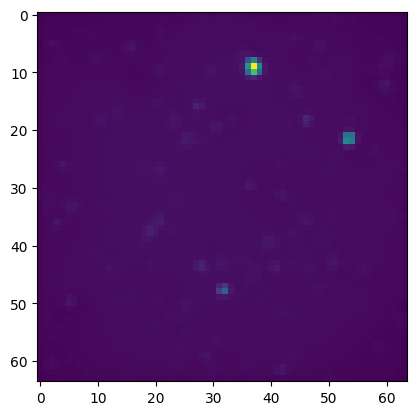

In [ ]:
plt.imshow(all_arrays[0][0])

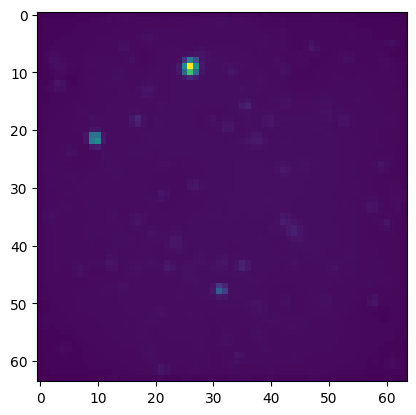

In [ ]:
plt.imshow(all_arrays[1][0])

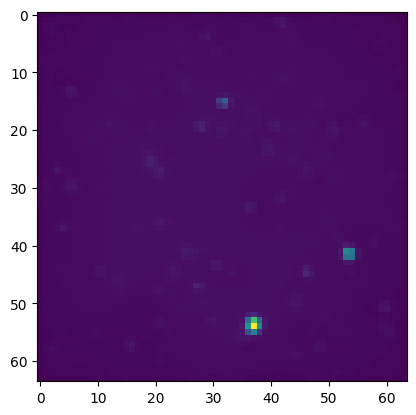

In [ ]:
plt.imshow(all_arrays[2][0])

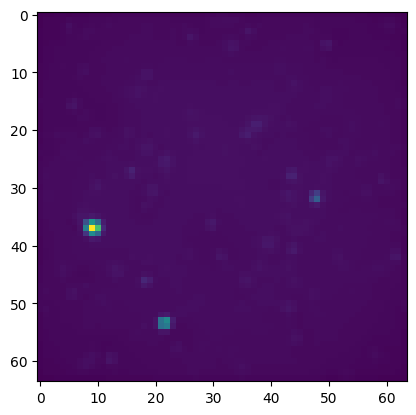

In [ ]:
plt.imshow(all_arrays[3][0])

# Normalize pixel values to max 1

In [4]:
#First, we should find the max value of all pixel values in arrays
#And divide everything by that value to get a max of 1
#this improves the performance of the model because it makes gradient descent steps more consistently appropriate

max_pixel = 0

for i in original_arrays:
  max_of_array = i.max()
  if max_of_array>max_pixel:
    max_pixel=max_of_array
  else:
    continue
print(max_pixel)

65478


In [5]:
all_scaled_arrays = all_arrays.copy()

for each in all_scaled_arrays:
  for i in range(len(each)):
    each[i] = each[i]/65478

print("original", all_scaled_arrays[0][0])
print("h flip", all_scaled_arrays[1][0])
print("v flip", all_scaled_arrays[2][0])
print("bflip", all_scaled_arrays[3][0])

original [[0.01907511 0.02296955 0.02304591 ... 0.02329027 0.02206848 0.01792969]
 [0.02240447 0.02681817 0.02730688 ... 0.02839122 0.0269098  0.02202266]
 [0.02257247 0.02712361 0.02759706 ... 0.02883411 0.02778032 0.02277101]
 ...
 [0.02374843 0.03602737 0.04089923 ... 0.02785668 0.02701671 0.02254192]
 [0.02081615 0.02729161 0.03046825 ... 0.02686398 0.02603928 0.02170195]
 [0.01653991 0.02092306 0.02486331 ... 0.02246556 0.0212285  0.01741043]]
h flip [[0.01792969 0.02206848 0.02329027 ... 0.02304591 0.02296955 0.01907511]
 [0.02202266 0.0269098  0.02839122 ... 0.02730688 0.02681817 0.02240447]
 [0.02277101 0.02778032 0.02883411 ... 0.02759706 0.02712361 0.02257247]
 ...
 [0.02254192 0.02701671 0.02785668 ... 0.04089923 0.03602737 0.02374843]
 [0.02170195 0.02603928 0.02686398 ... 0.03046825 0.02729161 0.02081615]
 [0.01741043 0.0212285  0.02246556 ... 0.02486331 0.02092306 0.01653991]]
v flip [[0.01653991 0.02092306 0.02486331 ... 0.02246556 0.0212285  0.01741043]
 [0.02081615 0.0

In [6]:
max_pixel = 0

for i in all_scaled_arrays[0]:
  max_of_array = i.max()
  if max_of_array>max_pixel:
    max_pixel=max_of_array
  else:
    continue
print(max_pixel)


1.0


# Adjust array shape to be compatible with tensorflow expectations

In [7]:
#we must change shape from (64,64) to (64, 64, 1) to tell tensorflow that there is one channel
#for later processing
# (shown in pseudocolor above)
expanded_scaled_arrays = all_scaled_arrays.copy()
expanded_scaled_arrays[0][0].shape
for each in expanded_scaled_arrays:
  for i in range(len(each)):
    each[i] = np.expand_dims(each[i], axis=2)
  print(len(expanded_scaled_arrays))
  print(len(expanded_scaled_arrays[0]))
  print(expanded_scaled_arrays[0][0].shape)

4
384
(64, 64, 1)
4
384
(64, 64, 1)
4
384
(64, 64, 1)
4
384
(64, 64, 1)


# Establish convenient collections of augmented data sets

In [8]:
#so now the arrays are ready to go
#we can put them together in groups to see which augmentations help vs the original image performance

og_scaled_arrays = expanded_scaled_arrays[0].copy()

ogh_scaled_arrays = expanded_scaled_arrays[0].copy() + expanded_scaled_arrays[1].copy()

ogv_scaled_arrays = expanded_scaled_arrays[0].copy() + expanded_scaled_arrays[2].copy()

ogb_scaled_arrays = expanded_scaled_arrays[0].copy() + expanded_scaled_arrays[3].copy()

total_scaled_arrays = expanded_scaled_arrays[0].copy() + expanded_scaled_arrays[1].copy()+ expanded_scaled_arrays[2].copy()+ expanded_scaled_arrays[3].copy()

print(len(og_scaled_arrays), len(ogh_scaled_arrays), len(ogv_scaled_arrays), len(ogb_scaled_arrays), len(total_scaled_arrays))

384 768 768 768 1536


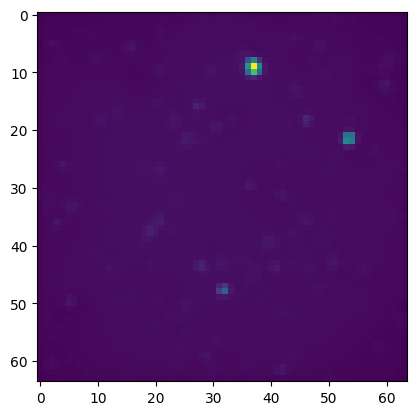

In [ ]:
plt.imshow(total_scaled_arrays[0])

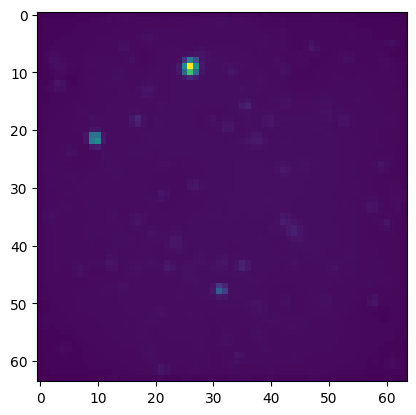

In [ ]:
plt.imshow(total_scaled_arrays[384])

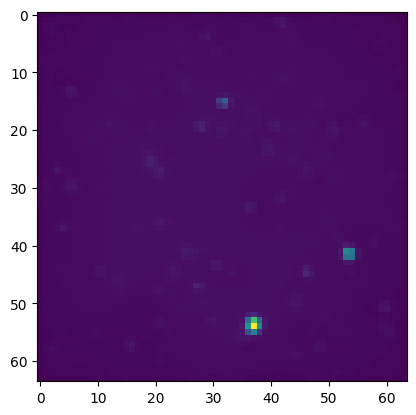

In [ ]:
plt.imshow(total_scaled_arrays[0+384+384])

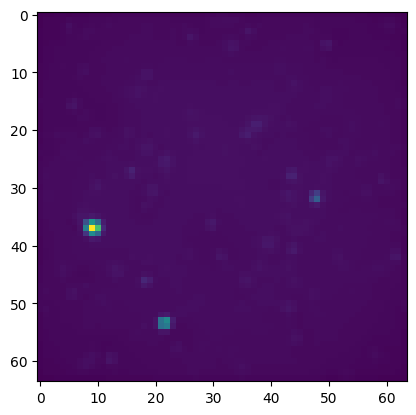

In [ ]:
plt.imshow(total_scaled_arrays[0+384+384+384])

# Read in Cytokine Labels

In [9]:
# we need to associate every array with a cytokine now

#Read in labels csv

binned = pd.read_csv('binned_cytokines.csv')
binned = binned.iloc[:,1:].apply(np.int64)

binned



Activin A  Amphiregulin  CCL1  CCL19  CCL2  CCL20  CCL22  CCL4  CCL5  \
0            0             0     0      0     1      0      0     0     1   
1            0             0     0      0     1      1      1     0     1   
2            0             0     0      0     0      1      1     0     1   
3            0             0     0      0     0      0      0     0     1   
4            0             0     0      0     0      0      0     0     1   
..         ...           ...   ...    ...   ...    ...    ...   ...   ...   
379          0             0     0      0     0      0      0     0     0   
380          0             0     0      0     0      0      0     0     0   
381          0             0     0      0     0      0      0     0     0   
382          0             0     1      0     0      0      1     1     1   
383          0             0     0      0     0      0      0     0     0   

     CCL8  ...  IL-4  IL-6 R alpha  IL-6  IL-8  MMP-1  MMP-9  \
0       0  ...     0             0     0     1      1      0   
1       0  ...     0             0     1     0      1      0   
2       0  ...     0             0     0     0      1      0   
3       0  ...     0             0     1     0      1      0   
4       0  ...     0             0     0     0      0      0   
..    ...  ...   ...           ...   ...   ...    ...    ...   
379     0  ...     0             0     1     0      0      0   
380     0  ...     0             0     0     0      0      0   
381     0  ...     0             0     1     0      1      0   
382     0  ...     0             0     1     1      1      1   
383     0  ...     0             0     1     0      1      0   

     Osteopontin (OPN)  SAA  TNF RII  TNF alpha  
0                    1    0        0          0  
1                    0    0        0          0  
2                    0    0        0          0  
3                    0    0        0          0  
4                    0    0        0          0  
..                 ...  ...      ...        ...  
379                  1    0        0          0  
380                  1    0        0          0  
381                  1    0        0          0  
382                  1    0        0          0  
383                  1    0        0          0  

[384 rows x 40 columns]

In [10]:
binned.columns

cytokines = ['Activin A', 'Amphiregulin', 'CCL1', 'CCL19', 'CCL2', 'CCL20',
       'CCL22', 'CCL4', 'CCL5', 'CCL8', 'CD14', 'CRP', 'CX3CL1', 'CXCL1',
       'CXCL10', 'CXCL11', 'CXCL13', 'CXCL16', 'CXCL3', 'CXCL4', 'CXCL5',
       'G-CSF', 'GM-CSF', 'IL-1 RA/RN', 'IL-1 alpha', 'IL-1 beta', 'IL-10',
       'IL-12 p40', 'IL-15', 'IL-16', 'IL-4', 'IL-6 R alpha', 'IL-6', 'IL-8',
       'MMP-1', 'MMP-9', 'Osteopontin (OPN)', 'SAA', 'TNF RII', 'TNF alpha']

In [13]:
binned

Activin A  Amphiregulin  CCL1  CCL19  CCL2  CCL20  CCL22  CCL4  CCL5  \
0            0             0     0      0     1      0      0     0     1   
1            0             0     0      0     1      1      1     0     1   
2            0             0     0      0     0      1      1     0     1   
3            0             0     0      0     0      0      0     0     1   
4            0             0     0      0     0      0      0     0     1   
..         ...           ...   ...    ...   ...    ...    ...   ...   ...   
379          0             0     0      0     0      0      0     0     0   
380          0             0     0      0     0      0      0     0     0   
381          0             0     0      0     0      0      0     0     0   
382          0             0     1      0     0      0      1     1     1   
383          0             0     0      0     0      0      0     0     0   

     CCL8  ...  IL-4  IL-6 R alpha  IL-6  IL-8  MMP-1  MMP-9  \
0       0  ...     0             0     0     1      1      0   
1       0  ...     0             0     1     0      1      0   
2       0  ...     0             0     0     0      1      0   
3       0  ...     0             0     1     0      1      0   
4       0  ...     0             0     0     0      0      0   
..    ...  ...   ...           ...   ...   ...    ...    ...   
379     0  ...     0             0     1     0      0      0   
380     0  ...     0             0     0     0      0      0   
381     0  ...     0             0     1     0      1      0   
382     0  ...     0             0     1     1      1      1   
383     0  ...     0             0     1     0      1      0   

     Osteopontin (OPN)  SAA  TNF RII  TNF alpha  
0                    1    0        0          0  
1                    0    0        0          0  
2                    0    0        0          0  
3                    0    0        0          0  
4                    0    0        0          0  
..                 ...  ...      ...        ...  
379                  1    0        0          0  
380                  1    0        0          0  
381                  1    0        0          0  
382                  1    0        0          0  
383                  1    0        0          0  

[384 rows x 40 columns]

# Balance classes for each cytokine

In [11]:
#This errors when it reaches the end of the list, but works appropriately

#Make the downsampled dfs

eachcolumn = range(0, 41, 1)
success = []
holdingdfs = []

# try using arrays instead

for item in eachcolumn:
    # print(binned.iloc[:,item:item+1])
    binarized_values = binned.iloc[:,item:item+1]
#get the binned cytokine column and get the name for it from the list above
    one = pd.DataFrame(data = binarized_values, columns = [cytokines[item]])
    print(one)
#keep track of cytokine title
#     cytotitle = one.columns[0]
#grab all the positives from the binning
    two = one[one[one.columns[0]]>0.5]
#grab all the negatives from the beginning
    three = one[one[one.columns[0]]<0.5]
#take random samples of the negatives in an equal ratio to the positives
    try:
        three = three.sample(n=len(two))
    except:
      continue
#put the positives and downsampled negatives back together
    four = pd.concat([two, three])
#use this list to keep track of all the succesfully attached embeddings
    success.append(cytokines[item])
#use this list to keep track of all the final dataframes
    holdingdfs.append(four)

     Activin A
0            0
1            0
2            0
3            0
4            0
..         ...
379          0
380          0
381          0
382          0
383          0

[384 rows x 1 columns]
     Amphiregulin
0               0
1               0
2               0
3               0
4               0
..            ...
379             0
380             0
381             0
382             0
383             0

[384 rows x 1 columns]
     CCL1
0       0
1       0
2       0
3       0
4       0
..    ...
379     0
380     0
381     0
382     1
383     0

[384 rows x 1 columns]
     CCL19
0        0
1        0
2        0
3        0
4        0
..     ...
379      0
380      0
381      0
382      0
383      0

[384 rows x 1 columns]
     CCL2
0       1
1       1
2       0
3       0
4       0
..    ...
379     0
380     0
381     0
382     0
383     0

[384 rows x 1 columns]
     CCL20
0        0
1        1
2        1
3        0
4        0
..     ...
379      0
380      0
381      0
38

IndexError: ignored

In [13]:
holdingdfs[-1]
#ok, we got all the cytokines here and the appropriate indices

TNF alpha
31           1
32           1
34           1
36           1
96           1
..         ...
74           0
39           0
283          0
76           0
347          0

[124 rows x 1 columns]

# Remove cytokines without a sufficient number of observations

In [12]:
#Now let's remove everything that is too short
#This means there weren't enough positive response wells for that cytokine

# less than 15 length is too short.
#this will also error due to the use of pop, but does succesfully remove the right dfs
longdfs = holdingdfs.copy()
for i in range(len(longdfs)):
  length = len(longdfs[i])
  if length <15:
    longdfs.pop(i)

IndexError: ignored

In [13]:
#Check that the short dfs were removed
print(len(holdingdfs))
print(len(longdfs))

35
27


Include some code for collecting the precision and recall throughout the modeling process. (These aren't in keras metrics anymore, funny enough.)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

def confusio_matrix(y_test, preds, target):
  cm = confusion_matrix(y_test, preds)
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos
  recall = (cm[1][1])/(cm[1][1] + cm[1][0])  #TruePositives / (TruePositives + FalseNegatives)
  # plt.figure(figsize=(15,10))
  # plt.clf()
  # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  # classNames = ['Negative','Positive']
  # plt.title('Confusion Matrix')
  # plt.ylabel('True label')
  # plt.xlabel('Predicted label')
  # tick_marks = np.arange(len(classNames))
  # plt.xticks(tick_marks, classNames, rotation=45)
  # plt.yticks(tick_marks, classNames)
  # s = [['TN','FP'], ['FN', 'TP']]

  # for i in range(2):
  #     for j in range(2):
  #         plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  # plt.show()
  # print(target, "precision", "=", precision,"recall", "=", recall)
  return precision, recall

#STEP THREE MODELING

#Iniitial CNN model

# For each cytokine, fetch arrays (features) and labels (target). Then train a CNN and get predictions. Retain the important metrics.
# This is repeated for each dataset, two fold

#Then summarize the metrics.



In [19]:
#create the CNN
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 1)))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Conv2D(128, (3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Conv2D(256, (3,3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(2))

cnn_model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['val_accuracy'])



In [20]:
# model_temp = cnn_model

model_temp = tf.keras.models.clone_model(cnn_model)
model_temp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

# Run deeper CNN model per cytokine, per augmentation, two fold

In [23]:
#let's collect the performance of the first CNN model for all cytokines

totalresults_firstcnn = []

#loop through all the cytokines, which are each in their own dataframes
for df in longdfs:

#set up lists to collect our features and targets
  features_collector = []
  targets_collector = []

  features_og = []
  features_ogh = []
  features_ogv = []
  features_ogb = []
  features_total = []


  targets_og = []
  targets_ogh = []
  targets_ogv = []
  targets_ogb = []
  targets_total = []

#go fetch the image arrays for each downsampled cytokine
  indices = list(df.index.values)
  for i in indices:
    thing = total_scaled_arrays[i]
    features_og.append(thing)
    features_ogh.append(thing)
    features_ogv.append(thing)
    features_ogb.append(thing)
    features_total.append(thing)
    thing2 = total_scaled_arrays[i+384]
    features_ogh.append(thing2)
    features_total.append(thing2)
    thing3 = total_scaled_arrays[i+384+384]
    features_ogv.append(thing)
    features_total.append(thing3)
    thing4 = total_scaled_arrays[i+384+384+384]
    features_ogb.append(thing)
    features_total.append(thing4)


#fetch the labels for each of these and make sure it matches the length of the features
  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]

#this is 2 arrays
#put them together without separation to match structure of features
  targets_og = targets_og + target2[0]
  targets_ogh = targets_ogh + target2[0] + target2[1]
  targets_ogv = targets_ogv + target2[0] + target2[2]
  targets_ogb = targets_ogb + target2[0] + target2[3]
  targets_total = targets_total + target2[0] + target2[1] + target2[2] + target2[3]

#get everything in the collector
  features_collector.append(features_og)
  features_collector.append(features_ogh)
  features_collector.append(features_ogv)
  features_collector.append(features_ogb)
  features_collector.append(features_total)

  targets_collector.append(targets_og)
  targets_collector.append(targets_ogh)
  targets_collector.append(targets_ogv)
  targets_collector.append(targets_ogb)
  targets_collector.append(targets_total)

#jot down the order of augmentations
  augmentation = ["None", "Horizontal", "Vertical", "Transposed", 'Total']

#loop through these augmented data sets
  for j in range(0,5):
    features_now = features_collector[j]
    target2final_now = targets_collector[j]
    aug = augmentation[j]

    # print(features)
    # print(target2final)

    print(len(features_now))
    print(len(target2final_now))

#just do two fold validation
    for number in range(0,2):
      model_temp = tf.keras.models.clone_model(cnn_model)

      model_temp.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

#train test split and make into arrays

      X_train, X_test, y_train, y_test = train_test_split(features_now, target2final_now, test_size=0.2)

      train_images = np.array(X_train)
      train_labels = np.array(y_train)
      test_images = np.array(X_test)
      test_labels = np.array(y_test)

      # print((train_images.shape))
      # print((train_labels.shape))
      # print((test_images.shape))
      # print((test_labels.shape))

#grab metrics

      model_temp.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), batch_size=40, callbacks = [callback])

      loss, accuracy = model_temp.evaluate(test_images, test_labels, verbose=0)

#get the predictions and calculate precision, recall, F1 score
      preds = []
      predictions = model_temp.predict(test_images)
      preds.append([predictions])

      answer = []
      for i in range(len(preds[0])):
        temp  = preds[0][i]
        for j in range(len(temp)):
          if temp[j][0]< temp[j][1]:
            answer.append(1)
          else:
            answer.append(0)

      precision, recall = confusio_matrix(test_labels, answer, df.columns[0])
      f1_score = 2 * (precision * recall) / (precision + recall)

#append the metrics to the results
      totalresults_firstcnn.append([loss, accuracy, f1_score, precision, recall, df.columns[0], number, aug])

#show the progress
      print(df.columns[0],"_fold", number, "aug", aug)

#summarize metrics by reading through the list and putting it in a dataframe

summarizer_total_firstcnn = pd.DataFrame(columns =["Loss", "Accuracy", "F1_score", "Precision", "Recall", "Cytokine","Fold Number","Augmentation"])

for k in range(len(totalresults_firstcnn)):
  loss = totalresults_firstcnn[k][0]
  accuracy = totalresults_firstcnn[k][1]
  f1_score = totalresults_firstcnn[k][2]
  precision = totalresults_firstcnn[k][3]
  recall = totalresults_firstcnn[k][4]
  cytokine = totalresults_firstcnn[k][5]
  fold = totalresults_firstcnn[k][6]
  augmentation = totalresults_firstcnn[k][7]
  tracking = [loss, accuracy, f1_score, precision, recall, cytokine, fold, augmentation]
  summarizer_total_firstcnn.loc[len(summarizer_total_firstcnn.index)] = tracking

94
94
Epoch 1/10
2/2 [==============================] - 3s 913ms/step - loss: 0.6922 - accuracy: 0.6000 - val_loss: 0.7156 - val_accuracy: 0.3684
Epoch 2/10
2/2 [==============================] - 1s 426ms/step - loss: 0.6935 - accuracy: 0.5333 - val_loss: 0.7120 - val_accuracy: 0.3684
Epoch 3/10
2/2 [==============================] - 1s 699ms/step - loss: 0.6898 - accuracy: 0.5333 - val_loss: 0.7072 - val_accuracy: 0.3684
Epoch 4/10
2/2 [==============================] - 1s 687ms/step - loss: 0.6845 - accuracy: 0.5467 - val_loss: 0.7008 - val_accuracy: 0.3684
Epoch 5/10
2/2 [==============================] - 1s 477ms/step - loss: 0.6802 - accuracy: 0.5733 - val_loss: 0.7067 - val_accuracy: 0.3158
Epoch 6/10
2/2 [==============================] - 1s 408ms/step - loss: 0.6804 - accuracy: 0.5467 - val_loss: 0.7233 - val_accuracy: 0.3684
Epoch 7/10
2/2 [==============================] - 1s 423ms/step - loss: 0.6588 - accuracy: 0.5867 - val_loss: 0.7032 - val_accuracy: 0.3684
Epoch 8/10
2/2

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


4/4 [==============================] - 2s 302ms/step - loss: 0.6942 - accuracy: 0.4600 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 1s 248ms/step - loss: 0.6921 - accuracy: 0.5067 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 1s 252ms/step - loss: 0.6897 - accuracy: 0.5067 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 1s 250ms/step - loss: 0.6831 - accuracy: 0.5067 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 2s 460ms/step - loss: 0.6706 - accuracy: 0.5467 - val_loss: 0.6972 - val_accuracy: 0.3158
Epoch 6/10
4/4 [==============================] - 2s 366ms/step - loss: 0.6597 - accuracy: 0.5933 - val_loss: 0.6965 - val_accuracy: 0.4737
Epoch 7/10
4/4 [==============================] - 1s 244ms/step - loss: 0.6418 - accuracy: 0.6400 - val_loss: 0.6961 - val_accuracy: 0.5263
Epoch 8/10
4/4 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 2s 2s/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 270ms/step - loss: 0.6906 - accuracy: 0.5526 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 263ms/step - loss: 0.6867 - accuracy: 0.5526 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 265ms/step - loss: 0.6795 - accuracy: 0.5526 - val_loss: 0.7027 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 284ms/step - loss: 0.6694 - accuracy: 0.5526 - val_loss: 0.7128 - val_accuracy: 0.3000
Epoch 6/10
1/1 [==============================] - 0s 268ms/step - loss: 0.6536 - accuracy: 0.5263 - val_loss: 0.7316 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 274ms/step - loss: 0.6339 - accuracy: 0.6316 - val_loss: 0.7658 - val_accuracy: 0.5000
Epoch 8/10
1/1 [==================

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 2s 2s/step - loss: 0.6933 - accuracy: 0.4474 - val_loss: 0.6898 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 286ms/step - loss: 0.6909 - accuracy: 0.5000 - val_loss: 0.6854 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 261ms/step - loss: 0.6871 - accuracy: 0.5000 - val_loss: 0.6805 - val_accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 0s 335ms/step - loss: 0.6814 - accuracy: 0.5263 - val_loss: 0.6714 - val_accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 0s 469ms/step - loss: 0.6721 - accuracy: 0.5263 - val_loss: 0.6575 - val_accuracy: 0.7000
Epoch 6/10
1/1 [==============================] - 1s 523ms/step - loss: 0.6581 - accuracy: 0.6579 - val_loss: 0.6371 - val_accuracy: 0.7000
Epoch 7/10
1/1 [==============================] - 0s 487ms/step - loss: 0.6386 - accuracy: 0.7105 - val_loss: 0.6187 - val_accuracy: 0.8000
Epoch 8/10
1/1 [==================

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 2s 451ms/step - loss: 0.6942 - accuracy: 0.5205 - val_loss: 0.6961 - val_accuracy: 0.4211
Epoch 2/10
2/2 [==============================] - 0s 276ms/step - loss: 0.6907 - accuracy: 0.5205 - val_loss: 0.6992 - val_accuracy: 0.4211
Epoch 3/10
2/2 [==============================] - 1s 277ms/step - loss: 0.6949 - accuracy: 0.5205 - val_loss: 0.7039 - val_accuracy: 0.4211
Epoch 4/10
2/2 [==============================] - 0s 273ms/step - loss: 0.6852 - accuracy: 0.5205 - val_loss: 0.6977 - val_accuracy: 0.4211
Epoch 5/10
2/2 [==============================] - 1s 279ms/step - loss: 0.6844 - accuracy: 0.5753 - val_loss: 0.6987 - val_accuracy: 0.4211
Epoch 6/10
2/2 [==============================] - 1s 277ms/step - loss: 0.6775 - accuracy: 0.5753 - val_loss: 0.6992 - val_accuracy: 0.4211
Epoch 7/10
2/2 [==============================] - 1s 280ms/step - loss: 0.6654 - accuracy: 0.5616 - val_loss: 0.7186 - val_accuracy: 0.4211
Epoch 8/10
2/2 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 1s 1s/step - loss: 0.6927 - accuracy: 0.4815 - val_loss: 0.6956 - val_accuracy: 0.4286
Epoch 2/10
1/1 [==============================] - 0s 213ms/step - loss: 0.6894 - accuracy: 0.5926 - val_loss: 0.7009 - val_accuracy: 0.5714
Epoch 3/10
1/1 [==============================] - 0s 209ms/step - loss: 0.6843 - accuracy: 0.6667 - val_loss: 0.7083 - val_accuracy: 0.5714
Epoch 4/10
1/1 [==============================] - 0s 212ms/step - loss: 0.6766 - accuracy: 0.7037 - val_loss: 0.7163 - val_accuracy: 0.1429
Epoch 5/10
1/1 [==============================] - 0s 210ms/step - loss: 0.6639 - accuracy: 0.7037 - val_loss: 0.7293 - val_accuracy: 0.1429
Epoch 6/10
1/1 [==============================] - 0s 223ms/step - loss: 0.6463 - accuracy: 0.6296 - val_loss: 0.7569 - val_accuracy: 0.1429
Epoch 7/10
1/1 [==============================] - 0s 215ms/step - loss: 0.6228 - accuracy: 0.6667 - val_loss: 0.7838 - val_accuracy: 0.1429
Epoch 8/10
1/1 [==================

<ipython-input-23-bd395c655ffb>:128: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (precision * recall) / (precision + recall)


2/2 [==============================] - 2s 319ms/step - loss: 0.6933 - accuracy: 0.4815 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 187ms/step - loss: 0.6876 - accuracy: 0.5000 - val_loss: 0.6876 - val_accuracy: 0.5714
Epoch 3/10
2/2 [==============================] - 1s 249ms/step - loss: 0.6792 - accuracy: 0.6296 - val_loss: 0.6784 - val_accuracy: 0.6429
Epoch 4/10
2/2 [==============================] - 1s 251ms/step - loss: 0.6635 - accuracy: 0.6296 - val_loss: 0.6799 - val_accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 1s 264ms/step - loss: 0.6522 - accuracy: 0.5556 - val_loss: 0.6758 - val_accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 1s 270ms/step - loss: 0.6482 - accuracy: 0.6111 - val_loss: 0.6372 - val_accuracy: 0.5714
Epoch 7/10
2/2 [==============================] - 0s 138ms/step - loss: 0.6028 - accuracy: 0.6111 - val_loss: 0.6198 - val_accuracy: 0.5000
Epoch 8/10
2/2 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 1s 1s/step - loss: 0.6932 - accuracy: 0.4091 - val_loss: 0.6966 - val_accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - 0s 173ms/step - loss: 0.6900 - accuracy: 0.5455 - val_loss: 0.7090 - val_accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 0s 176ms/step - loss: 0.6854 - accuracy: 0.5455 - val_loss: 0.7347 - val_accuracy: 0.3333
Epoch 4/10
1/1 [==============================] - 0s 174ms/step - loss: 0.6826 - accuracy: 0.5455 - val_loss: 0.7256 - val_accuracy: 0.3333
Epoch 5/10
1/1 [==============================] - 0s 199ms/step - loss: 0.6763 - accuracy: 0.5455 - val_loss: 0.7080 - val_accuracy: 0.3333
Epoch 6/10
1/1 [==============================] - 0s 184ms/step - loss: 0.6673 - accuracy: 0.5455 - val_loss: 0.6942 - val_accuracy: 0.3333
Epoch 7/10
1/1 [==============================] - 0s 189ms/step - loss: 0.6555 - accuracy: 0.5455 - val_loss: 0.6829 - val_accuracy: 0.3333
Epoch 8/10
1/1 [==================

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


4/4 [==============================] - 2s 290ms/step - loss: 0.6980 - accuracy: 0.4604 - val_loss: 0.6948 - val_accuracy: 0.4571
Epoch 2/10
4/4 [==============================] - 1s 229ms/step - loss: 0.6921 - accuracy: 0.5468 - val_loss: 0.6926 - val_accuracy: 0.5429
Epoch 3/10
4/4 [==============================] - 1s 225ms/step - loss: 0.6915 - accuracy: 0.4892 - val_loss: 0.6929 - val_accuracy: 0.5714
Epoch 4/10
4/4 [==============================] - 1s 221ms/step - loss: 0.6877 - accuracy: 0.5540 - val_loss: 0.6925 - val_accuracy: 0.5429
Epoch 5/10
4/4 [==============================] - 1s 221ms/step - loss: 0.6806 - accuracy: 0.5396 - val_loss: 0.6943 - val_accuracy: 0.4857
Epoch 6/10
4/4 [==============================] - 1s 225ms/step - loss: 0.6654 - accuracy: 0.6043 - val_loss: 0.7057 - val_accuracy: 0.5143
Epoch 7/10
4/4 [==============================] - 1s 396ms/step - loss: 0.6439 - accuracy: 0.6115 - val_loss: 0.7144 - val_accuracy: 0.4286
Epoch 8/10
4/4 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 1s 1s/step - loss: 0.6931 - accuracy: 0.5833 - val_loss: 0.6959 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 136ms/step - loss: 0.6869 - accuracy: 0.6667 - val_loss: 0.6992 - val_accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - 0s 121ms/step - loss: 0.6769 - accuracy: 0.7500 - val_loss: 0.7073 - val_accuracy: 0.2500
Epoch 4/10
1/1 [==============================] - 0s 119ms/step - loss: 0.6602 - accuracy: 0.7500 - val_loss: 0.7152 - val_accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 0s 120ms/step - loss: 0.6341 - accuracy: 0.7500 - val_loss: 0.7341 - val_accuracy: 0.2500
Epoch 6/10
1/1 [==============================] - 0s 133ms/step - loss: 0.5961 - accuracy: 0.7500 - val_loss: 0.7424 - val_accuracy: 0.2500
Epoch 7/10
1/1 [==============================] - 0s 116ms/step - loss: 0.5451 - accuracy: 0.8333 - val_loss: 0.8179 - val_accuracy: 0.2500
Epoch 8/10
1/1 [==================

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 1s 1s/step - loss: 0.6933 - accuracy: 0.5200 - val_loss: 0.6937 - val_accuracy: 0.2857
Epoch 2/10
1/1 [==============================] - 0s 211ms/step - loss: 0.6883 - accuracy: 0.7200 - val_loss: 0.6995 - val_accuracy: 0.2857
Epoch 3/10
1/1 [==============================] - 0s 206ms/step - loss: 0.6776 - accuracy: 0.7200 - val_loss: 0.7043 - val_accuracy: 0.2857
Epoch 4/10
1/1 [==============================] - 0s 196ms/step - loss: 0.6609 - accuracy: 0.7200 - val_loss: 0.7094 - val_accuracy: 0.2857
Epoch 5/10
1/1 [==============================] - 0s 191ms/step - loss: 0.6343 - accuracy: 0.7200 - val_loss: 0.7402 - val_accuracy: 0.2857
Epoch 6/10
1/1 [==============================] - 0s 190ms/step - loss: 0.5978 - accuracy: 0.7200 - val_loss: 0.7931 - val_accuracy: 0.2857
Epoch 7/10
1/1 [==============================] - 0s 211ms/step - loss: 0.5550 - accuracy: 0.7200 - val_loss: 0.8456 - val_accuracy: 0.2857
Epoch 8/10
1/1 [==================

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 1s 1s/step - loss: 0.6935 - accuracy: 0.4800 - val_loss: 0.6985 - val_accuracy: 0.2857
Epoch 2/10
1/1 [==============================] - 0s 204ms/step - loss: 0.6839 - accuracy: 0.6400 - val_loss: 0.7180 - val_accuracy: 0.2857
Epoch 3/10
1/1 [==============================] - 0s 196ms/step - loss: 0.6662 - accuracy: 0.5600 - val_loss: 0.7757 - val_accuracy: 0.2857
Epoch 4/10
1/1 [==============================] - 0s 200ms/step - loss: 0.6502 - accuracy: 0.5600 - val_loss: 0.8261 - val_accuracy: 0.2857
Epoch 5/10
1/1 [==============================] - 0s 192ms/step - loss: 0.6400 - accuracy: 0.5600 - val_loss: 0.7588 - val_accuracy: 0.2857
Epoch 6/10
1/1 [==============================] - 0s 186ms/step - loss: 0.6166 - accuracy: 0.6400 - val_loss: 0.7253 - val_accuracy: 0.2857
Epoch 7/10
1/1 [==============================] - 0s 214ms/step - loss: 0.6010 - accuracy: 0.6400 - val_loss: 0.7566 - val_accuracy: 0.2857
Epoch 8/10
1/1 [==================

<ipython-input-23-bd395c655ffb>:128: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (precision * recall) / (precision + recall)


5/5 [==============================] - 2s 285ms/step - loss: 0.6919 - accuracy: 0.5284 - val_loss: 0.7141 - val_accuracy: 0.3409
Epoch 2/10
5/5 [==============================] - 1s 225ms/step - loss: 0.6866 - accuracy: 0.5625 - val_loss: 0.7238 - val_accuracy: 0.3864
Epoch 3/10
5/5 [==============================] - 1s 266ms/step - loss: 0.6684 - accuracy: 0.6080 - val_loss: 0.6979 - val_accuracy: 0.4091
Epoch 4/10
5/5 [==============================] - 2s 399ms/step - loss: 0.6547 - accuracy: 0.6023 - val_loss: 0.7009 - val_accuracy: 0.4318
Epoch 5/10
5/5 [==============================] - 1s 226ms/step - loss: 0.6301 - accuracy: 0.6364 - val_loss: 0.6893 - val_accuracy: 0.4773
Epoch 6/10
5/5 [==============================] - 1s 242ms/step - loss: 0.5990 - accuracy: 0.6534 - val_loss: 0.8075 - val_accuracy: 0.4545
Epoch 7/10
5/5 [==============================] - 1s 226ms/step - loss: 0.5947 - accuracy: 0.6705 - val_loss: 0.6751 - val_accuracy: 0.5000
Epoch 8/10
5/5 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


4/4 [==============================] - 2s 288ms/step - loss: 0.6935 - accuracy: 0.4931 - val_loss: 0.6948 - val_accuracy: 0.4444
Epoch 2/10
4/4 [==============================] - 1s 234ms/step - loss: 0.6931 - accuracy: 0.5139 - val_loss: 0.6954 - val_accuracy: 0.4444
Epoch 3/10
4/4 [==============================] - 1s 235ms/step - loss: 0.6932 - accuracy: 0.5139 - val_loss: 0.6971 - val_accuracy: 0.4444
Epoch 4/10
4/4 [==============================] - 1s 232ms/step - loss: 0.6919 - accuracy: 0.5139 - val_loss: 0.6970 - val_accuracy: 0.3889
Epoch 5/10
4/4 [==============================] - 1s 228ms/step - loss: 0.6899 - accuracy: 0.5833 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 1s 318ms/step - loss: 0.6879 - accuracy: 0.5000 - val_loss: 0.7021 - val_accuracy: 0.4444
Epoch 7/10
4/4 [==============================] - 2s 419ms/step - loss: 0.6778 - accuracy: 0.5486 - val_loss: 0.7121 - val_accuracy: 0.4722
Epoch 8/10
4/4 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


3/3 [==============================] - 2s 272ms/step - loss: 0.6940 - accuracy: 0.5581 - val_loss: 0.7099 - val_accuracy: 0.3636
Epoch 2/10
3/3 [==============================] - 1s 163ms/step - loss: 0.6893 - accuracy: 0.5349 - val_loss: 0.6950 - val_accuracy: 0.4091
Epoch 3/10
3/3 [==============================] - 1s 185ms/step - loss: 0.6915 - accuracy: 0.6860 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 318ms/step - loss: 0.6915 - accuracy: 0.6279 - val_loss: 0.6968 - val_accuracy: 0.4091
Epoch 5/10
3/3 [==============================] - 1s 294ms/step - loss: 0.6885 - accuracy: 0.6279 - val_loss: 0.7079 - val_accuracy: 0.3636
Epoch 6/10
3/3 [==============================] - 1s 280ms/step - loss: 0.6820 - accuracy: 0.5581 - val_loss: 0.7441 - val_accuracy: 0.3636
Epoch 7/10
3/3 [==============================] - 1s 169ms/step - loss: 0.6721 - accuracy: 0.5581 - val_loss: 0.7924 - val_accuracy: 0.3636
Epoch 8/10
3/3 [===============

<ipython-input-23-bd395c655ffb>:128: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (precision * recall) / (precision + recall)


3/3 [==============================] - 2s 325ms/step - loss: 0.6945 - accuracy: 0.4630 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 1s 247ms/step - loss: 0.6930 - accuracy: 0.5278 - val_loss: 0.6931 - val_accuracy: 0.4643
Epoch 3/10
3/3 [==============================] - 1s 243ms/step - loss: 0.6912 - accuracy: 0.5370 - val_loss: 0.6936 - val_accuracy: 0.4286
Epoch 4/10
3/3 [==============================] - 1s 235ms/step - loss: 0.6887 - accuracy: 0.5185 - val_loss: 0.6919 - val_accuracy: 0.4286
Epoch 5/10
3/3 [==============================] - 1s 254ms/step - loss: 0.6833 - accuracy: 0.5278 - val_loss: 0.6906 - val_accuracy: 0.4286
Epoch 6/10
3/3 [==============================] - 1s 254ms/step - loss: 0.6740 - accuracy: 0.5556 - val_loss: 0.6876 - val_accuracy: 0.6071
Epoch 7/10
3/3 [==============================] - 1s 250ms/step - loss: 0.6462 - accuracy: 0.6019 - val_loss: 0.7031 - val_accuracy: 0.5714
Epoch 8/10
3/3 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 2s 451ms/step - loss: 0.6950 - accuracy: 0.4714 - val_loss: 0.6974 - val_accuracy: 0.4444
Epoch 2/10
2/2 [==============================] - 1s 275ms/step - loss: 0.6918 - accuracy: 0.5143 - val_loss: 0.6992 - val_accuracy: 0.4444
Epoch 3/10
2/2 [==============================] - 1s 423ms/step - loss: 0.6913 - accuracy: 0.5571 - val_loss: 0.7015 - val_accuracy: 0.4444
Epoch 4/10
2/2 [==============================] - 1s 415ms/step - loss: 0.6883 - accuracy: 0.5143 - val_loss: 0.7160 - val_accuracy: 0.4444
Epoch 5/10
2/2 [==============================] - 1s 391ms/step - loss: 0.6868 - accuracy: 0.5143 - val_loss: 0.7236 - val_accuracy: 0.4444
Epoch 6/10
2/2 [==============================] - 1s 258ms/step - loss: 0.6771 - accuracy: 0.6143 - val_loss: 0.6973 - val_accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 0s 252ms/step - loss: 0.6662 - accuracy: 0.6714 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 8/10
2/2 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


4/4 [==============================] - 2s 287ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.7288 - val_accuracy: 0.3333
Epoch 2/10
4/4 [==============================] - 1s 228ms/step - loss: 0.6808 - accuracy: 0.5429 - val_loss: 0.7797 - val_accuracy: 0.3333
Epoch 3/10
4/4 [==============================] - 1s 221ms/step - loss: 0.6715 - accuracy: 0.5500 - val_loss: 0.7008 - val_accuracy: 0.3333
Epoch 4/10
4/4 [==============================] - 1s 228ms/step - loss: 0.6645 - accuracy: 0.6143 - val_loss: 0.7132 - val_accuracy: 0.3611
Epoch 5/10
4/4 [==============================] - 1s 226ms/step - loss: 0.6589 - accuracy: 0.5643 - val_loss: 0.7514 - val_accuracy: 0.3611
Epoch 6/10
4/4 [==============================] - 1s 221ms/step - loss: 0.6319 - accuracy: 0.6000 - val_loss: 0.6713 - val_accuracy: 0.5833
Epoch 7/10
4/4 [==============================] - 1s 291ms/step - loss: 0.6138 - accuracy: 0.5929 - val_loss: 0.7311 - val_accuracy: 0.6667
Epoch 8/10
4/4 [===============

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


8/8 [==============================] - 3s 295ms/step - loss: 0.6946 - accuracy: 0.4484 - val_loss: 0.6953 - val_accuracy: 0.3944
Epoch 2/10
8/8 [==============================] - 3s 340ms/step - loss: 0.6920 - accuracy: 0.5267 - val_loss: 0.7014 - val_accuracy: 0.3944
Epoch 3/10
8/8 [==============================] - 2s 234ms/step - loss: 0.6919 - accuracy: 0.5267 - val_loss: 0.6958 - val_accuracy: 0.3944
Epoch 4/10
8/8 [==============================] - 2s 215ms/step - loss: 0.6929 - accuracy: 0.5267 - val_loss: 0.6940 - val_accuracy: 0.3944
Epoch 5/10
8/8 [==============================] - 2s 236ms/step - loss: 0.6928 - accuracy: 0.5480 - val_loss: 0.6934 - val_accuracy: 0.3803
Epoch 6/10
3/3 [==============================] - 0s 35ms/step
IL-8 _fold 1 aug Total
58
58
Epoch 1/10
2/2 [==============================] - 2s 442ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6897 - val_accuracy: 0.5833
Epoch 2/10
2/2 [==============================] - 1s 176ms/step - loss: 0.6947 

<ipython-input-23-bd395c655ffb>:128: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (precision * recall) / (precision + recall)


2/2 [==============================] - 2s 259ms/step - loss: 0.6924 - accuracy: 0.5000 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 103ms/step - loss: 0.6907 - accuracy: 0.5000 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 0s 92ms/step - loss: 0.6851 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 0s 95ms/step - loss: 0.6846 - accuracy: 0.5435 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 0s 103ms/step - loss: 0.6870 - accuracy: 0.5435 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 0s 128ms/step - loss: 0.6862 - accuracy: 0.5652 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 0s 108ms/step - loss: 0.6783 - accuracy: 0.6304 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 8/10
2/2 [=================

<ipython-input-18-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


3/3 [==============================] - 2s 282ms/step - loss: 0.6836 - accuracy: 0.5326 - val_loss: 0.8302 - val_accuracy: 0.3750
Epoch 2/10
3/3 [==============================] - 1s 226ms/step - loss: 0.7148 - accuracy: 0.5326 - val_loss: 0.7076 - val_accuracy: 0.3750
Epoch 3/10
3/3 [==============================] - 1s 359ms/step - loss: 0.6801 - accuracy: 0.5761 - val_loss: 0.6939 - val_accuracy: 0.5833
Epoch 4/10
3/3 [==============================] - 1s 320ms/step - loss: 0.6770 - accuracy: 0.6522 - val_loss: 0.7064 - val_accuracy: 0.3750
Epoch 5/10
3/3 [==============================] - 1s 214ms/step - loss: 0.6675 - accuracy: 0.5543 - val_loss: 0.7202 - val_accuracy: 0.3750
Epoch 6/10
3/3 [==============================] - 1s 206ms/step - loss: 0.6634 - accuracy: 0.6087 - val_loss: 0.7088 - val_accuracy: 0.3750
Epoch 7/10
3/3 [==============================] - 1s 195ms/step - loss: 0.6340 - accuracy: 0.6848 - val_loss: 0.7720 - val_accuracy: 0.3750
Epoch 8/10
3/3 [===============

In [24]:
summarizer_total_firstcnn

Loss  Accuracy  F1_score  Precision    Recall   Cytokine  \
0    0.704470  0.578947  0.600000   0.750000  0.500000  Activin A   
1    0.701856  0.421053       NaN        NaN  0.000000  Activin A   
2    0.723166  0.500000  0.595745   0.500000  0.736842  Activin A   
3    0.790227  0.473684  0.473684   0.428571  0.529412  Activin A   
4    0.609648  0.657895  0.666667   0.650000  0.684211  Activin A   
..        ...       ...       ...        ...       ...        ...   
265  0.604306  0.680000  0.703704   0.655172  0.760000  TNF alpha   
266  0.897051  0.520000  0.428571   0.600000  0.333333  TNF alpha   
267  0.661470  0.580000  0.461538   0.692308  0.346154  TNF alpha   
268  0.713582  0.520000  0.652174   0.505618  0.918367  TNF alpha   
269  0.848954  0.520000  0.489362   0.621622  0.403509  TNF alpha   

     Fold Number Augmentation  
0              0         None  
1              1         None  
2              0   Horizontal  
3              1   Horizontal  
4              0     Vertical  
..           ...          ...  
265            1     Vertical  
266            0   Transposed  
267            1   Transposed  
268            0        Total  
269            1        Total  

[270 rows x 8 columns]

In [25]:
firstp= summarizer_total_firstcnn[summarizer_total_firstcnn["Precision"]>0.65]
firstp2 = firstp[firstp["Recall"]>0.65]
firstp2

#copy pastee this into a csv just in case the notebook crashed - proved to be a wise choice later on!

Loss  Accuracy  F1_score  Precision    Recall      Cytokine  \
7    0.547825  0.684211  0.700000   0.666667  0.736842     Activin A   
20   0.507505  0.600000  0.666667   0.666667  0.666667         CCL19   
21   0.463025  0.800000  0.800000   1.000000  0.666667         CCL19   
27   0.666004  0.700000  0.727273   0.666667  0.800000         CCL19   
35   0.689482  0.684211  0.692308   0.729730  0.658537          CCL2   
55   0.681345  0.740000  0.771930   0.721311  0.830189         CCL22   
65   0.643159  0.729730  0.772727   0.809524  0.739130          CCL4   
75   0.486391  0.757009  0.783333   0.723077  0.854545          CCL5   
77   0.416002  0.775701  0.750000   0.800000  0.705882          CCL5   
84   0.554559  0.714286  0.766667   0.696970  0.851852          CD14   
105  0.549868  0.685714  0.717949   0.777778  0.666667         CXCL1   
107  0.482629  0.714286  0.722222   0.764706  0.684211         CXCL1   
137  0.589648  0.700000  0.727273   0.700000  0.756757         CXCL3   
144  0.683298  0.693878  0.782609   0.692308  0.900000         CXCL5   
167  0.613598  0.714286  0.800000   0.666667  1.000000        GM-CSF   
176  0.529883  0.704545  0.745098   0.791667  0.703704    IL-1 alpha   
194  0.703433  0.681818  0.774194   0.705882  0.857143     IL-12 p40   
216  0.477765  0.745455  0.708333   0.708333  0.708333  IL-6 R alpha   
217  0.497073  0.800000  0.792453   0.807692  0.777778  IL-6 R alpha   
226  0.483183  0.798450  0.793651   0.724638  0.877193          IL-6   
227  0.606519  0.782946  0.781250   0.769231  0.793651          IL-6   
234  0.575533  0.638889  0.682927   0.666667  0.700000          IL-8   
245  0.532313  0.750000  0.700000   0.700000  0.700000         MMP-9   
256  0.471587  0.742857  0.727273   0.705882  0.750000       TNF RII   
265  0.604306  0.680000  0.703704   0.655172  0.760000     TNF alpha   

     Fold Number Augmentation  
7              1   Transposed  
20             0         None  
21             1         None  
27             1   Transposed  
35             1     Vertical  
55             1     Vertical  
65             1     Vertical  
75             1     Vertical  
77             1   Transposed  
84             0     Vertical  
105            1     Vertical  
107            1   Transposed  
137            1   Transposed  
144            0     Vertical  
167            1   Transposed  
176            0   Transposed  
194            0     Vertical  
216            0   Transposed  
217            1   Transposed  
226            0   Transposed  
227            1   Transposed  
234            0     Vertical  
245            1     Vertical  
256            0   Transposed  
265            1     Vertical

# Try a simpler CNN

I don't understand why this one runs out of ram since the deeper model did not run out of ram....

will run in two parts

In [16]:
#create the CNN
simplecnn_model = models.Sequential()
simplecnn_model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 1)))
# cnn_model.add(layers.MaxPooling2D((2,2)))
# cnn_model.add(layers.Conv2D(64, (3,3), activation='relu'))
# cnn_model.add(layers.MaxPooling2D((2,2)))
# cnn_model.add(layers.Conv2D(128, (3,3), activation='relu'))
# cnn_model.add(layers.MaxPooling2D((2,2)))
# cnn_model.add(layers.Conv2D(256, (3,3), activation='relu'))
simplecnn_model.add(layers.Flatten())
simplecnn_model.add(layers.Dense(32, activation='relu'))
simplecnn_model.add(layers.Dense(2))

simplecnn_model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['val_accuracy'])

model_temp = tf.keras.models.clone_model(simplecnn_model)
model_temp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 32)                3936288   
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3936674 (15.02 MB)
Trainable params: 3936674 (15.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#create the CNN
simplecnn_model = models.Sequential()
simplecnn_model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 1)))
simplecnn_model.add(layers.Flatten())
simplecnn_model.add(layers.Dense(32, activation='relu'))
simplecnn_model.add(layers.Dense(2))

simplecnn_model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['val_accuracy'])

model_temp = tf.keras.models.clone_model(simplecnn_model)
model_temp.summary()

In [81]:
import time
#added this for pause steps to try to let things clean up inbetween loop iterations and not eat up all the RAM.
#helped a little, but still needed to run in two chunks.

In [19]:
#let's collect the performance of the first CNN model for all cytokines

totalresults_simplecnn_1 = []

#loop through all the cytokines, which are each in their own dataframes
for df in longdfs[:13]:

#this one is strangely running out of RAM. Adding a sleep step here to hopefully let it drop some memory?
  time.sleep(2)

#set up lists to collect our features and targets
  features_collector = []
  targets_collector = []

  features_og = []
  features_ogh = []
  features_ogv = []
  features_ogb = []
  features_total = []


  targets_og = []
  targets_ogh = []
  targets_ogv = []
  targets_ogb = []
  targets_total = []

#go fetch the image arrays for each downsampled cytokine
  indices = list(df.index.values)
  for i in indices:
    thing = total_scaled_arrays[i]
    features_og.append(thing)
    features_ogh.append(thing)
    features_ogv.append(thing)
    features_ogb.append(thing)
    features_total.append(thing)
    thing2 = total_scaled_arrays[i+384]
    features_ogh.append(thing2)
    features_total.append(thing2)
    thing3 = total_scaled_arrays[i+384+384]
    features_ogv.append(thing)
    features_total.append(thing3)
    thing4 = total_scaled_arrays[i+384+384+384]
    features_ogb.append(thing)
    features_total.append(thing4)


#fetch the labels for each of these and make sure it matches the length of the features
  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]

#this is 2 arrays
#put them together without separation to match structure of features
  targets_og = targets_og + target2[0]
  targets_ogh = targets_ogh + target2[0] + target2[1]
  targets_ogv = targets_ogv + target2[0] + target2[2]
  targets_ogb = targets_ogb + target2[0] + target2[3]
  targets_total = targets_total + target2[0] + target2[1] + target2[2] + target2[3]

#get everything in the collector
  features_collector.append(features_og)
  features_collector.append(features_ogh)
  features_collector.append(features_ogv)
  features_collector.append(features_ogb)
  features_collector.append(features_total)

  targets_collector.append(targets_og)
  targets_collector.append(targets_ogh)
  targets_collector.append(targets_ogv)
  targets_collector.append(targets_ogb)
  targets_collector.append(targets_total)

#jot down the order of augmentations
  augmentation = ["None", "Horizontal", "Vertical", "Transposed", 'Total']

#loop through these augmented data sets
  for j in range(0,5):
    features_now = features_collector[j]
    target2final_now = targets_collector[j]
    aug = augmentation[j]

    # print(features)
    # print(target2final)

    print(len(features_now))
    print(len(target2final_now))

#just do two fold validation
    for number in range(0,2):
      model_temp = tf.keras.models.clone_model(simplecnn_model)

      model_temp.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

#train test split and make into arrays

      X_train, X_test, y_train, y_test = train_test_split(features_now, target2final_now, test_size=0.2)

      train_images = np.array(X_train)
      train_labels = np.array(y_train)
      test_images = np.array(X_test)
      test_labels = np.array(y_test)

      # print((train_images.shape))
      # print((train_labels.shape))
      # print((test_images.shape))
      # print((test_labels.shape))

#grab metrics

      model_temp.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), batch_size=40, callbacks = [callback], verbose=0)

      loss, accuracy = model_temp.evaluate(test_images, test_labels, verbose=0)

#get the predictions and calculate precision, recall, F1 score
      preds = []
      predictions = model_temp.predict(test_images)
      preds.append([predictions])

      answer = []
      for i in range(len(preds[0])):
        temp  = preds[0][i]
        for j in range(len(temp)):
          if temp[j][0]< temp[j][1]:
            answer.append(1)
          else:
            answer.append(0)

      precision, recall = confusio_matrix(test_labels, answer, df.columns[0])
      f1_score = 2 * (precision * recall) / (precision + recall)

#append the metrics to the results
      totalresults_simplecnn_1.append([loss, accuracy, f1_score, precision, recall, df.columns[0], number, aug])

      print(df.columns[0], "_fold", number, "aug", aug)

      time.sleep(2)


#summarize metrics by reading through the list and putting it in a dataframe

summarizer_total_simplecnn_1 = pd.DataFrame(columns =["Loss", "Accuracy", "F1_score", "Precision", "Recall", "Cytokine","Fold Number","Augmentation"])

for k in range(len(totalresults_simplecnn_1)):
  loss = totalresults_simplecnn_1[k][0]
  accuracy = totalresults_simplecnn_1[k][1]
  f1_score = totalresults_simplecnn_1[k][2]
  precision = totalresults_simplecnn_1[k][3]
  recall = totalresults_simplecnn_1[k][4]
  cytokine = totalresults_simplecnn_1[k][5]
  fold = totalresults_simplecnn_1[k][6]
  augmentation = totalresults_simplecnn_1[k][7]
  tracking = [loss, accuracy, f1_score, precision, recall, cytokine, fold, augmentation]
  summarizer_total_simplecnn_1.loc[len(summarizer_total_simplecnn_1.index)] = tracking

94
94
1/1 [==============================] - 0s 214ms/step
Activin A _fold 0 aug None
1/1 [==============================] - 0s 66ms/step
Activin A _fold 1 aug None
188
188
2/2 [==============================] - 0s 11ms/step
Activin A _fold 0 aug Horizontal
2/2 [==============================] - 0s 10ms/step
Activin A _fold 1 aug Horizontal
188
188


2/2 [==============================] - 0s 12ms/step
Activin A _fold 0 aug Vertical


2/2 [==============================] - 0s 13ms/step
Activin A _fold 1 aug Vertical
188
188
2/2 [==============================] - 0s 11ms/step
Activin A _fold 0 aug Transposed
2/2 [==============================] - 0s 22ms/step
Activin A _fold 1 aug Transposed
376
376
3/3 [==============================] - 0s 16ms/step
Activin A _fold 0 aug Total
3/3 [==============================] - 0s 17ms/step
Activin A _fold 1 aug Total
92
92
1/1 [==============================] - 0s 72ms/step
CCL1 _fold 0 aug None
1/1 [==============================] - 0s 70ms/step
CCL1 _fold 1 aug None


<ipython-input-19-40faf3c029ca>:131: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (precision * recall) / (precision + recall)


184
184
2/2 [==============================] - 0s 10ms/step
CCL1 _fold 0 aug Horizontal
2/2 [==============================] - 0s 10ms/step
CCL1 _fold 1 aug Horizontal
184
184
2/2 [==============================] - 0s 11ms/step
CCL1 _fold 0 aug Vertical
2/2 [==============================] - 0s 11ms/step
CCL1 _fold 1 aug Vertical
184
184
2/2 [==============================] - 0s 10ms/step
CCL1 _fold 0 aug Transposed
2/2 [==============================] - 0s 16ms/step
CCL1 _fold 1 aug Transposed
368
368
3/3 [==============================] - 0s 14ms/step
CCL1 _fold 0 aug Total
3/3 [==============================] - 0s 16ms/step
CCL1 _fold 1 aug Total
24
24
1/1 [==============================] - 0s 68ms/step
CCL19 _fold 0 aug None
1/1 [==============================] - 0s 65ms/step
CCL19 _fold 1 aug None
48
48
1/1 [==============================] - 0s 84ms/step
CCL19 _fold 0 aug Horizontal
1/1 [==============================] - 0s 65ms/step
CCL19 _fold 1 aug Horizontal
48
48
1/1 [=======

<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 66ms/step
CCL19 _fold 1 aug Total
190
190
2/2 [==============================] - 0s 11ms/step
CCL2 _fold 0 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 0s 11ms/step
CCL2 _fold 1 aug None
380
380
3/3 [==============================] - 1s 15ms/step
CCL2 _fold 0 aug Horizontal
3/3 [==============================] - 0s 15ms/step
CCL2 _fold 1 aug Horizontal
380
380
3/3 [==============================] - 0s 23ms/step
CCL2 _fold 0 aug Vertical
3/3 [==============================] - 0s 14ms/step
CCL2 _fold 1 aug Vertical


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


380
380
3/3 [==============================] - 0s 25ms/step
CCL2 _fold 0 aug Transposed
3/3 [==============================] - 0s 14ms/step
CCL2 _fold 1 aug Transposed
760
760
5/5 [==============================] - 0s 17ms/step
CCL2 _fold 0 aug Total
5/5 [==============================] - 0s 16ms/step
CCL2 _fold 1 aug Total
60
60
1/1 [==============================] - 0s 66ms/step
CCL20 _fold 0 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 64ms/step
CCL20 _fold 1 aug None
120
120
1/1 [==============================] - 0s 70ms/step
CCL20 _fold 0 aug Horizontal
1/1 [==============================] - 0s 67ms/step
CCL20 _fold 1 aug Horizontal
120
120
1/1 [==============================] - 0s 75ms/step
CCL20 _fold 0 aug Vertical
1/1 [==============================] - 0s 104ms/step
CCL20 _fold 1 aug Vertical
120
120
1/1 [==============================] - 0s 71ms/step
CCL20 _fold 0 aug Transposed
1/1 [==============================] - 0s 74ms/step
CCL20 _fold 1 aug Transposed
240
240
2/2 [==============================] - 0s 14ms/step
CCL20 _fold 0 aug Total


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 0s 14ms/step
CCL20 _fold 1 aug Total
250
250
2/2 [==============================] - 0s 15ms/step
CCL22 _fold 0 aug None
2/2 [==============================] - 0s 15ms/step
CCL22 _fold 1 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


500
500
4/4 [==============================] - 0s 13ms/step
CCL22 _fold 0 aug Horizontal
4/4 [==============================] - 0s 14ms/step
CCL22 _fold 1 aug Horizontal
500
500
4/4 [==============================] - 0s 14ms/step
CCL22 _fold 0 aug Vertical
4/4 [==============================] - 0s 14ms/step
CCL22 _fold 1 aug Vertical
500
500
4/4 [==============================] - 0s 14ms/step
CCL22 _fold 0 aug Transposed
4/4 [==============================] - 0s 14ms/step
CCL22 _fold 1 aug Transposed
1000
1000
7/7 [==============================] - 0s 15ms/step
CCL22 _fold 0 aug Total
7/7 [==============================] - 0s 16ms/step
CCL22 _fold 1 aug Total
92
92
1/1 [==============================] - 0s 68ms/step
CCL4 _fold 0 aug None
1/1 [==============================] - 0s 69ms/step
CCL4 _fold 1 aug None
184
184
2/2 [==============================] - 0s 14ms/step
CCL4 _fold 0 aug Horizontal


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 0s 12ms/step
CCL4 _fold 1 aug Horizontal


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


184
184
2/2 [==============================] - 0s 10ms/step
CCL4 _fold 0 aug Vertical
2/2 [==============================] - 0s 12ms/step
CCL4 _fold 1 aug Vertical
184
184
2/2 [==============================] - 0s 11ms/step
CCL4 _fold 0 aug Transposed
2/2 [==============================] - 0s 14ms/step
CCL4 _fold 1 aug Transposed
368
368
3/3 [==============================] - 0s 13ms/step
CCL4 _fold 0 aug Total
3/3 [==============================] - 0s 13ms/step
CCL4 _fold 1 aug Total
266
266
2/2 [==============================] - 0s 17ms/step
CCL5 _fold 0 aug None
2/2 [==============================] - 0s 18ms/step
CCL5 _fold 1 aug None
532
532
4/4 [==============================] - 0s 15ms/step
CCL5 _fold 0 aug Horizontal


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


4/4 [==============================] - 0s 14ms/step
CCL5 _fold 1 aug Horizontal
532
532
4/4 [==============================] - 0s 14ms/step
CCL5 _fold 0 aug Vertical
4/4 [==============================] - 0s 14ms/step
CCL5 _fold 1 aug Vertical
532
532
4/4 [==============================] - 0s 14ms/step
CCL5 _fold 0 aug Transposed
4/4 [==============================] - 0s 15ms/step
CCL5 _fold 1 aug Transposed
1064
1064
7/7 [==============================] - 0s 19ms/step
CCL5 _fold 0 aug Total
7/7 [==============================] - 0s 17ms/step
CCL5 _fold 1 aug Total
122
122
1/1 [==============================] - 0s 77ms/step
CD14 _fold 0 aug None
1/1 [==============================] - 0s 69ms/step
CD14 _fold 1 aug None
244
244
2/2 [==============================] - 0s 15ms/step
CD14 _fold 0 aug Horizontal
2/2 [==============================] - 0s 14ms/step
CD14 _fold 1 aug Horizontal
244
244
2/2 [==============================] - 0s 15ms/step
CD14 _fold 0 aug Vertical
2/2 [=============

<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


344
344
3/3 [==============================] - 0s 12ms/step
CRP _fold 0 aug Vertical
3/3 [==============================] - 0s 20ms/step
CRP _fold 1 aug Vertical
344
344
3/3 [==============================] - 0s 14ms/step
CRP _fold 0 aug Transposed
3/3 [==============================] - 0s 22ms/step
CRP _fold 1 aug Transposed
688
688
5/5 [==============================] - 0s 15ms/step
CRP _fold 0 aug Total
5/5 [==============================] - 0s 16ms/step
CRP _fold 1 aug Total
86
86
1/1 [==============================] - 0s 66ms/step
CXCL1 _fold 0 aug None
1/1 [==============================] - 0s 69ms/step
CXCL1 _fold 1 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


172
172
2/2 [==============================] - 0s 9ms/step
CXCL1 _fold 0 aug Horizontal
2/2 [==============================] - 0s 12ms/step
CXCL1 _fold 1 aug Horizontal
172
172
2/2 [==============================] - 0s 12ms/step
CXCL1 _fold 0 aug Vertical


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 0s 9ms/step
CXCL1 _fold 1 aug Vertical
172
172
2/2 [==============================] - 0s 10ms/step
CXCL1 _fold 0 aug Transposed
2/2 [==============================] - 0s 10ms/step
CXCL1 _fold 1 aug Transposed
344
344
3/3 [==============================] - 0s 13ms/step
CXCL1 _fold 0 aug Total
3/3 [==============================] - 0s 13ms/step
CXCL1 _fold 1 aug Total
34
34
1/1 [==============================] - 0s 65ms/step
CXCL10 _fold 0 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 82ms/step
CXCL10 _fold 1 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


68
68
1/1 [==============================] - 0s 100ms/step
CXCL10 _fold 0 aug Horizontal
1/1 [==============================] - 0s 63ms/step
CXCL10 _fold 1 aug Horizontal
68
68
1/1 [==============================] - 0s 66ms/step
CXCL10 _fold 0 aug Vertical
1/1 [==============================] - 0s 69ms/step
CXCL10 _fold 1 aug Vertical
68
68
1/1 [==============================] - 0s 64ms/step
CXCL10 _fold 0 aug Transposed
1/1 [==============================] - 0s 65ms/step
CXCL10 _fold 1 aug Transposed
136
136
1/1 [==============================] - 0s 72ms/step
CXCL10 _fold 0 aug Total
1/1 [==============================] - 0s 75ms/step
CXCL10 _fold 1 aug Total
14
14
1/1 [==============================] - 0s 63ms/step
CXCL13 _fold 0 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 68ms/step
CXCL13 _fold 1 aug None
28
28
1/1 [==============================] - 0s 65ms/step
CXCL13 _fold 0 aug Horizontal
1/1 [==============================] - 0s 62ms/step
CXCL13 _fold 1 aug Horizontal


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


28
28
1/1 [==============================] - 0s 64ms/step
CXCL13 _fold 0 aug Vertical
1/1 [==============================] - 0s 62ms/step
CXCL13 _fold 1 aug Vertical


<ipython-input-15-dc926cb94c00>:7: RuntimeWarning: invalid value encountered in long_scalars
  recall = (cm[1][1])/(cm[1][1] + cm[1][0])  #TruePositives / (TruePositives + FalseNegatives)


28
28
1/1 [==============================] - 0s 60ms/step
CXCL13 _fold 0 aug Transposed
1/1 [==============================] - 0s 61ms/step
CXCL13 _fold 1 aug Transposed
56
56
1/1 [==============================] - 0s 63ms/step
CXCL13 _fold 0 aug Total
1/1 [==============================] - 0s 63ms/step
CXCL13 _fold 1 aug Total


In [20]:
summarizer_total_simplecnn_1

Loss  Accuracy  F1_score  Precision    Recall   Cytokine  \
0    0.860103  0.526316  0.181818   0.500000  0.111111  Activin A   
1    0.683527  0.526316  0.181818   1.000000  0.100000  Activin A   
2    0.832775  0.473684  0.090909   0.500000  0.050000  Activin A   
3    0.743068  0.500000  0.641509   0.485714  0.944444  Activin A   
4    0.625360  0.789474  0.826087   0.791667  0.863636  Activin A   
..        ...       ...       ...        ...       ...        ...   
125  1.318352  0.000000       NaN   0.000000       NaN     CXCL13   
126  0.653310  0.500000  0.400000   0.250000  1.000000     CXCL13   
127  0.640264  0.666667  0.500000   1.000000  0.333333     CXCL13   
128  0.683280  0.666667  0.800000   0.666667  1.000000     CXCL13   
129  0.870689  0.250000  0.400000   0.250000  1.000000     CXCL13   

     Fold Number Augmentation  
0              0         None  
1              1         None  
2              0   Horizontal  
3              1   Horizontal  
4              0     Vertical  
..           ...          ...  
125            1     Vertical  
126            0   Transposed  
127            1   Transposed  
128            0        Total  
129            1        Total  

[130 rows x 8 columns]

In [21]:
summarizer_total_simplecnn_1_p1 = summarizer_total_simplecnn_1[summarizer_total_simplecnn_1["Precision"]>0.65]
summarizer_total_simplecnn_1_p2 = summarizer_total_simplecnn_1_p1[summarizer_total_simplecnn_1_p1["Recall"]>0.65]
summarizer_total_simplecnn_1_p2
#same story, good idea to store is csv

Loss  Accuracy  F1_score  Precision    Recall   Cytokine  \
4    0.625360  0.789474  0.826087   0.791667  0.863636  Activin A   
6    0.645868  0.710526  0.775510   0.655172  0.950000  Activin A   
14   0.588026  0.918919  0.914286   1.000000  0.842105       CCL1   
16   0.525449  0.891892  0.882353   0.882353  0.882353       CCL1   
21   0.530524  0.800000  0.857143   0.750000  1.000000      CCL19   
22   0.776249  0.600000  0.666667   0.666667  0.666667      CCL19   
25   0.531302  1.000000  1.000000   1.000000  1.000000      CCL19   
34   0.585042  0.789474  0.822222   0.770833  0.880952       CCL2   
44   0.557262  0.833333  0.833333   0.833333  0.833333      CCL20   
65   0.678859  0.756757  0.816327   0.689655  1.000000       CCL4   
75   0.480611  0.803738  0.778947   0.902439  0.685185       CCL5   
77   0.566782  0.785047  0.741573   0.804878  0.687500       CCL5   
84   0.517304  0.693878  0.788732   0.666667  0.965517       CD14   
97   0.558926  0.927536  0.901961   0.884615  0.920000        CRP   
107  0.591349  0.771429  0.826087   0.703704  1.000000      CXCL1   
114  0.550227  0.785714  0.800000   1.000000  0.666667     CXCL10   
115  0.599364  0.785714  0.823529   0.700000  1.000000     CXCL10   
116  0.606899  0.714286  0.800000   0.666667  1.000000     CXCL10   
128  0.683280  0.666667  0.800000   0.666667  1.000000     CXCL13   

     Fold Number Augmentation  
4              0     Vertical  
6              0   Transposed  
14             0     Vertical  
16             0   Transposed  
21             1         None  
22             0   Horizontal  
25             1     Vertical  
34             0     Vertical  
44             0     Vertical  
65             1     Vertical  
75             1     Vertical  
77             1   Transposed  
84             0     Vertical  
97             1   Transposed  
107            1   Transposed  
114            0     Vertical  
115            1     Vertical  
116            0   Transposed  
128            0        Total

In [20]:
#let's collect the performance of the first CNN model for all cytokines

totalresults_simplecnn_2 = []

#loop through all the cytokines, which are each in their own dataframes
for df in longdfs[13:]:

#this one is strangely running out of RAM. Adding a sleep step here to hopefully let it drop some memory?
  time.sleep(2)

#set up lists to collect our features and targets
  features_collector = []
  targets_collector = []

  features_og = []
  features_ogh = []
  features_ogv = []
  features_ogb = []
  features_total = []


  targets_og = []
  targets_ogh = []
  targets_ogv = []
  targets_ogb = []
  targets_total = []

#go fetch the image arrays for each downsampled cytokine
  indices = list(df.index.values)
  for i in indices:
    thing = total_scaled_arrays[i]
    features_og.append(thing)
    features_ogh.append(thing)
    features_ogv.append(thing)
    features_ogb.append(thing)
    features_total.append(thing)
    thing2 = total_scaled_arrays[i+384]
    features_ogh.append(thing2)
    features_total.append(thing2)
    thing3 = total_scaled_arrays[i+384+384]
    features_ogv.append(thing)
    features_total.append(thing3)
    thing4 = total_scaled_arrays[i+384+384+384]
    features_ogb.append(thing)
    features_total.append(thing4)


#fetch the labels for each of these and make sure it matches the length of the features
  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]

#this is 2 arrays
#put them together without separation to match structure of features
  targets_og = targets_og + target2[0]
  targets_ogh = targets_ogh + target2[0] + target2[1]
  targets_ogv = targets_ogv + target2[0] + target2[2]
  targets_ogb = targets_ogb + target2[0] + target2[3]
  targets_total = targets_total + target2[0] + target2[1] + target2[2] + target2[3]

#get everything in the collector
  features_collector.append(features_og)
  features_collector.append(features_ogh)
  features_collector.append(features_ogv)
  features_collector.append(features_ogb)
  features_collector.append(features_total)

  targets_collector.append(targets_og)
  targets_collector.append(targets_ogh)
  targets_collector.append(targets_ogv)
  targets_collector.append(targets_ogb)
  targets_collector.append(targets_total)

#jot down the order of augmentations
  augmentation = ["None", "Horizontal", "Vertical", "Transposed", 'Total']

#loop through these augmented data sets
  for j in range(0,5):
    features_now = features_collector[j]
    target2final_now = targets_collector[j]
    aug = augmentation[j]

    # print(features)
    # print(target2final)

    print(len(features_now))
    print(len(target2final_now))

#just do two fold validation
    for number in range(0,2):
      model_temp = tf.keras.models.clone_model(simplecnn_model)

      model_temp.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

#train test split and make into arrays

      X_train, X_test, y_train, y_test = train_test_split(features_now, target2final_now, test_size=0.2)

      train_images = np.array(X_train)
      train_labels = np.array(y_train)
      test_images = np.array(X_test)
      test_labels = np.array(y_test)

      # print((train_images.shape))
      # print((train_labels.shape))
      # print((test_images.shape))
      # print((test_labels.shape))

#grab metrics

      model_temp.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), batch_size=40, callbacks = [callback], verbose=0)

      loss, accuracy = model_temp.evaluate(test_images, test_labels, verbose=0)

#get the predictions and calculate precision, recall, F1 score
      preds = []
      predictions = model_temp.predict(test_images)
      preds.append([predictions])

      answer = []
      for i in range(len(preds[0])):
        temp  = preds[0][i]
        for j in range(len(temp)):
          if temp[j][0]< temp[j][1]:
            answer.append(1)
          else:
            answer.append(0)

      precision, recall = confusio_matrix(test_labels, answer, df.columns[0])
      f1_score = 2 * (precision * recall) / (precision + recall)

#append the metrics to the results
      totalresults_simplecnn_2.append([loss, accuracy, f1_score, precision, recall, df.columns[0], number, aug])

      print(df.columns[0], "_fold", number, "aug", aug)

      time.sleep(2)


#summarize metrics by reading through the list and putting it in a dataframe

summarizer_total_simplecnn_2 = pd.DataFrame(columns =["Loss", "Accuracy", "F1_score", "Precision", "Recall", "Cytokine","Fold Number","Augmentation"])

for k in range(len(totalresults_simplecnn_2)):
  loss = totalresults_simplecnn_2[k][0]
  accuracy = totalresults_simplecnn_2[k][1]
  f1_score = totalresults_simplecnn_2[k][2]
  precision = totalresults_simplecnn_2[k][3]
  recall = totalresults_simplecnn_2[k][4]
  cytokine = totalresults_simplecnn_2[k][5]
  fold = totalresults_simplecnn_2[k][6]
  augmentation = totalresults_simplecnn_2[k][7]
  tracking = [loss, accuracy, f1_score, precision, recall, cytokine, fold, augmentation]
  summarizer_total_simplecnn_2.loc[len(summarizer_total_simplecnn_2.index)] = tracking

174
174
2/2 [==============================] - 0s 10ms/step
CXCL3 _fold 0 aug None
2/2 [==============================] - 0s 9ms/step
CXCL3 _fold 1 aug None
348
348
3/3 [==============================] - 0s 14ms/step
CXCL3 _fold 0 aug Horizontal
3/3 [==============================] - 0s 13ms/step
CXCL3 _fold 1 aug Horizontal
348
348


3/3 [==============================] - 0s 14ms/step
CXCL3 _fold 0 aug Vertical


3/3 [==============================] - 0s 12ms/step
CXCL3 _fold 1 aug Vertical
348
348
3/3 [==============================] - 0s 13ms/step
CXCL3 _fold 0 aug Transposed
3/3 [==============================] - 0s 13ms/step
CXCL3 _fold 1 aug Transposed
696
696
5/5 [==============================] - 0s 16ms/step
CXCL3 _fold 0 aug Total
5/5 [==============================] - 0s 16ms/step
CXCL3 _fold 1 aug Total
122
122
1/1 [==============================] - 0s 75ms/step
CXCL5 _fold 0 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 71ms/step
CXCL5 _fold 1 aug None
244
244
2/2 [==============================] - 0s 16ms/step
CXCL5 _fold 0 aug Horizontal


<ipython-input-20-f3f443564d85>:131: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (precision * recall) / (precision + recall)


2/2 [==============================] - 0s 14ms/step
CXCL5 _fold 1 aug Horizontal
244
244
2/2 [==============================] - 0s 14ms/step
CXCL5 _fold 0 aug Vertical
2/2 [==============================] - 0s 16ms/step
CXCL5 _fold 1 aug Vertical
244
244
2/2 [==============================] - 0s 22ms/step
CXCL5 _fold 0 aug Transposed


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 0s 15ms/step
CXCL5 _fold 1 aug Transposed
488
488
4/4 [==============================] - 0s 14ms/step
CXCL5 _fold 0 aug Total
4/4 [==============================] - 0s 13ms/step
CXCL5 _fold 1 aug Total
40
40
1/1 [==============================] - 0s 61ms/step
G-CSF _fold 0 aug None


<ipython-input-20-f3f443564d85>:131: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (precision * recall) / (precision + recall)


1/1 [==============================] - 0s 63ms/step
G-CSF _fold 1 aug None
80
80
1/1 [==============================] - 0s 110ms/step
G-CSF _fold 0 aug Horizontal
1/1 [==============================] - 0s 69ms/step
G-CSF _fold 1 aug Horizontal
80
80
1/1 [==============================] - 0s 98ms/step
G-CSF _fold 0 aug Vertical
1/1 [==============================] - 0s 65ms/step
G-CSF _fold 1 aug Vertical
80
80
1/1 [==============================] - 0s 68ms/step
G-CSF _fold 0 aug Transposed
1/1 [==============================] - 0s 68ms/step
G-CSF _fold 1 aug Transposed
160
160
1/1 [==============================] - 0s 127ms/step
G-CSF _fold 0 aug Total


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 78ms/step
G-CSF _fold 1 aug Total
16
16
1/1 [==============================] - 0s 61ms/step
GM-CSF _fold 0 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 61ms/step
GM-CSF _fold 1 aug None
32
32
1/1 [==============================] - 0s 66ms/step
GM-CSF _fold 0 aug Horizontal
1/1 [==============================] - 0s 63ms/step
GM-CSF _fold 1 aug Horizontal


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


32
32
1/1 [==============================] - 0s 68ms/step
GM-CSF _fold 0 aug Vertical
1/1 [==============================] - 0s 63ms/step
GM-CSF _fold 1 aug Vertical
32
32
1/1 [==============================] - 0s 64ms/step
GM-CSF _fold 0 aug Transposed
1/1 [==============================] - 0s 70ms/step
GM-CSF _fold 1 aug Transposed
64
64
1/1 [==============================] - 0s 65ms/step
GM-CSF _fold 0 aug Total
1/1 [==============================] - 0s 97ms/step
GM-CSF _fold 1 aug Total
110
110
1/1 [==============================] - 0s 67ms/step
IL-1 alpha _fold 0 aug None
1/1 [==============================] - 0s 105ms/step
IL-1 alpha _fold 1 aug None
220
220
2/2 [==============================] - 0s 14ms/step
IL-1 alpha _fold 0 aug Horizontal


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 0s 12ms/step
IL-1 alpha _fold 1 aug Horizontal
220
220
2/2 [==============================] - 0s 13ms/step
IL-1 alpha _fold 0 aug Vertical
2/2 [==============================] - 0s 16ms/step
IL-1 alpha _fold 1 aug Vertical
220
220
2/2 [==============================] - 0s 12ms/step
IL-1 alpha _fold 0 aug Transposed
2/2 [==============================] - 0s 13ms/step
IL-1 alpha _fold 1 aug Transposed
440
440
3/3 [==============================] - 0s 16ms/step
IL-1 alpha _fold 0 aug Total
3/3 [==============================] - 0s 31ms/step
IL-1 alpha _fold 1 aug Total


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


180
180
2/2 [==============================] - 0s 11ms/step
IL-1 beta _fold 0 aug None
2/2 [==============================] - 0s 9ms/step
IL-1 beta _fold 1 aug None
360
360
3/3 [==============================] - 0s 14ms/step
IL-1 beta _fold 0 aug Horizontal
3/3 [==============================] - 0s 14ms/step
IL-1 beta _fold 1 aug Horizontal
360
360
3/3 [==============================] - 0s 14ms/step
IL-1 beta _fold 0 aug Vertical
3/3 [==============================] - 0s 14ms/step
IL-1 beta _fold 1 aug Vertical
360
360
3/3 [==============================] - 0s 14ms/step
IL-1 beta _fold 0 aug Transposed
3/3 [==============================] - 0s 14ms/step
IL-1 beta _fold 1 aug Transposed
720
720
5/5 [==============================] - 0s 17ms/step
IL-1 beta _fold 0 aug Total
5/5 [==============================] - 0s 15ms/step
IL-1 beta _fold 1 aug Total
54
54
1/1 [==============================] - 0s 62ms/step
IL-12 p40 _fold 0 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 64ms/step
IL-12 p40 _fold 1 aug None
108
108
1/1 [==============================] - 0s 71ms/step
IL-12 p40 _fold 0 aug Horizontal
1/1 [==============================] - 0s 67ms/step
IL-12 p40 _fold 1 aug Horizontal


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


108
108
1/1 [==============================] - 0s 73ms/step
IL-12 p40 _fold 0 aug Vertical
1/1 [==============================] - 0s 66ms/step
IL-12 p40 _fold 1 aug Vertical
108
108
1/1 [==============================] - 0s 110ms/step
IL-12 p40 _fold 0 aug Transposed
1/1 [==============================] - 0s 70ms/step
IL-12 p40 _fold 1 aug Transposed
216
216
2/2 [==============================] - 0s 13ms/step
IL-12 p40 _fold 0 aug Total
2/2 [==============================] - 0s 16ms/step
IL-12 p40 _fold 1 aug Total
126
126
1/1 [==============================] - 1s 1s/step
IL-16 _fold 0 aug None
1/1 [==============================] - 0s 71ms/step
IL-16 _fold 1 aug None
252
252
2/2 [==============================] - 0s 15ms/step
IL-16 _fold 0 aug Horizontal
2/2 [==============================] - 0s 17ms/step
IL-16 _fold 1 aug Horizontal
252
252
2/2 [==============================] - 0s 22ms/step
IL-16 _fold 0 aug Vertical
2/2 [==============================] - 0s 15ms/step
IL-16 _fold 1 

<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


504
504
4/4 [==============================] - 0s 13ms/step
IL-16 _fold 0 aug Total


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


4/4 [==============================] - 0s 16ms/step
IL-16 _fold 1 aug Total
136
136
1/1 [==============================] - 0s 81ms/step
IL-6 R alpha _fold 0 aug None
1/1 [==============================] - 0s 76ms/step
IL-6 R alpha _fold 1 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


272
272
2/2 [==============================] - 0s 29ms/step
IL-6 R alpha _fold 0 aug Horizontal
2/2 [==============================] - 0s 19ms/step
IL-6 R alpha _fold 1 aug Horizontal
272
272
2/2 [==============================] - 0s 16ms/step
IL-6 R alpha _fold 0 aug Vertical


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 0s 18ms/step
IL-6 R alpha _fold 1 aug Vertical
272
272
2/2 [==============================] - 0s 17ms/step
IL-6 R alpha _fold 0 aug Transposed
2/2 [==============================] - 0s 18ms/step
IL-6 R alpha _fold 1 aug Transposed
544
544
4/4 [==============================] - 0s 16ms/step
IL-6 R alpha _fold 0 aug Total
4/4 [==============================] - 0s 16ms/step
IL-6 R alpha _fold 1 aug Total
322
322
3/3 [==============================] - 0s 12ms/step
IL-6 _fold 0 aug None
3/3 [==============================] - 0s 12ms/step
IL-6 _fold 1 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


644
644
5/5 [==============================] - 0s 15ms/step
IL-6 _fold 0 aug Horizontal
5/5 [==============================] - 0s 16ms/step
IL-6 _fold 1 aug Horizontal
644
644
5/5 [==============================] - 0s 15ms/step
IL-6 _fold 0 aug Vertical


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


5/5 [==============================] - 0s 15ms/step
IL-6 _fold 1 aug Vertical
644
644
5/5 [==============================] - 0s 16ms/step
IL-6 _fold 0 aug Transposed
5/5 [==============================] - 0s 16ms/step
IL-6 _fold 1 aug Transposed
1288
1288
9/9 [==============================] - 0s 16ms/step
IL-6 _fold 0 aug Total
9/9 [==============================] - 0s 17ms/step
IL-6 _fold 1 aug Total
88
88
1/1 [==============================] - 0s 68ms/step
IL-8 _fold 0 aug None
1/1 [==============================] - 0s 66ms/step
IL-8 _fold 1 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


176
176
2/2 [==============================] - 0s 11ms/step
IL-8 _fold 0 aug Horizontal
2/2 [==============================] - 0s 11ms/step
IL-8 _fold 1 aug Horizontal
176
176
2/2 [==============================] - 0s 11ms/step
IL-8 _fold 0 aug Vertical
2/2 [==============================] - 0s 10ms/step
IL-8 _fold 1 aug Vertical
176
176
2/2 [==============================] - 0s 10ms/step
IL-8 _fold 0 aug Transposed
2/2 [==============================] - 0s 9ms/step
IL-8 _fold 1 aug Transposed
352
352
3/3 [==============================] - 0s 13ms/step
IL-8 _fold 0 aug Total


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


3/3 [==============================] - 0s 13ms/step
IL-8 _fold 1 aug Total
58
58
1/1 [==============================] - 0s 106ms/step
MMP-9 _fold 0 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


1/1 [==============================] - 0s 65ms/step
MMP-9 _fold 1 aug None
116
116
1/1 [==============================] - 0s 68ms/step
MMP-9 _fold 0 aug Horizontal
1/1 [==============================] - 0s 66ms/step
MMP-9 _fold 1 aug Horizontal
116
116
1/1 [==============================] - 0s 106ms/step
MMP-9 _fold 0 aug Vertical
1/1 [==============================] - 0s 75ms/step
MMP-9 _fold 1 aug Vertical
116
116
1/1 [==============================] - 0s 68ms/step
MMP-9 _fold 0 aug Transposed
1/1 [==============================] - 0s 68ms/step
MMP-9 _fold 1 aug Transposed
232
232
2/2 [==============================] - 0s 15ms/step
MMP-9 _fold 0 aug Total
2/2 [==============================] - 0s 14ms/step
MMP-9 _fold 1 aug Total
174
174
2/2 [==============================] - 0s 9ms/step
TNF RII _fold 0 aug None
2/2 [==============================] - 0s 10ms/step
TNF RII _fold 1 aug None


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


348
348
3/3 [==============================] - 0s 13ms/step
TNF RII _fold 0 aug Horizontal
3/3 [==============================] - 0s 13ms/step
TNF RII _fold 1 aug Horizontal


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


348
348
3/3 [==============================] - 0s 13ms/step
TNF RII _fold 0 aug Vertical
3/3 [==============================] - 0s 13ms/step
TNF RII _fold 1 aug Vertical
348
348
3/3 [==============================] - 0s 13ms/step
TNF RII _fold 0 aug Transposed
3/3 [==============================] - 0s 14ms/step
TNF RII _fold 1 aug Transposed
696
696
5/5 [==============================] - 0s 16ms/step
TNF RII _fold 0 aug Total
5/5 [==============================] - 0s 26ms/step
TNF RII _fold 1 aug Total
124
124
1/1 [==============================] - 0s 79ms/step
TNF alpha _fold 0 aug None
1/1 [==============================] - 0s 70ms/step
TNF alpha _fold 1 aug None
248
248
2/2 [==============================] - 0s 16ms/step
TNF alpha _fold 0 aug Horizontal
2/2 [==============================] - 0s 14ms/step
TNF alpha _fold 1 aug Horizontal
248
248
2/2 [==============================] - 0s 16ms/step
TNF alpha _fold 0 aug Vertical


<ipython-input-15-dc926cb94c00>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


2/2 [==============================] - 0s 14ms/step
TNF alpha _fold 1 aug Vertical
248
248
2/2 [==============================] - 0s 15ms/step
TNF alpha _fold 0 aug Transposed
2/2 [==============================] - 0s 15ms/step
TNF alpha _fold 1 aug Transposed
496
496
4/4 [==============================] - 0s 13ms/step
TNF alpha _fold 0 aug Total
4/4 [==============================] - 0s 14ms/step
TNF alpha _fold 1 aug Total


NameError: ignored

In [21]:
for k in range(len(totalresults_simplecnn_2)):
  loss = totalresults_simplecnn_2[k][0]
  accuracy = totalresults_simplecnn_2[k][1]
  f1_score = totalresults_simplecnn_2[k][2]
  precision = totalresults_simplecnn_2[k][3]
  recall = totalresults_simplecnn_2[k][4]
  cytokine = totalresults_simplecnn_2[k][5]
  fold = totalresults_simplecnn_2[k][6]
  augmentation = totalresults_simplecnn_2[k][7]
  tracking = [loss, accuracy, f1_score, precision, recall, cytokine, fold, augmentation]
  summarizer_total_simplecnn_2.loc[len(summarizer_total_simplecnn_2.index)] = tracking

#there was a typo in code block above - no worries. repeated here and fixed issue.

In [22]:
summarizer_total_simplecnn_2

Loss  Accuracy  F1_score  Precision    Recall   Cytokine  \
0    0.693398  0.457143  0.240000   0.500000  0.157895      CXCL3   
1    0.695747  0.457143  0.344828   0.500000  0.263158      CXCL3   
2    0.719877  0.542857  0.644444   0.527273  0.828571      CXCL3   
3    0.731127  0.385714  0.044444   1.000000  0.022727      CXCL3   
4    0.619702  0.628571  0.480000   1.000000  0.315789      CXCL3   
..        ...       ...       ...        ...       ...        ...   
135  0.659549  0.480000  0.580645   0.428571  0.900000  TNF alpha   
136  0.625650  0.760000  0.727273   1.000000  0.571429  TNF alpha   
137  0.613937  0.720000  0.695652   0.761905  0.640000  TNF alpha   
138  0.695466  0.480000  0.277778   0.526316  0.188679  TNF alpha   
139  0.681042  0.450000  0.545455   0.397590  0.868421  TNF alpha   

     Fold Number Augmentation  
0              0         None  
1              1         None  
2              0   Horizontal  
3              1   Horizontal  
4              0     Vertical  
..           ...          ...  
135            1     Vertical  
136            0   Transposed  
137            1   Transposed  
138            0        Total  
139            1        Total  

[140 rows x 8 columns]

In [23]:
simplecnn2_p = summarizer_total_simplecnn_2[summarizer_total_simplecnn_2["Precision"]>0.65]
simplecnn2_p2 = simplecnn2_p[simplecnn2_p["Recall"]>0.65]
simplecnn2_p2
#store in CSV

Loss  Accuracy  F1_score  Precision    Recall      Cytokine  \
17   0.585008  0.795918  0.782609   0.818182  0.750000         CXCL5   
21   0.636491  0.750000  0.833333   0.714286  1.000000         G-CSF   
44   0.567532  0.818182  0.800000   0.842105  0.761905    IL-1 alpha   
46   0.570779  0.795455  0.830189   0.733333  0.956522    IL-1 alpha   
54   0.529392  0.861111  0.833333   1.000000  0.714286     IL-1 beta   
57   0.466400  0.875000  0.857143   0.870968  0.843750     IL-1 beta   
65   0.551593  1.000000  1.000000   1.000000  1.000000     IL-12 p40   
66   0.692895  0.681818  0.810811   0.681818  1.000000     IL-12 p40   
87   0.587742  0.800000  0.792453   0.700000  0.913043  IL-6 R alpha   
95   0.563531  0.806202  0.809160   0.757143  0.868852          IL-6   
97   0.382494  0.852713  0.840336   0.735294  0.980392          IL-6   
100  0.663384  0.666667  0.800000   0.666667  1.000000          IL-8   
104  0.544677  0.750000  0.780488   0.666667  0.941176          IL-8   
106  0.488115  0.861111  0.857143   0.750000  1.000000          IL-8   
112  0.691923  0.666667  0.800000   0.666667  1.000000         MMP-9   
115  0.509943  0.708333  0.774194   0.705882  0.857143         MMP-9   
116  0.588475  0.708333  0.774194   0.666667  0.923077         MMP-9   
117  0.586038  0.750000  0.800000   0.705882  0.923077         MMP-9   
126  0.559581  0.900000  0.872727   1.000000  0.774194       TNF RII   

     Fold Number Augmentation  
17             1   Transposed  
21             1         None  
44             0     Vertical  
46             0   Transposed  
54             0     Vertical  
57             1   Transposed  
65             1     Vertical  
66             0   Transposed  
87             1   Transposed  
95             1     Vertical  
97             1   Transposed  
100            0         None  
104            0     Vertical  
106            0   Transposed  
112            0   Horizontal  
115            1     Vertical  
116            0   Transposed  
117            1   Transposed  
126            0   Transposed

# Compare performance of CNNs

In [17]:
compare_cnns = pd.read_csv("first_two_cnns.csv")
compare_cnns.drop(columns=["Unnamed: 0"], inplace=True)
compare_cnns

Loss  Accuracy  F1_score  Precision    Recall   Cytokine  Fold Number  \
0   0.547825  0.684211  0.700000   0.666667  0.736842  Activin A            1   
1   0.507505  0.600000  0.666667   0.666667  0.666667      CCL19            0   
2   0.463025  0.800000  0.800000   1.000000  0.666667      CCL19            1   
3   0.666004  0.700000  0.727273   0.666667  0.800000      CCL19            1   
4   0.689482  0.684211  0.692308   0.729730  0.658537       CCL2            1   
..       ...       ...       ...        ...       ...        ...          ...   
58  0.691923  0.666667  0.800000   0.666667  1.000000      MMP-9            0   
59  0.509943  0.708333  0.774194   0.705882  0.857143      MMP-9            1   
60  0.588475  0.708333  0.774194   0.666667  0.923077      MMP-9            0   
61  0.586038  0.750000  0.800000   0.705882  0.923077      MMP-9            1   
62  0.559581  0.900000  0.872727   1.000000  0.774194    TNF RII            0   

   Augmentation       Model  
0    Transposed   first_cnn  
1          None   first_cnn  
2          None   first_cnn  
3    Transposed   first_cnn  
4      Vertical   first_cnn  
..          ...         ...  
58   Horizontal  cnn_simple  
59     Vertical  cnn_simple  
60   Transposed  cnn_simple  
61   Transposed  cnn_simple  
62   Transposed  cnn_simple  

[63 rows x 9 columns]

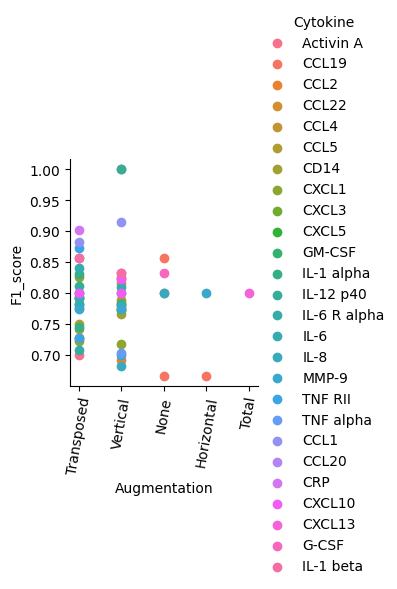

In [18]:
# All cytokines, bar chart with augmentation on x axis
# color is cyotkine

import seaborn as sns


fg = sns.FacetGrid(data=compare_cnns, hue='Cytokine')
fg.map(plt.scatter, 'Augmentation', 'F1_score').add_legend()
fg.set_xticklabels(rotation=80)

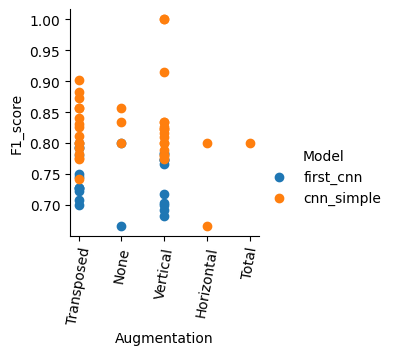

In [22]:
fg = sns.FacetGrid(data=compare_cnns, hue='Model')
fg.map(plt.scatter, 'Augmentation', 'F1_score').add_legend()
fg.set_xticklabels(rotation=80)

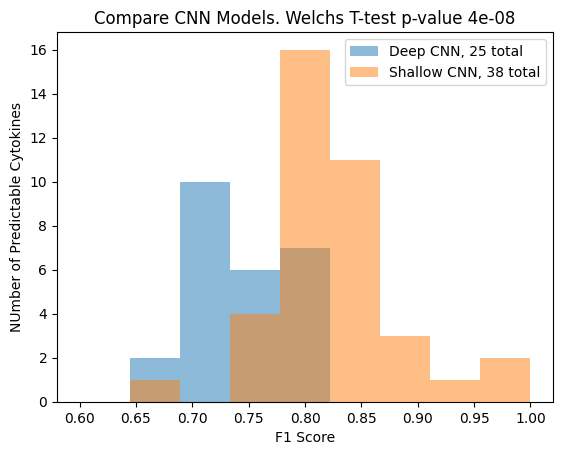

In [52]:
# I want to plot two histograms where the x axis is the F1_score and teh groups are the model types

x = compare_cnns[compare_cnns["Model"]=="first_cnn"].F1_score
y = compare_cnns[compare_cnns["Model"]=="cnn_simple"].F1_score

bins = np.linspace(0.6, 1, 10, endpoint=True)
plt.hist(x, bins, alpha=0.5, label='Deep CNN, 25 total')
plt.hist(y, bins, alpha=0.5, label='Shallow CNN, 38 total')
plt.legend(loc='upper right')
plt.title("Compare CNN Models. Welchs T-test p-value 4e-08")
plt.xlabel("F1 Score")
plt.ylabel("NUmber of Predictable Cytokines")
plt.show()

In [15]:
import scipy
from scipy import stats

# scipy.stats.ttest_ind(x, y, equal_var=False)

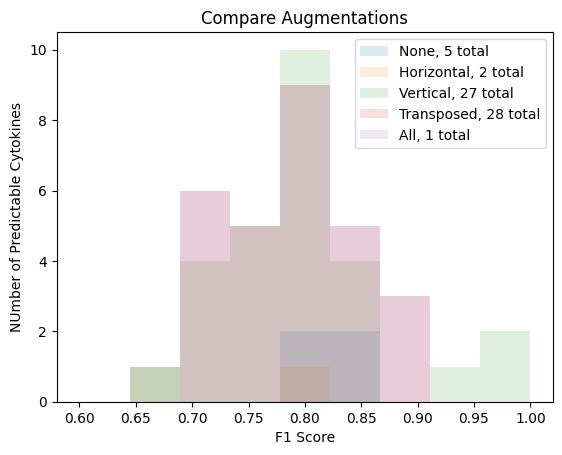

In [37]:
a = compare_cnns[compare_cnns["Augmentation"]=="None"].F1_score
b = compare_cnns[compare_cnns["Augmentation"]=="Horizontal"].F1_score
c = compare_cnns[compare_cnns["Augmentation"]=="Vertical"].F1_score
d = compare_cnns[compare_cnns["Augmentation"]=="Transposed"].F1_score
e = compare_cnns[compare_cnns["Augmentation"]=="Total"].F1_score



bins = np.linspace(0.6, 1, 10, endpoint=True)
plt.hist(a, bins, alpha=0.15, label='None, 5 total')
plt.hist(b, bins, alpha=0.15, label='Horizontal, 2 total')
plt.hist(c, bins, alpha=0.15, label='Vertical, 27 total')
plt.hist(d, bins, alpha=0.15, label='Transposed, 28 total')
plt.hist(d, bins, alpha=0.15, label='All, 1 total')
plt.legend(loc='upper right')
plt.title("Compare Augmentations")
plt.xlabel("F1 Score")
plt.ylabel("NUmber of Predictable Cytokines")
plt.show()

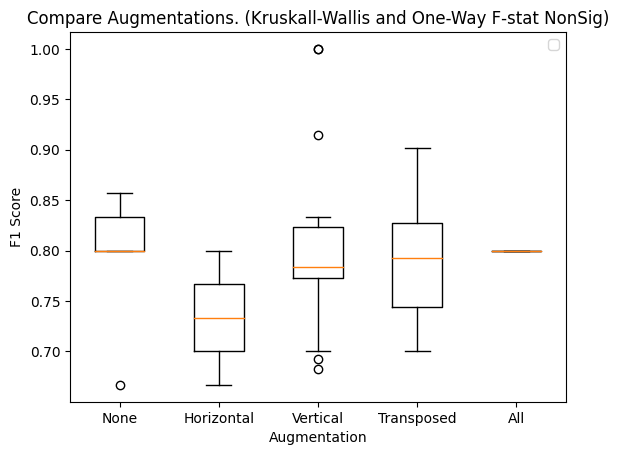

In [40]:
my_dict = {'None': compare_cnns[compare_cnns["Augmentation"]=="None"].F1_score, 'Horizontal': compare_cnns[compare_cnns["Augmentation"]=="Horizontal"].F1_score,
           'Vertical' : compare_cnns[compare_cnns["Augmentation"]=="Vertical"].F1_score,
           'Transposed' : compare_cnns[compare_cnns["Augmentation"]=="Transposed"].F1_score,
           'All' : compare_cnns[compare_cnns["Augmentation"]=="Total"].F1_score}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.legend(loc='upper right')
plt.title("Compare Augmentations. (Kruskall-Wallis and One-Way F-stat NonSig)")
plt.xlabel("Augmentation")
plt.ylabel("F1 Score")
plt.show()

In [33]:
stats.kruskal(a,b,c,d,e)

KruskalResult(statistic=1.4004016930911056, pvalue=0.8441251972314925)

In [36]:

stats.f_oneway(a,b,c,d,e)

F_onewayResult(statistic=0.44052397264525583, pvalue=0.7787953613985596)

In [44]:
# !pip install pingouin
import pingouin as pg

pg.welch_anova(dv='F1_score', between='Augmentation', data=compare_cnns)

Source  ddof1     ddof2         F     p-unc       np2
0  Augmentation      4  6.585649  0.188104  0.936764  0.029485

In [ ]:
#This codeblock was just for jotting down notes for writing the summary intro



# len(compare_cnns[compare_cnns["Model"]=="cnn_simple"].Cytokine.unique())
# compare_cnns[compare_cnns["Model"]=="cnn_simple"].Cytokine.unique()

# #Activin-A, CCL1, CCL19, CCL20, CD14, CRP, G-CSF, IL-1 beta, IL- alpha

# #Not IL-16


# (compare_cnns[compare_cnns["Model"]=="cnn_simple"].Precision.mean()+
# compare_cnns[compare_cnns["Model"]=="cnn_simple"].Recall.mean())/2

# len(compare_cnns[compare_cnns["Model"]=="cnn_simple"].Cytokine)

# len(compare_cnns[compare_cnns["Model"]=="first_cnn"].Cytokine.unique())

# (compare_cnns[compare_cnns["Model"]=="first_cnn"].Precision.mean()+
# compare_cnns[compare_cnns["Model"]=="first_cnn"].Recall.mean())/2

# len(compare_cnns[compare_cnns["Model"]=="first_cnn"].Cytokine)




# print(len(compare_cnns[compare_cnns["Augmentation"]=="None"].F1_score))
# print(len(compare_cnns[compare_cnns["Augmentation"]=="Horizontal"].F1_score))
# print(len(compare_cnns[compare_cnns["Augmentation"]=="Vertical"].F1_score))
# print(len(compare_cnns[compare_cnns["Augmentation"]=="Transposed"].F1_score))
# print(len(compare_cnns[compare_cnns["Augmentation"]=="Total"].F1_score))

# Now use a visual transformer

# Install necessary packages

In [16]:
!pip install tensorflow_addons
!pip install vit-keras
from vit_keras import vit, utils

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Include this code to create more visually appealing confusion matrices

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

def confusio_matrix(y_test, preds, target):
  cm = confusion_matrix(y_test, preds)
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos
  recall = (cm[1][1])/(cm[1][1] + cm[1][0])  #TruePositives / (TruePositives + FalseNegatives)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]

  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()
  print(target, "precision", "=", precision,"recall", "=", recall)
  return precision, recall


#Fit a visual transformer on each cytokine, get predictions, and show confusion matrices.

#Do this for the dataset which includes all augmentations and the original images

#Trying to give the ViT the best chance and receive the most data



In [18]:
#Load up the ViT

vit_model = vit.vit_b32(
image_size = 64,
activation = 'max',
pretrained = True,
include_top = False,
pretrained_top = False,
classes = 2)


vit_model.trainable = False
#^this ensures we don't train the bottom (general object detection) of the ViT -
#we only want to train the top few layers which we will add below.

#observe model with head on:

# vit_model = vit.vit_b32(
# image_size = 64,
# # activation = 'max',
# pretrained = True,
# include_top = True,
# pretrained_top = True,
# classes = 2)

# vit_model.trainable = False

#head is just one layer for this model


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 2, 2
  warnings.warn(


In [85]:
vit_model.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 embedding (Conv2D)          (None, 2, 2, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 4, 768)            0         
                                                                 
 class_token (ClassToken)    (None, 5, 768)            768       
                                                                 
 Transformer/posembed_input  (None, 5, 768)            3840      
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 5, 768),          7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [19]:
  from keras.layers import LeakyReLU

  # model_list = []
  # model_list.append(vit_model)
  vitmodel = tf.keras.Sequential(vit_model,name='ViT')

  #you can then add layers
  vitmodel.add(tf.keras.layers.Dense(256))
  vitmodel.add(LeakyReLU(alpha=0.2))

  vitmodel.add(tf.keras.layers.Dense(128))
  vitmodel.add(LeakyReLU(alpha=0.2))

  vitmodel.add(tf.keras.layers.Dense(64))
  vitmodel.add(LeakyReLU(alpha=0.2))

  vitmodel.add(tf.keras.layers.Dense(32))
  vitmodel.add(LeakyReLU(alpha=0.2))

  # model_list.append(tf.keras.layers.Dense(256, activation = 'relu'))

  # model_list.append(tf.keras.layers.Dense(128, activation = 'relu'))

  # model_list.append(tf.keras.layers.Dense(64, activation = 'relu'))

  # model_list.append(tf.keras.layers.Dense(32, activation = 'relu'))
  #final layer
  # model_list.append(tf.keras.layers.Dense(1, activation = 'softmax'))

  vitmodel.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  #then

  vitmodel.summary()

Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0       

features 376
target 376
(76, 64, 64, 3)
(300, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 17s 1s/step - loss: 4.7622 - val_loss: 5.5543
Epoch 2/10
10/10 [==============================] - 7s 685ms/step - loss: 4.7514 - val_loss: 5.5543
Epoch 3/10
10/10 [==============================] - 8s 811ms/step - loss: 4.7433 - val_loss: 5.5543
Epoch 4/10
10/10 [==============================] - 8s 816ms/step - loss: 4.7408 - val_loss: 5.5543
Epoch 5/10
10/10 [==============================] - 8s 814ms/step - loss: 4.7470 - val_loss: 5.5543
Epoch 6/10
10/10 [==============================] - 8s 812ms/step - loss: 4.7538 - val_loss: 5.5543
Epoch 7/10
10/10 [==============================] - 7s 671ms/step - loss: 4.7476 - val_loss: 5.5543
Epoch 8/10
10/10 [==============================] - 9s 993ms/step - loss: 4.7360 - val_loss: 5.5543
Epoch 9/10
10/10 [==============================] - 7s 673ms/step - loss: 4.7402 - val_loss: 5.5543
Epoch 10/10
1/1 [============================

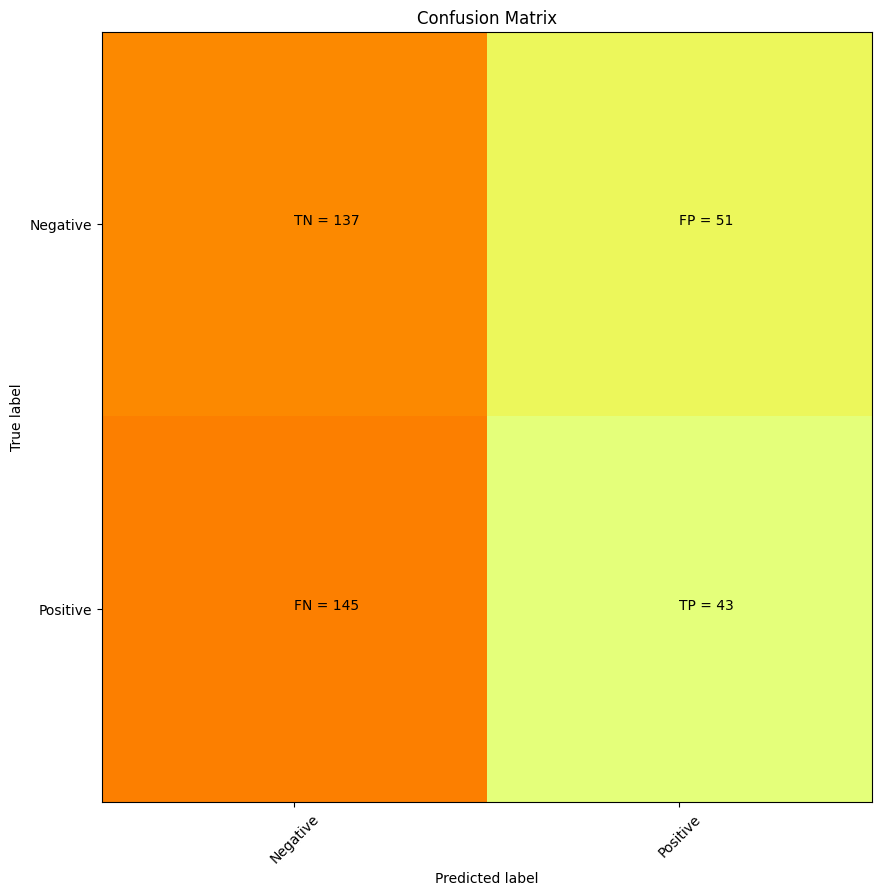

['All', 'Activin A'] precision = 0.4574468085106383 recall = 0.22872340425531915
features 368
target 368
(74, 64, 64, 3)
(294, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 4.8455

KeyboardInterrupt: ignored

In [56]:

# from keras.layers import LeakyReLU

totalresultsvit = []


for df in longdfs:
  indices = list(df.index.values)
  features = []

  for i in indices:
    thing = total_scaled_arrays[i]
    features.append(thing)
    thing2 = total_scaled_arrays[i+384]
    features.append(thing2)
    thing3 = total_scaled_arrays[i+384+384]
    features.append(thing3)
    thing4 = total_scaled_arrays[i+384+384+384]
    features.append(thing4)


  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]
  #this is 2 arrays
  #put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.2)


  #reshaping gray scale images so that we can use the RGB transformer

  for i in range(len(X_test)):
    X_test[i] = np.stack((X_test[i],)*3, axis=-1)
    X_test[i] = np.squeeze(X_test[i])

  for i in range(len(X_train)):
    X_train[i] = np.stack((X_train[i],)*3, axis=-1)
    X_train[i] = np.squeeze(X_train[i])


  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  print(test_images.shape)
  print(train_images.shape)

#get a model for each cytokine

  # vitmodel_temp = tf.keras.models.clone_model(vitmodel)

#cant figure out how to clone this one, don't think this will work???? (ie, it will keep training instead of reverting back to default and starting over)
  vitmodel_temp = vit_model

  vitmodel_temp.compile(optimizer='adam', loss='binary_crossentropy')


  vitmodel_temp.fit(train_images, train_labels, epochs=10,
            validation_data=(test_images, test_labels), batch_size=30)

#get predictions

  preds = []
  for i in range(len(features)):
    single = features[i]
    single = np.stack((single,)*3, axis=-1)
    single = np.squeeze(single)
    single = np.expand_dims(single, axis=0)
    preds.append(vitmodel_temp.predict(single))
  preds

  #this part of the code has changed slightly to accomodate the new single number output
  answer = []
  for i in range(len(preds)):
    if preds[i][0][0]<=0.5:
      answer.append(0)
    else:
      answer.append(1)
  answer

  precision, recall = confusio_matrix(target2final,answer, ['All',df.columns[0]])

  f1_score = 2*(precision*recall)/(precision+recall)

  totalresultsvit.append([df.columns[0],precision, recall, f1_score])

#summarize metrics

summarizer_totalvit = pd.DataFrame(columns =["Cytokine", "Precision", "Recall", "F1 Score", "Augmentation"])

for i in range(len(totalresultsvit)):
  f1_score = totalresultsvit[i][3]
  precision = totalresultsvit[i][1]
  recall = totalresultsvit[i][2]
  cytokine = totalresultsvit[i][0]
  augmentation = "All"
  tracking = [cytokine, precision, recall, f1_score, augmentation]
  summarizer_totalvit.loc[len(summarizer_totalvit.index)] = tracking

summarizer_totalvit

In [ ]:
summarizer_totalvit

Cytokine  Precision    Recall  F1 Score Augmentation
0      Activin A   0.457447  0.228723  0.304965          All
1           CCL1   0.511628  0.358696  0.421725          All
2          CCL19   0.470588  0.333333  0.390244          All
3           CCL2   0.453202  0.242105  0.315609          All
4          CCL20   0.590164  0.300000  0.397790          All
5          CCL22   0.532203  0.314000  0.394969          All
6           CCL4   0.391304  0.244565  0.301003          All
7           CCL5   0.488136  0.270677  0.348247          All
8           CD14   0.576687  0.385246  0.461916          All
9            CRP   0.481865  0.270349  0.346369          All
10         CXCL1   0.396694  0.279070  0.327645          All
11        CXCL10   0.575758  0.279412  0.376238          All
12        CXCL13   0.466667  0.250000  0.325581          All
13         CXCL3   0.494624  0.264368  0.344569          All
14         CXCL5   0.437500  0.258197  0.324742          All
15         G-CSF   0.640000  0.200000  0.304762          All
16        GM-CSF   0.440000  0.343750  0.385965          All
17    IL-1 alpha   0.436364  0.218182  0.290909          All
18     IL-1 beta   0.478873  0.283333  0.356021          All
19     IL-12 p40   0.750000  0.277778  0.405405          All
20         IL-16   0.627451  0.380952  0.474074          All
21  IL-6 R alpha   0.524691  0.312500  0.391705          All
22          IL-6   0.484127  0.284161  0.358121          All
23          IL-8   0.552381  0.329545  0.412811          All
24         MMP-9   0.281250  0.155172  0.200000          All
25       TNF RII   0.597633  0.290230  0.390716          All
26     TNF alpha   0.464286  0.262097  0.335052          All

In [ ]:
pvit1 = summarizer_totalvit[summarizer_totalvit["Precision"]>0.65]
pvit1

Cytokine  Precision    Recall  F1 Score Augmentation
19  IL-12 p40       0.75  0.277778  0.405405          All

None! No cytokines come up as predictable  (Precision and recall >0.65) with the visual transformer!

We need more optimization - a much larger dataset. You can't just assume that using a visual transformer will improve your results!

# Try a bigger ViT (goal is 519,000)

In [ ]:
  # model_list = []
  # model_list.append(vit_model)
  vitmodel = tf.keras.Sequential(vit_model,name='ViT')

  vitmodel.add(tf.keras.layers.Dense(512))
  vitmodel.add(LeakyReLU(alpha=0.2))
  vitmodel.add(tf.keras.layers.Dense(256))
  vitmodel.add(LeakyReLU(alpha=0.2))
  vitmodel.add(tf.keras.layers.Dense(128))
  vitmodel.add(LeakyReLU(alpha=0.2))
  vitmodel.add(tf.keras.layers.Dense(64))
  vitmodel.add(LeakyReLU(alpha=0.2))
  vitmodel.add(tf.keras.layers.Dense(32))
  vitmodel.add(LeakyReLU(alpha=0.2))


  vitmodel.add(tf.keras.layers.Dense(1, activation="sigmoid"))


In [22]:
  # model_list = []
  # model_list.append(vit_model)
  vitmodel = tf.keras.Sequential(vit_model,name='ViT')

  #you can then add layers

  vitmodel.add(tf.keras.layers.Dense(512))
  vitmodel.add(LeakyReLU(alpha=0.2))

  vitmodel.add(tf.keras.layers.Dense(256))
  vitmodel.add(LeakyReLU(alpha=0.2))

  # vitmodel.add(tf.keras.layers.Dense(256))
  # vitmodel.add(LeakyReLU(alpha=0.2))

  vitmodel.add(tf.keras.layers.Dense(128))
  vitmodel.add(LeakyReLU(alpha=0.2))

  # vitmodel.add(tf.keras.layers.Dense(128))
  # vitmodel.add(LeakyReLU(alpha=0.2))

  vitmodel.add(tf.keras.layers.Dense(64))
  vitmodel.add(LeakyReLU(alpha=0.2))

  vitmodel.add(tf.keras.layers.Dense(32))
  vitmodel.add(LeakyReLU(alpha=0.2))

  # model_list.append(tf.keras.layers.Dense(256, activation = 'relu'))

  # model_list.append(tf.keras.layers.Dense(128, activation = 'relu'))

  # model_list.append(tf.keras.layers.Dense(64, activation = 'relu'))

  # model_list.append(tf.keras.layers.Dense(32, activation = 'relu'))
  #final layer
  # model_list.append(tf.keras.layers.Dense(1, activation = 'softmax'))

  vitmodel.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  #then

  vitmodel.summary()

Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_18 (Dense)            (None, 512)               393728    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 128)               0       

features 376
target 376
(76, 64, 64, 3)
(300, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 19s 746ms/step - loss: 0.6490 - val_loss: 0.7114
Epoch 2/10
10/10 [==============================] - 5s 523ms/step - loss: 0.6443 - val_loss: 0.7562
Epoch 3/10
10/10 [==============================] - 5s 469ms/step - loss: 0.6634 - val_loss: 0.6724
Epoch 4/10
10/10 [==============================] - 5s 473ms/step - loss: 0.6403 - val_loss: 0.7106
Epoch 5/10
10/10 [==============================] - 5s 538ms/step - loss: 0.6351 - val_loss: 0.7979
Epoch 6/10
10/10 [==============================] - 5s 481ms/step - loss: 0.6471 - val_loss: 0.6767
Epoch 7/10
10/10 [==============================] - 5s 543ms/step - loss: 0.6453 - val_loss: 0.6665
Epoch 8/10
10/10 [==============================] - 5s 475ms/step - loss: 0.6538 - val_loss: 0.6823
Epoch 9/10
10/10 [==============================] - 5s 475ms/step - loss: 0.6429 - val_loss: 0.6855
Epoch 10/10
1/1 [=========================

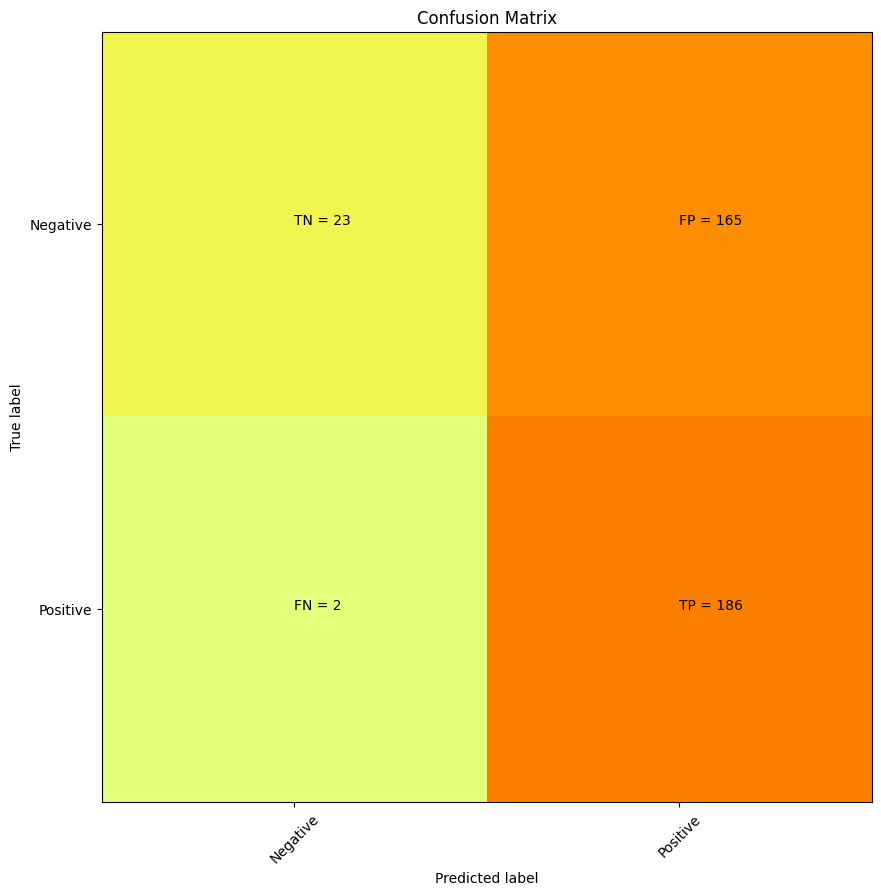

['All', 'Activin A'] precision = 0.5299145299145299 recall = 0.9893617021276596
features 368
target 368
(74, 64, 64, 3)
(294, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 18s 762ms/step - loss: 0.7618 - val_loss: 0.7073
Epoch 2/10
10/10 [==============================] - 6s 552ms/step - loss: 0.7015 - val_loss: 0.7092
Epoch 3/10
10/10 [==============================] - 5s 491ms/step - loss: 0.7009 - val_loss: 0.6902
Epoch 4/10
10/10 [==============================] - 5s 550ms/step - loss: 0.6929 - val_loss: 0.6887
Epoch 5/10
10/10 [==============================] - 5s 492ms/step - loss: 0.6920 - val_loss: 0.7199
Epoch 6/10
10/10 [==============================] - 5s 550ms/step - loss: 0.7091 - val_loss: 0.6944
Epoch 7/10
10/10 [==============================] - 5s 534ms/step - loss: 0.6943 - val_loss: 0.6989
Epoch 8/10
10/10 [==============================] - 5s 516ms/step - loss: 0.6900 - val_loss: 0.6948
Epoch 9/10
10/10 [==============================] - 5s 504ms/s

['All', 'CCL1'] precision = 0.5901639344262295 recall = 0.5869565217391305
features 96
target 96
(20, 64, 64, 3)
(76, 64, 64, 3)
Epoch 1/10
3/3 [==============================] - 15s 2s/step - loss: 0.7337 - val_loss: 0.7032
Epoch 2/10
3/3 [==============================] - 1s 485ms/step - loss: 0.6943 - val_loss: 0.6770
Epoch 3/10
3/3 [==============================] - 1s 442ms/step - loss: 0.6739 - val_loss: 0.6724
Epoch 4/10
3/3 [==============================] - 1s 454ms/step - loss: 0.6573 - val_loss: 0.6786
Epoch 5/10
3/3 [==============================] - 1s 448ms/step - loss: 0.6392 - val_loss: 0.6649
Epoch 6/10
3/3 [==============================] - 1s 453ms/step - loss: 0.6376 - val_loss: 0.6468
Epoch 7/10
3/3 [==============================] - 1s 477ms/step - loss: 0.6508 - val_loss: 0.6740
Epoch 8/10
3/3 [==============================] - 1s 449ms/step - loss: 0.6832 - val_loss: 0.6896
Epoch 9/10
3/3 [==============================] - 2s 769ms/step - loss: 0.6376 - val_loss

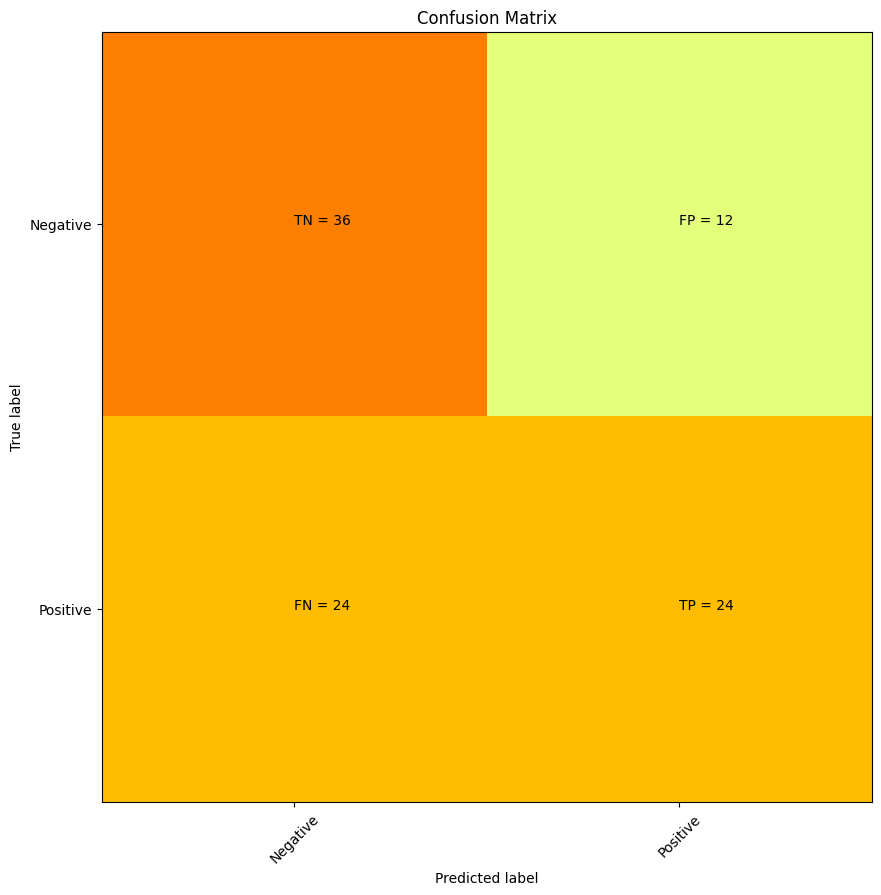

['All', 'CCL19'] precision = 0.6666666666666666 recall = 0.5
features 760
target 760
(152, 64, 64, 3)
(608, 64, 64, 3)
Epoch 1/10
21/21 [==============================] - 24s 609ms/step - loss: 0.7277 - val_loss: 0.6893
Epoch 2/10
21/21 [==============================] - 10s 504ms/step - loss: 0.6987 - val_loss: 0.6923
Epoch 3/10
21/21 [==============================] - 11s 518ms/step - loss: 0.6974 - val_loss: 0.6962
Epoch 4/10
21/21 [==============================] - 11s 516ms/step - loss: 0.6986 - val_loss: 0.6868
Epoch 5/10
21/21 [==============================] - 10s 474ms/step - loss: 0.6949 - val_loss: 0.6866
Epoch 6/10
21/21 [==============================] - 11s 542ms/step - loss: 0.6930 - val_loss: 0.6872
Epoch 7/10
21/21 [==============================] - 10s 503ms/step - loss: 0.6968 - val_loss: 0.6988
Epoch 8/10
21/21 [==============================] - 10s 505ms/step - loss: 0.6917 - val_loss: 0.6859
Epoch 9/10
21/21 [==============================] - 10s 503ms/step - loss

['All', 'CCL2'] precision = 0.5398550724637681 recall = 0.39210526315789473
features 240
target 240
(48, 64, 64, 3)
(192, 64, 64, 3)
Epoch 1/10
7/7 [==============================] - 17s 838ms/step - loss: 0.7054 - val_loss: 0.6804
Epoch 2/10
7/7 [==============================] - 3s 514ms/step - loss: 0.6932 - val_loss: 0.6779
Epoch 3/10
7/7 [==============================] - 3s 477ms/step - loss: 0.6978 - val_loss: 0.6745
Epoch 4/10
7/7 [==============================] - 3s 460ms/step - loss: 0.6974 - val_loss: 0.6816
Epoch 5/10
7/7 [==============================] - 3s 461ms/step - loss: 0.7008 - val_loss: 0.6430
Epoch 6/10
7/7 [==============================] - 4s 558ms/step - loss: 0.6877 - val_loss: 0.6384
Epoch 7/10
7/7 [==============================] - 3s 459ms/step - loss: 0.6754 - val_loss: 0.6157
Epoch 8/10
7/7 [==============================] - 3s 465ms/step - loss: 0.6597 - val_loss: 0.6068
Epoch 9/10
7/7 [==============================] - 3s 475ms/step - loss: 0.6638 - v

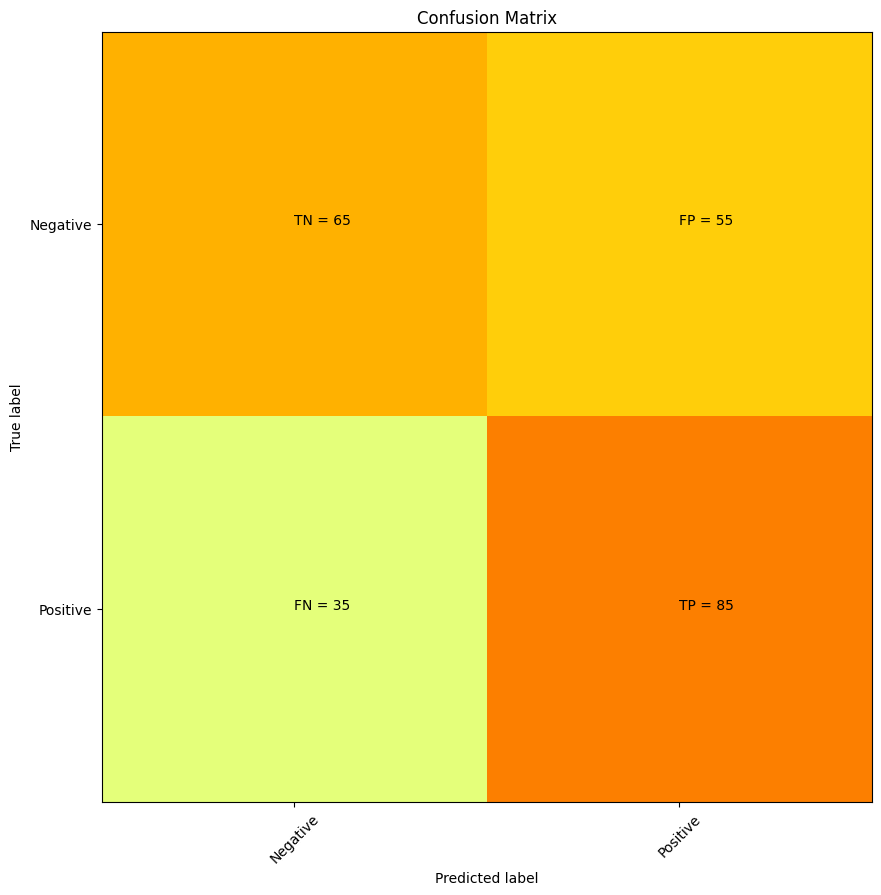

['All', 'CCL20'] precision = 0.6071428571428571 recall = 0.7083333333333334
features 1000
target 1000
(200, 64, 64, 3)
(800, 64, 64, 3)
Epoch 1/10
27/27 [==============================] - 27s 591ms/step - loss: 0.7232 - val_loss: 0.7107
Epoch 2/10
27/27 [==============================] - 14s 505ms/step - loss: 0.7002 - val_loss: 0.6952
Epoch 3/10
27/27 [==============================] - 14s 520ms/step - loss: 0.6965 - val_loss: 0.6933
Epoch 4/10
27/27 [==============================] - 16s 601ms/step - loss: 0.7023 - val_loss: 0.6933
Epoch 5/10
27/27 [==============================] - 14s 508ms/step - loss: 0.6911 - val_loss: 0.6893
Epoch 6/10
27/27 [==============================] - 14s 507ms/step - loss: 0.6967 - val_loss: 0.6901
Epoch 7/10
27/27 [==============================] - 14s 508ms/step - loss: 0.6913 - val_loss: 0.7050
Epoch 8/10
27/27 [==============================] - 14s 516ms/step - loss: 0.6997 - val_loss: 0.6915
Epoch 9/10
27/27 [==============================] - 14s 

['All', 'CCL22'] precision = 0.5954415954415955 recall = 0.418
features 368
target 368
(74, 64, 64, 3)
(294, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 18s 795ms/step - loss: 0.7074 - val_loss: 0.6948
Epoch 2/10
10/10 [==============================] - 5s 497ms/step - loss: 0.6858 - val_loss: 0.6981
Epoch 3/10
10/10 [==============================] - 5s 489ms/step - loss: 0.6760 - val_loss: 0.6832
Epoch 4/10
10/10 [==============================] - 5s 554ms/step - loss: 0.6725 - val_loss: 0.6602
Epoch 5/10
10/10 [==============================] - 5s 491ms/step - loss: 0.6828 - val_loss: 0.6704
Epoch 6/10
10/10 [==============================] - 5s 552ms/step - loss: 0.6739 - val_loss: 0.6830
Epoch 7/10
10/10 [==============================] - 5s 490ms/step - loss: 0.6694 - val_loss: 0.6678
Epoch 8/10
10/10 [==============================] - 5s 537ms/step - loss: 0.6712 - val_loss: 0.6658
Epoch 9/10
10/10 [==============================] - 5s 500ms/step - loss: 0.664

['All', 'CCL4'] precision = 0.7169811320754716 recall = 0.20652173913043478
features 1064
target 1064
(213, 64, 64, 3)
(851, 64, 64, 3)
Epoch 1/10
29/29 [==============================] - 29s 609ms/step - loss: 0.7039 - val_loss: 0.6883
Epoch 2/10
29/29 [==============================] - 15s 508ms/step - loss: 0.6853 - val_loss: 0.7207
Epoch 3/10
29/29 [==============================] - 15s 515ms/step - loss: 0.6870 - val_loss: 0.7022
Epoch 4/10
29/29 [==============================] - 15s 504ms/step - loss: 0.6790 - val_loss: 0.6776
Epoch 5/10
29/29 [==============================] - 14s 502ms/step - loss: 0.6817 - val_loss: 0.6969
Epoch 6/10
29/29 [==============================] - 15s 506ms/step - loss: 0.6780 - val_loss: 0.6994
Epoch 7/10
29/29 [==============================] - 17s 595ms/step - loss: 0.6794 - val_loss: 0.6886
Epoch 8/10
29/29 [==============================] - 14s 502ms/step - loss: 0.6753 - val_loss: 0.6775
Epoch 9/10
29/29 [==============================] - 15s 

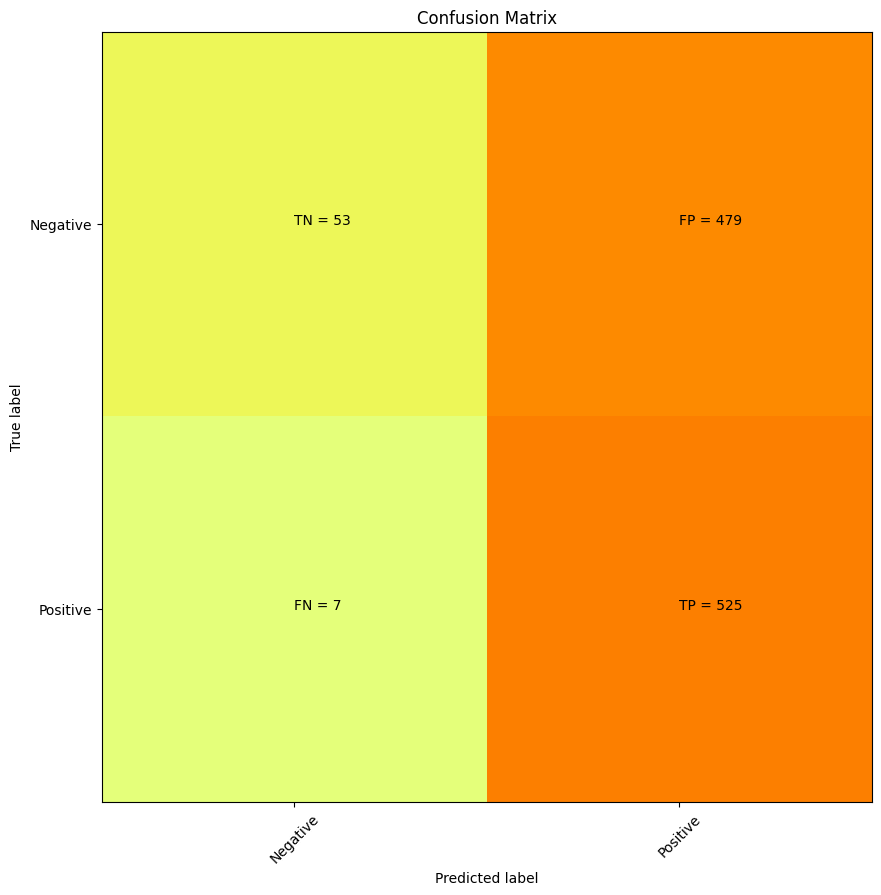

['All', 'CCL5'] precision = 0.5229083665338645 recall = 0.9868421052631579
features 488
target 488
(98, 64, 64, 3)
(390, 64, 64, 3)
Epoch 1/10
13/13 [==============================] - 15s 716ms/step - loss: 0.7267 - val_loss: 0.6884
Epoch 2/10
13/13 [==============================] - 7s 523ms/step - loss: 0.6890 - val_loss: 0.6863
Epoch 3/10
13/13 [==============================] - 6s 475ms/step - loss: 0.6911 - val_loss: 0.6854
Epoch 4/10
13/13 [==============================] - 7s 521ms/step - loss: 0.6901 - val_loss: 0.6835
Epoch 5/10
13/13 [==============================] - 6s 477ms/step - loss: 0.7044 - val_loss: 0.6882
Epoch 6/10
13/13 [==============================] - 7s 525ms/step - loss: 0.6878 - val_loss: 0.7110
Epoch 7/10
13/13 [==============================] - 6s 472ms/step - loss: 0.6859 - val_loss: 0.6806
Epoch 8/10
13/13 [==============================] - 7s 529ms/step - loss: 0.6822 - val_loss: 0.6688
Epoch 9/10
13/13 [==============================] - 6s 481ms/step -

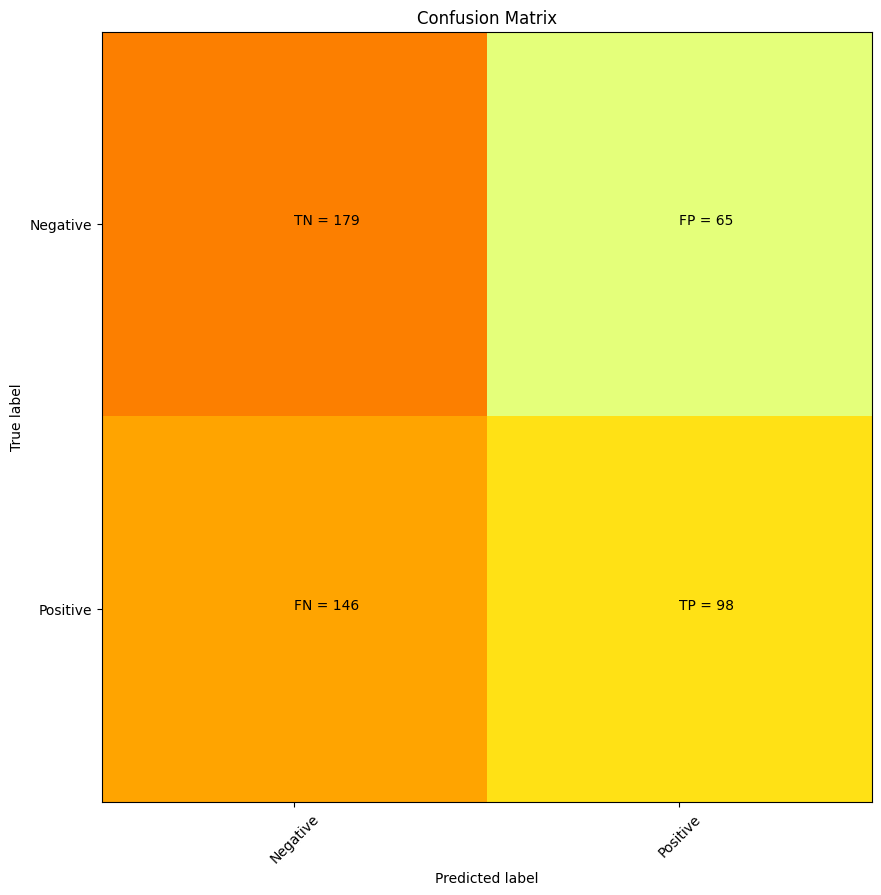

['All', 'CD14'] precision = 0.6012269938650306 recall = 0.4016393442622951
features 688
target 688
(138, 64, 64, 3)
(550, 64, 64, 3)
Epoch 1/10
19/19 [==============================] - 22s 635ms/step - loss: 0.7051 - val_loss: 0.6848
Epoch 2/10
19/19 [==============================] - 10s 511ms/step - loss: 0.6981 - val_loss: 0.7097
Epoch 3/10
19/19 [==============================] - 9s 479ms/step - loss: 0.6867 - val_loss: 0.6768
Epoch 4/10
19/19 [==============================] - 10s 499ms/step - loss: 0.6890 - val_loss: 0.6829
Epoch 5/10
19/19 [==============================] - 10s 508ms/step - loss: 0.6838 - val_loss: 0.6728
Epoch 6/10
19/19 [==============================] - 10s 511ms/step - loss: 0.6821 - val_loss: 0.6960
Epoch 7/10
19/19 [==============================] - 10s 532ms/step - loss: 0.6836 - val_loss: 0.6864
Epoch 8/10
19/19 [==============================] - 9s 482ms/step - loss: 0.6765 - val_loss: 0.6811
Epoch 9/10
19/19 [==============================] - 10s 513ms

['All', 'CRP'] precision = 0.5380434782608695 recall = 0.8633720930232558
features 344
target 344
(69, 64, 64, 3)
(275, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 18s 762ms/step - loss: 0.6978 - val_loss: 0.6793
Epoch 2/10
10/10 [==============================] - 5s 476ms/step - loss: 0.6707 - val_loss: 0.7014
Epoch 3/10
10/10 [==============================] - 5s 467ms/step - loss: 0.6605 - val_loss: 0.7381
Epoch 4/10
10/10 [==============================] - 5s 538ms/step - loss: 0.6478 - val_loss: 0.7469
Epoch 5/10
10/10 [==============================] - 5s 468ms/step - loss: 0.6668 - val_loss: 0.7449
Epoch 6/10
10/10 [==============================] - 5s 534ms/step - loss: 0.6573 - val_loss: 0.7067
Epoch 7/10
10/10 [==============================] - 5s 464ms/step - loss: 0.6534 - val_loss: 0.7211
Epoch 8/10
10/10 [==============================] - 5s 472ms/step - loss: 0.6411 - val_loss: 0.7061
Epoch 9/10
10/10 [==============================] - 5s 537ms/step - 

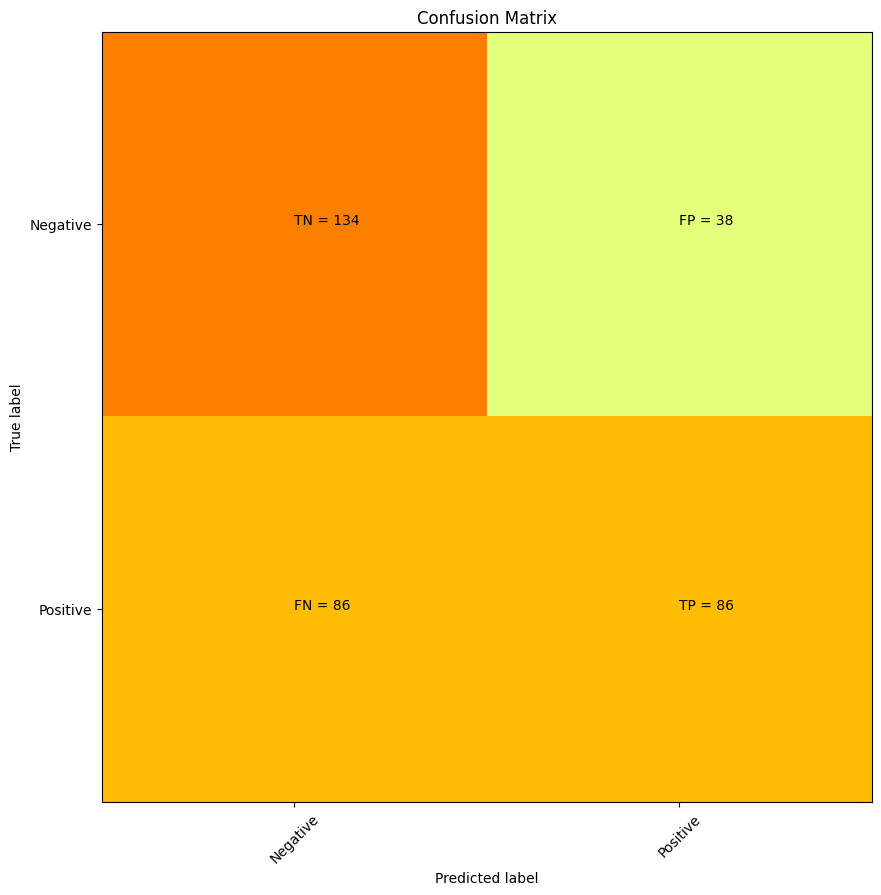

['All', 'CXCL1'] precision = 0.6935483870967742 recall = 0.5
features 136
target 136
(28, 64, 64, 3)
(108, 64, 64, 3)
Epoch 1/10
4/4 [==============================] - 15s 1s/step - loss: 0.7560 - val_loss: 0.7036
Epoch 2/10
4/4 [==============================] - 2s 576ms/step - loss: 0.6843 - val_loss: 0.6910
Epoch 3/10
4/4 [==============================] - 2s 563ms/step - loss: 0.6792 - val_loss: 0.6947
Epoch 4/10
4/4 [==============================] - 2s 477ms/step - loss: 0.6837 - val_loss: 0.7008
Epoch 5/10
4/4 [==============================] - 2s 572ms/step - loss: 0.6783 - val_loss: 0.7092
Epoch 6/10
4/4 [==============================] - 2s 470ms/step - loss: 0.6557 - val_loss: 0.7102
Epoch 7/10
4/4 [==============================] - 2s 477ms/step - loss: 0.6486 - val_loss: 0.7181
Epoch 8/10
4/4 [==============================] - 2s 575ms/step - loss: 0.6986 - val_loss: 0.6973
Epoch 9/10
4/4 [==============================] - 2s 543ms/step - loss: 0.6669 - val_loss: 0.6814
Ep

['All', 'CXCL10'] precision = 0.7777777777777778 recall = 0.3088235294117647
features 56
target 56
(12, 64, 64, 3)
(44, 64, 64, 3)
Epoch 1/10
2/2 [==============================] - 14s 3s/step - loss: 0.6515 - val_loss: 0.5915
Epoch 2/10
2/2 [==============================] - 1s 409ms/step - loss: 0.6026 - val_loss: 0.4413
Epoch 3/10
2/2 [==============================] - 1s 400ms/step - loss: 0.6468 - val_loss: 0.4202
Epoch 4/10
2/2 [==============================] - 1s 413ms/step - loss: 0.7071 - val_loss: 0.5591
Epoch 5/10
2/2 [==============================] - 1s 669ms/step - loss: 0.5891 - val_loss: 0.5638
Epoch 6/10
2/2 [==============================] - 1s 517ms/step - loss: 0.5809 - val_loss: 0.5149
Epoch 7/10
2/2 [==============================] - 1s 551ms/step - loss: 0.5699 - val_loss: 0.4688
Epoch 8/10
2/2 [==============================] - 1s 399ms/step - loss: 0.6235 - val_loss: 0.4468
Epoch 9/10
2/2 [==============================] - 1s 391ms/step - loss: 0.6460 - val_lo

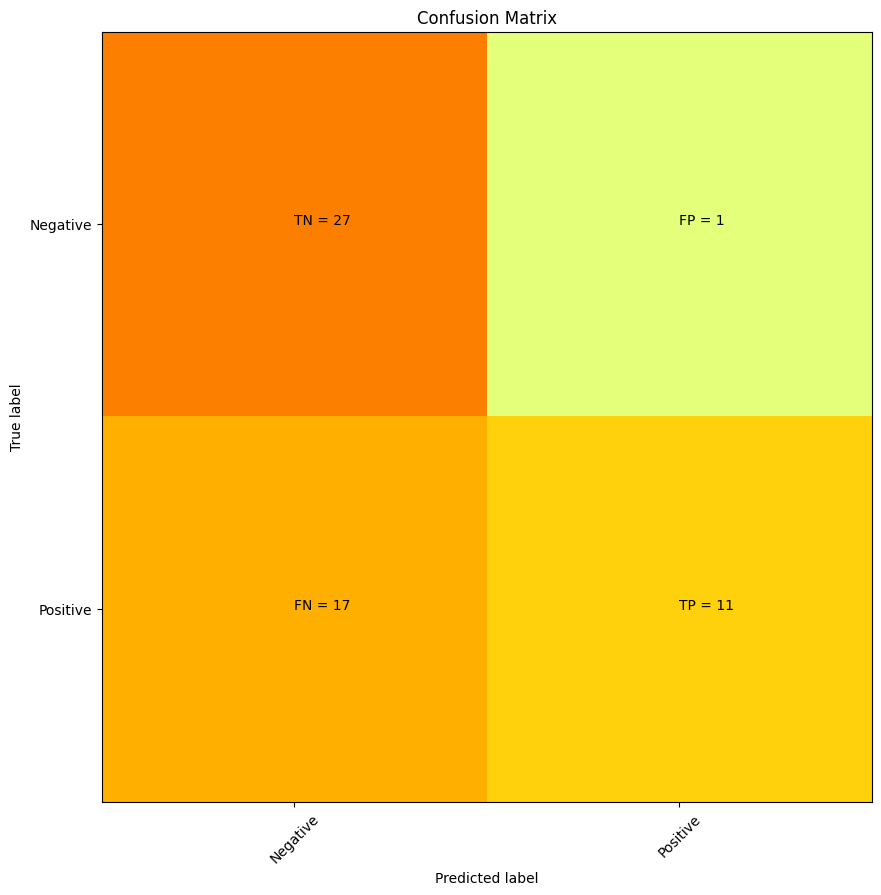

['All', 'CXCL13'] precision = 0.9166666666666666 recall = 0.39285714285714285
features 696
target 696
(140, 64, 64, 3)
(556, 64, 64, 3)
Epoch 1/10
19/19 [==============================] - 23s 651ms/step - loss: 0.6724 - val_loss: 0.6943
Epoch 2/10
19/19 [==============================] - 10s 543ms/step - loss: 0.6604 - val_loss: 0.6798
Epoch 3/10
19/19 [==============================] - 9s 488ms/step - loss: 0.6753 - val_loss: 0.6724
Epoch 4/10
19/19 [==============================] - 10s 522ms/step - loss: 0.6666 - val_loss: 0.6752
Epoch 5/10
19/19 [==============================] - 10s 519ms/step - loss: 0.6618 - val_loss: 0.6819
Epoch 6/10
19/19 [==============================] - 10s 523ms/step - loss: 0.6670 - val_loss: 0.6758
Epoch 7/10
19/19 [==============================] - 10s 522ms/step - loss: 0.6531 - val_loss: 0.6582
Epoch 8/10
19/19 [==============================] - 9s 493ms/step - loss: 0.6503 - val_loss: 0.6539
Epoch 9/10
19/19 [==============================] - 10s 52

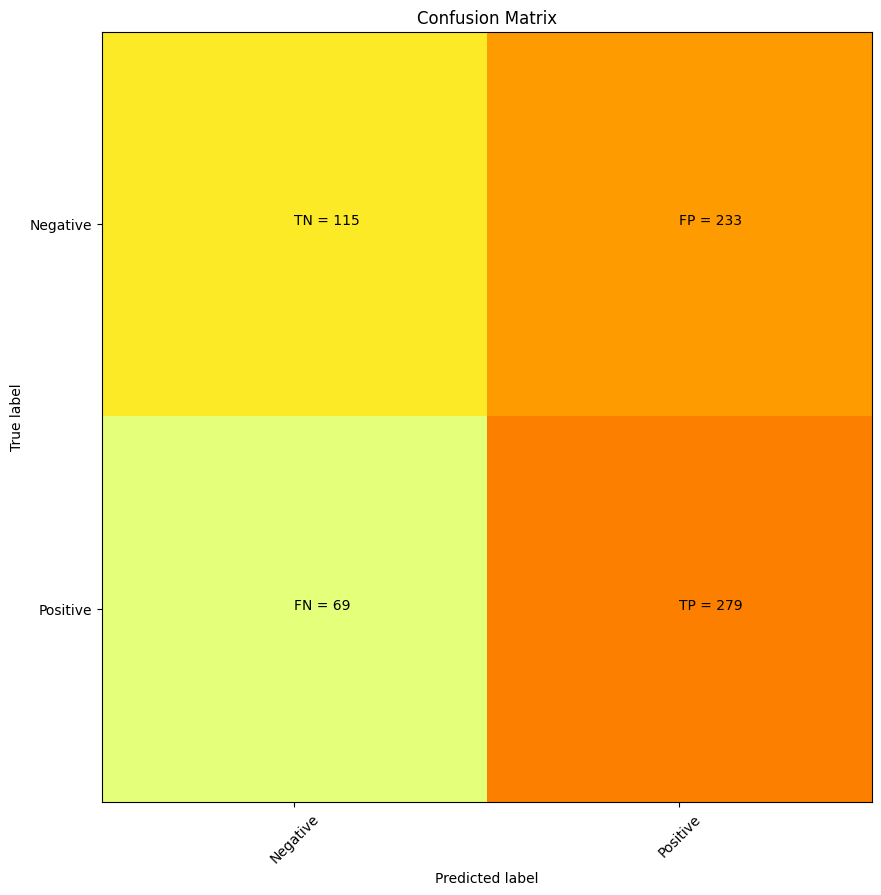

['All', 'CXCL3'] precision = 0.544921875 recall = 0.8017241379310345
features 488
target 488
(98, 64, 64, 3)
(390, 64, 64, 3)
Epoch 1/10
13/13 [==============================] - 16s 731ms/step - loss: 0.6674 - val_loss: 0.6822
Epoch 2/10
13/13 [==============================] - 6s 491ms/step - loss: 0.6831 - val_loss: 0.7408
Epoch 3/10
13/13 [==============================] - 7s 534ms/step - loss: 0.6762 - val_loss: 0.7031
Epoch 4/10
13/13 [==============================] - 6s 479ms/step - loss: 0.6683 - val_loss: 0.7128
Epoch 5/10
13/13 [==============================] - 7s 536ms/step - loss: 0.6518 - val_loss: 0.7061
Epoch 6/10
13/13 [==============================] - 6s 491ms/step - loss: 0.6654 - val_loss: 0.7395
Epoch 7/10
13/13 [==============================] - 7s 544ms/step - loss: 0.6636 - val_loss: 0.7159
Epoch 8/10
13/13 [==============================] - 7s 513ms/step - loss: 0.6464 - val_loss: 0.7288
Epoch 9/10
13/13 [==============================] - 7s 513ms/step - loss:

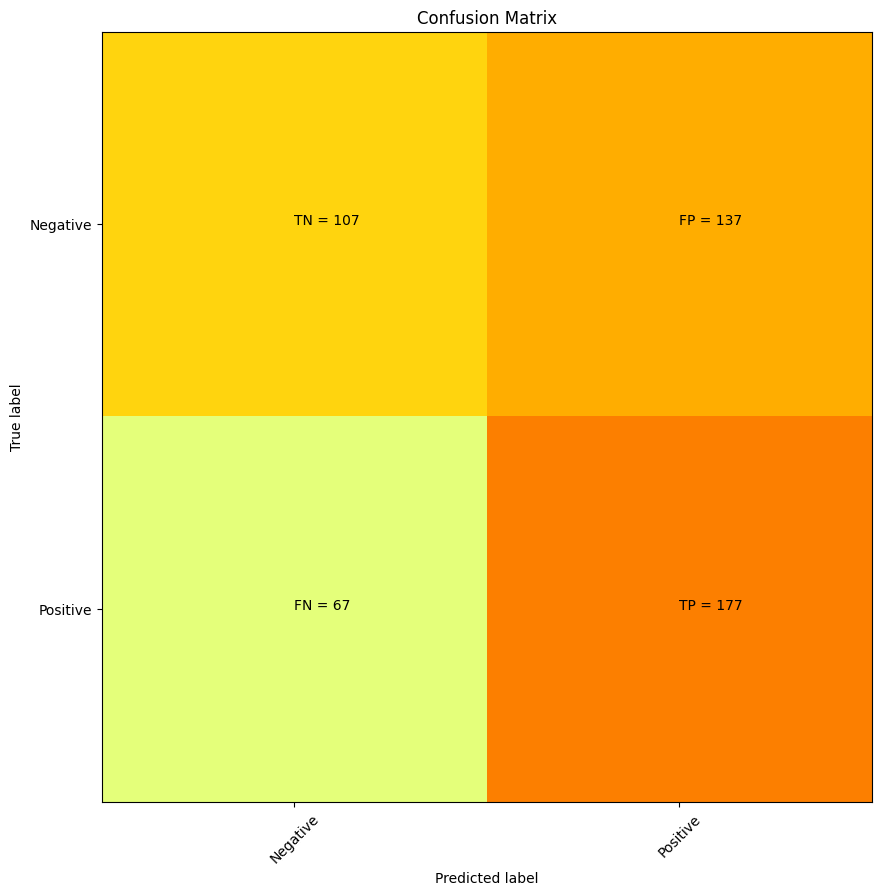

['All', 'CXCL5'] precision = 0.5636942675159236 recall = 0.7254098360655737
features 160
target 160
(32, 64, 64, 3)
(128, 64, 64, 3)
Epoch 1/10
5/5 [==============================] - 16s 1s/step - loss: 0.7004 - val_loss: 0.6899
Epoch 2/10
5/5 [==============================] - 2s 514ms/step - loss: 0.6666 - val_loss: 0.6866
Epoch 3/10
5/5 [==============================] - 2s 507ms/step - loss: 0.6509 - val_loss: 0.6909
Epoch 4/10
5/5 [==============================] - 3s 585ms/step - loss: 0.6658 - val_loss: 0.6803
Epoch 5/10
5/5 [==============================] - 2s 446ms/step - loss: 0.6577 - val_loss: 0.6852
Epoch 6/10
5/5 [==============================] - 2s 459ms/step - loss: 0.6436 - val_loss: 0.7114
Epoch 7/10
5/5 [==============================] - 2s 506ms/step - loss: 0.6474 - val_loss: 0.7109
Epoch 8/10
5/5 [==============================] - 2s 506ms/step - loss: 0.6510 - val_loss: 0.6918
Epoch 9/10
5/5 [==============================] - 3s 574ms/step - loss: 0.6426 - val_

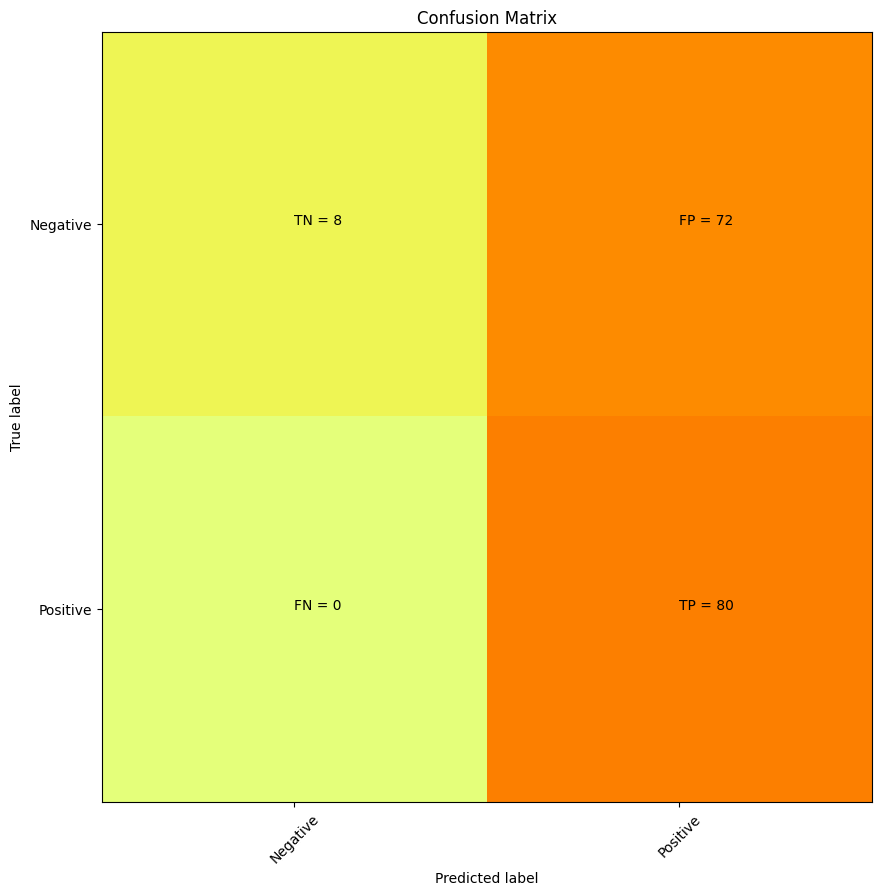

['All', 'G-CSF'] precision = 0.5263157894736842 recall = 1.0
features 64
target 64
(13, 64, 64, 3)
(51, 64, 64, 3)
Epoch 1/10
2/2 [==============================] - 15s 3s/step - loss: 0.9912 - val_loss: 0.6707
Epoch 2/10
2/2 [==============================] - 1s 494ms/step - loss: 0.7218 - val_loss: 0.6840
Epoch 3/10
2/2 [==============================] - 1s 490ms/step - loss: 0.6830 - val_loss: 0.6805
Epoch 4/10
2/2 [==============================] - 1s 626ms/step - loss: 0.6699 - val_loss: 0.6798
Epoch 5/10
2/2 [==============================] - 1s 496ms/step - loss: 0.6869 - val_loss: 0.6829
Epoch 6/10
2/2 [==============================] - 1s 639ms/step - loss: 0.6577 - val_loss: 0.6865
Epoch 7/10
2/2 [==============================] - 1s 518ms/step - loss: 0.6299 - val_loss: 0.7076
Epoch 8/10
2/2 [==============================] - 1s 493ms/step - loss: 0.6402 - val_loss: 0.7348
Epoch 9/10
2/2 [==============================] - 1s 731ms/step - loss: 0.7036 - val_loss: 0.7251
Epoch

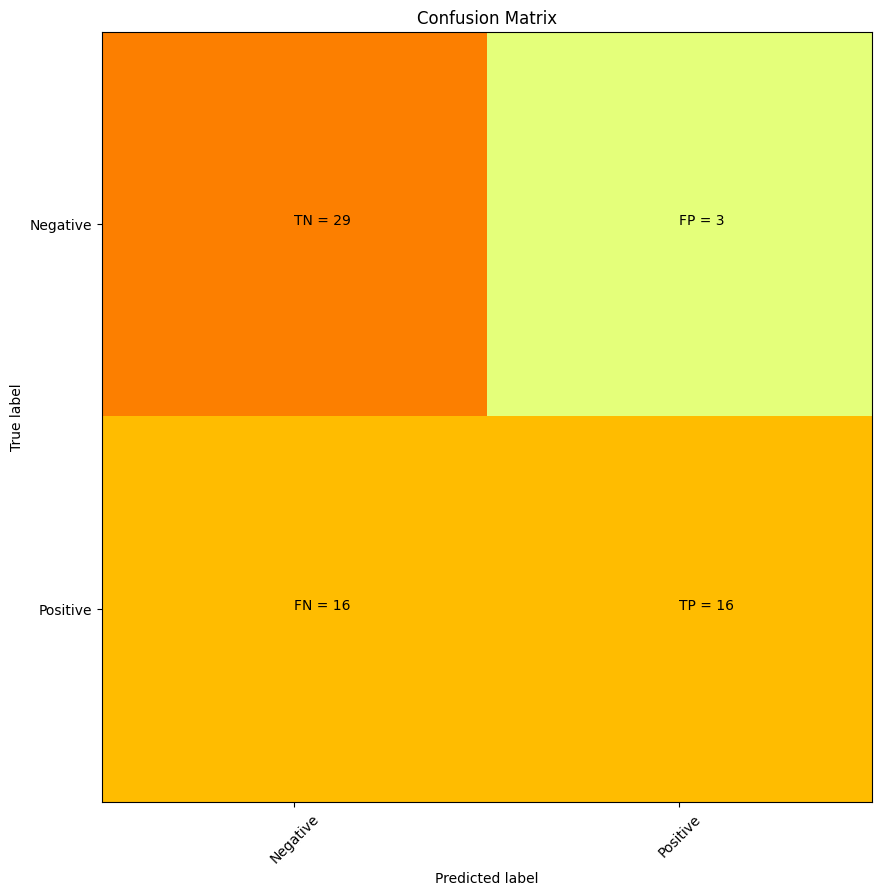

['All', 'GM-CSF'] precision = 0.8421052631578947 recall = 0.5
features 440
target 440
(88, 64, 64, 3)
(352, 64, 64, 3)
Epoch 1/10
12/12 [==============================] - 22s 755ms/step - loss: 0.7113 - val_loss: 0.6983
Epoch 2/10
12/12 [==============================] - 7s 635ms/step - loss: 0.6858 - val_loss: 0.7113
Epoch 3/10
12/12 [==============================] - 6s 490ms/step - loss: 0.6823 - val_loss: 0.7136
Epoch 4/10
12/12 [==============================] - 6s 544ms/step - loss: 0.6819 - val_loss: 0.6945
Epoch 5/10
12/12 [==============================] - 6s 494ms/step - loss: 0.6909 - val_loss: 0.7014
Epoch 6/10
12/12 [==============================] - 7s 564ms/step - loss: 0.6811 - val_loss: 0.6835
Epoch 7/10
12/12 [==============================] - 6s 518ms/step - loss: 0.6851 - val_loss: 0.7227
Epoch 8/10
12/12 [==============================] - 7s 576ms/step - loss: 0.6818 - val_loss: 0.6978
Epoch 9/10
12/12 [==============================] - 6s 526ms/step - loss: 0.6897

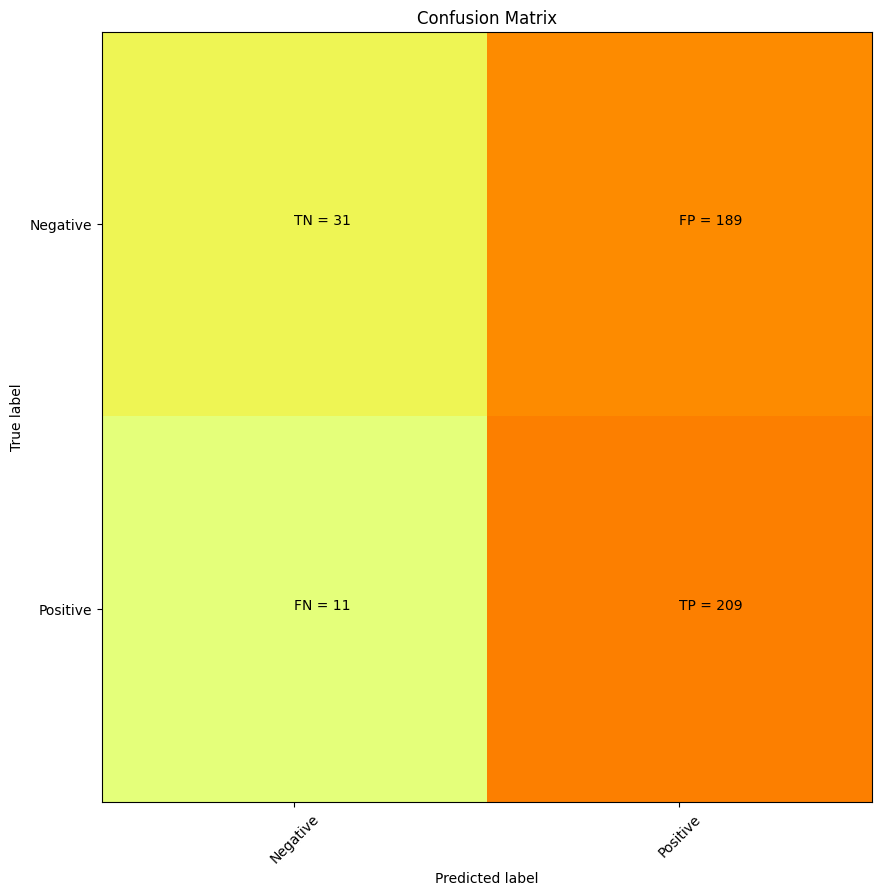

['All', 'IL-1 alpha'] precision = 0.5251256281407035 recall = 0.95
features 720
target 720
(144, 64, 64, 3)
(576, 64, 64, 3)
Epoch 1/10
20/20 [==============================] - 24s 630ms/step - loss: 0.7042 - val_loss: 0.6975
Epoch 2/10
20/20 [==============================] - 11s 547ms/step - loss: 0.6771 - val_loss: 0.6843
Epoch 3/10
20/20 [==============================] - 10s 528ms/step - loss: 0.6750 - val_loss: 0.6911
Epoch 4/10
20/20 [==============================] - 10s 490ms/step - loss: 0.6818 - val_loss: 0.6844
Epoch 5/10
20/20 [==============================] - 10s 507ms/step - loss: 0.6718 - val_loss: 0.6900
Epoch 6/10
20/20 [==============================] - 10s 516ms/step - loss: 0.6795 - val_loss: 0.6958
Epoch 7/10
20/20 [==============================] - 11s 566ms/step - loss: 0.6675 - val_loss: 0.7298
Epoch 8/10
20/20 [==============================] - 10s 514ms/step - loss: 0.6649 - val_loss: 0.7232
Epoch 9/10
20/20 [==============================] - 11s 557ms/step 

['All', 'IL-1 beta'] precision = 0.8035714285714286 recall = 0.125
features 216
target 216
(44, 64, 64, 3)
(172, 64, 64, 3)
Epoch 1/10
6/6 [==============================] - 17s 1s/step - loss: 0.6663 - val_loss: 0.6444
Epoch 2/10
6/6 [==============================] - 3s 499ms/step - loss: 0.5700 - val_loss: 0.5700
Epoch 3/10
6/6 [==============================] - 3s 517ms/step - loss: 0.5854 - val_loss: 0.5746
Epoch 4/10
6/6 [==============================] - 3s 527ms/step - loss: 0.5667 - val_loss: 0.5781
Epoch 5/10
6/6 [==============================] - 4s 626ms/step - loss: 0.5750 - val_loss: 0.5866
Epoch 6/10
6/6 [==============================] - 3s 524ms/step - loss: 0.5537 - val_loss: 0.5912
Epoch 7/10
6/6 [==============================] - 3s 511ms/step - loss: 0.5502 - val_loss: 0.5867
Epoch 8/10
6/6 [==============================] - 3s 506ms/step - loss: 0.5419 - val_loss: 0.5801
Epoch 9/10
6/6 [==============================] - 4s 613ms/step - loss: 0.5798 - val_loss: 0.5

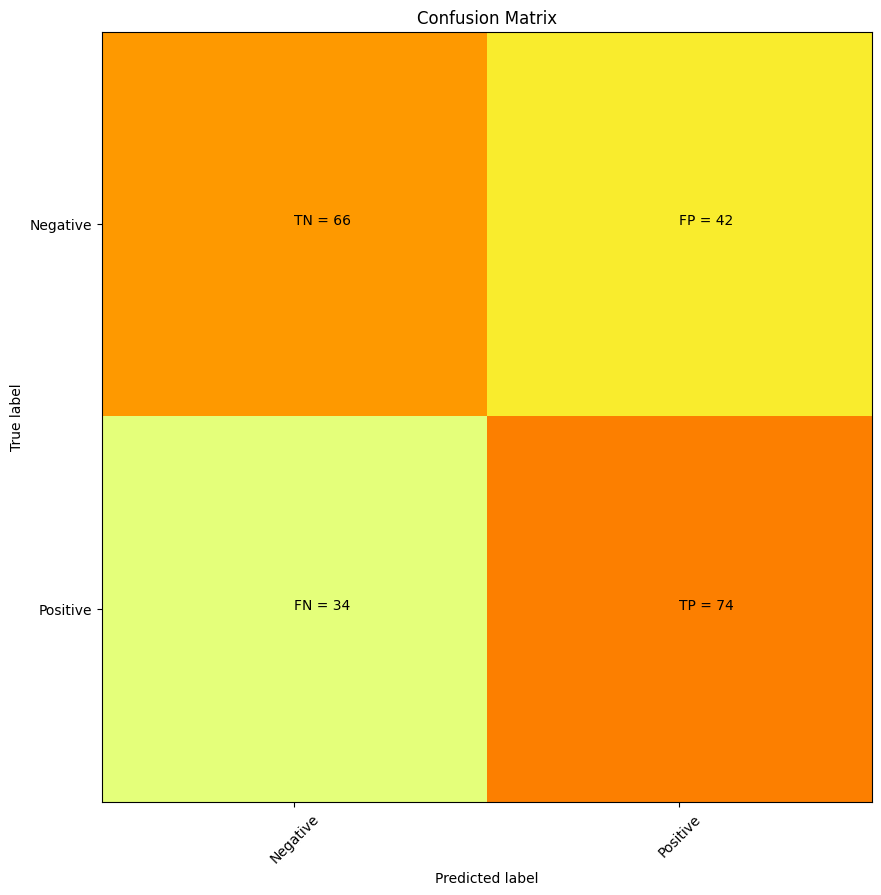

['All', 'IL-12 p40'] precision = 0.6379310344827587 recall = 0.6851851851851852
features 504
target 504
(101, 64, 64, 3)
(403, 64, 64, 3)
Epoch 1/10
14/14 [==============================] - 24s 701ms/step - loss: 0.7832 - val_loss: 0.7021
Epoch 2/10
14/14 [==============================] - 7s 533ms/step - loss: 0.6908 - val_loss: 0.6629
Epoch 3/10
14/14 [==============================] - 7s 487ms/step - loss: 0.6751 - val_loss: 0.7012
Epoch 4/10
14/14 [==============================] - 7s 539ms/step - loss: 0.6804 - val_loss: 0.6885
Epoch 5/10
14/14 [==============================] - 8s 589ms/step - loss: 0.6726 - val_loss: 0.6921
Epoch 6/10
14/14 [==============================] - 7s 487ms/step - loss: 0.6665 - val_loss: 0.7041
Epoch 7/10
14/14 [==============================] - 7s 534ms/step - loss: 0.6866 - val_loss: 0.6798
Epoch 8/10
14/14 [==============================] - 7s 488ms/step - loss: 0.6544 - val_loss: 0.6635
Epoch 9/10
14/14 [==============================] - 7s 533ms/

['All', 'IL-16'] precision = 0.7401574803149606 recall = 0.373015873015873
features 544
target 544
(109, 64, 64, 3)
(435, 64, 64, 3)
Epoch 1/10
15/15 [==============================] - 21s 708ms/step - loss: 0.7278 - val_loss: 0.6926
Epoch 2/10
15/15 [==============================] - 7s 490ms/step - loss: 0.6879 - val_loss: 0.7095
Epoch 3/10
15/15 [==============================] - 9s 625ms/step - loss: 0.6821 - val_loss: 0.6907
Epoch 4/10
15/15 [==============================] - 9s 627ms/step - loss: 0.6824 - val_loss: 0.6950
Epoch 5/10
15/15 [==============================] - 9s 584ms/step - loss: 0.6845 - val_loss: 0.7103
Epoch 6/10
15/15 [==============================] - 9s 585ms/step - loss: 0.6782 - val_loss: 0.6738
Epoch 7/10
15/15 [==============================] - 9s 629ms/step - loss: 0.6886 - val_loss: 0.6803
Epoch 8/10
15/15 [==============================] - 8s 531ms/step - loss: 0.6836 - val_loss: 0.6831
Epoch 9/10
15/15 [==============================] - 7s 494ms/step 

['All', 'IL-6 R alpha'] precision = 0.5228215767634855 recall = 0.9264705882352942
features 1288
target 1288
(258, 64, 64, 3)
(1030, 64, 64, 3)
Epoch 1/10
35/35 [==============================] - 31s 574ms/step - loss: 0.6924 - val_loss: 0.6864
Epoch 2/10
35/35 [==============================] - 20s 589ms/step - loss: 0.6966 - val_loss: 0.6841
Epoch 3/10
35/35 [==============================] - 20s 576ms/step - loss: 0.6887 - val_loss: 0.6817
Epoch 4/10
35/35 [==============================] - 18s 515ms/step - loss: 0.6876 - val_loss: 0.6823
Epoch 5/10
35/35 [==============================] - 20s 573ms/step - loss: 0.6895 - val_loss: 0.6917
Epoch 6/10
35/35 [==============================] - 18s 509ms/step - loss: 0.6816 - val_loss: 0.6859
Epoch 7/10
35/35 [==============================] - 18s 526ms/step - loss: 0.6786 - val_loss: 0.7106
Epoch 8/10
35/35 [==============================] - 18s 511ms/step - loss: 0.6783 - val_loss: 0.6762
Epoch 9/10
35/35 [==============================

['All', 'IL-6'] precision = 0.527027027027027 recall = 0.9083850931677019
features 352
target 352
(71, 64, 64, 3)
(281, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 18s 738ms/step - loss: 0.7198 - val_loss: 0.6848
Epoch 2/10
10/10 [==============================] - 5s 552ms/step - loss: 0.6906 - val_loss: 0.6839
Epoch 3/10
10/10 [==============================] - 5s 485ms/step - loss: 0.6893 - val_loss: 0.6820
Epoch 4/10
10/10 [==============================] - 7s 702ms/step - loss: 0.7318 - val_loss: 0.7013
Epoch 5/10
10/10 [==============================] - 5s 533ms/step - loss: 0.6955 - val_loss: 0.6962
Epoch 6/10
10/10 [==============================] - 5s 536ms/step - loss: 0.6918 - val_loss: 0.6914
Epoch 7/10
10/10 [==============================] - 5s 496ms/step - loss: 0.6843 - val_loss: 0.6978
Epoch 8/10
10/10 [==============================] - 5s 483ms/step - loss: 0.6821 - val_loss: 0.7026
Epoch 9/10
10/10 [==============================] - 5s 546ms/step - 

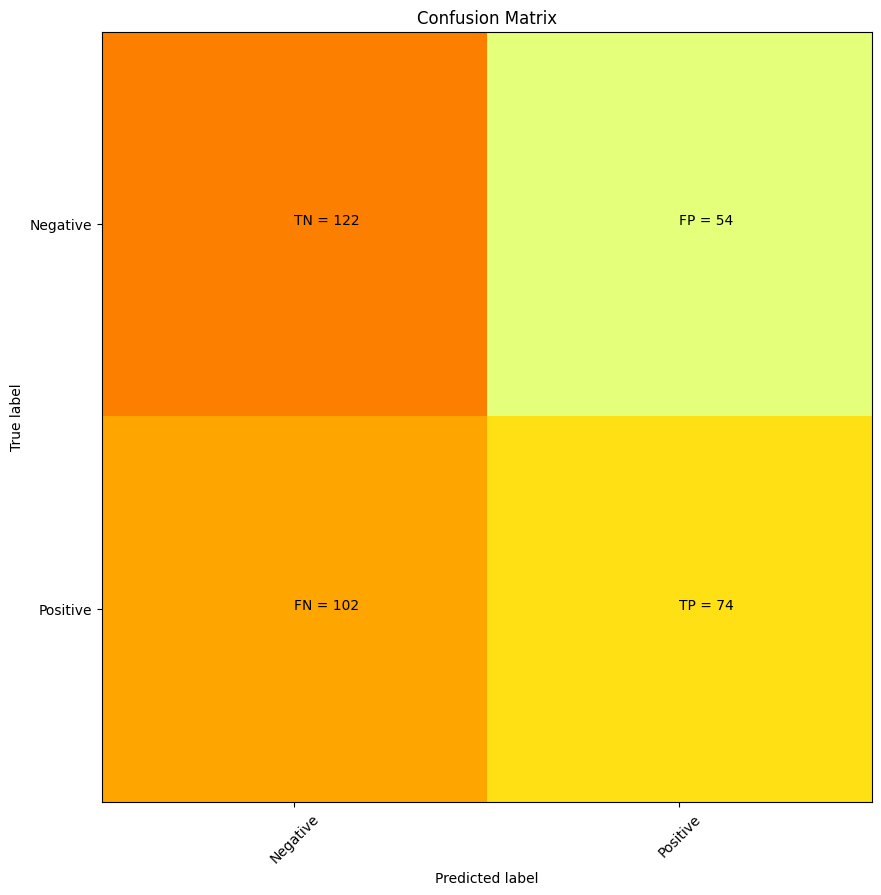

['All', 'IL-8'] precision = 0.578125 recall = 0.42045454545454547
features 232
target 232
(47, 64, 64, 3)
(185, 64, 64, 3)
Epoch 1/10
7/7 [==============================] - 17s 860ms/step - loss: 0.6808 - val_loss: 0.6589
Epoch 2/10
7/7 [==============================] - 4s 552ms/step - loss: 0.6568 - val_loss: 0.6427
Epoch 3/10
7/7 [==============================] - 3s 468ms/step - loss: 0.6278 - val_loss: 0.6436
Epoch 4/10
7/7 [==============================] - 3s 458ms/step - loss: 0.6227 - val_loss: 0.6541
Epoch 5/10
7/7 [==============================] - 3s 464ms/step - loss: 0.6390 - val_loss: 0.6157
Epoch 6/10
7/7 [==============================] - 4s 540ms/step - loss: 0.5964 - val_loss: 0.6203
Epoch 7/10
7/7 [==============================] - 3s 464ms/step - loss: 0.5758 - val_loss: 0.6901
Epoch 8/10
7/7 [==============================] - 3s 452ms/step - loss: 0.6349 - val_loss: 0.5955
Epoch 9/10
7/7 [==============================] - 4s 607ms/step - loss: 0.6060 - val_loss: 0

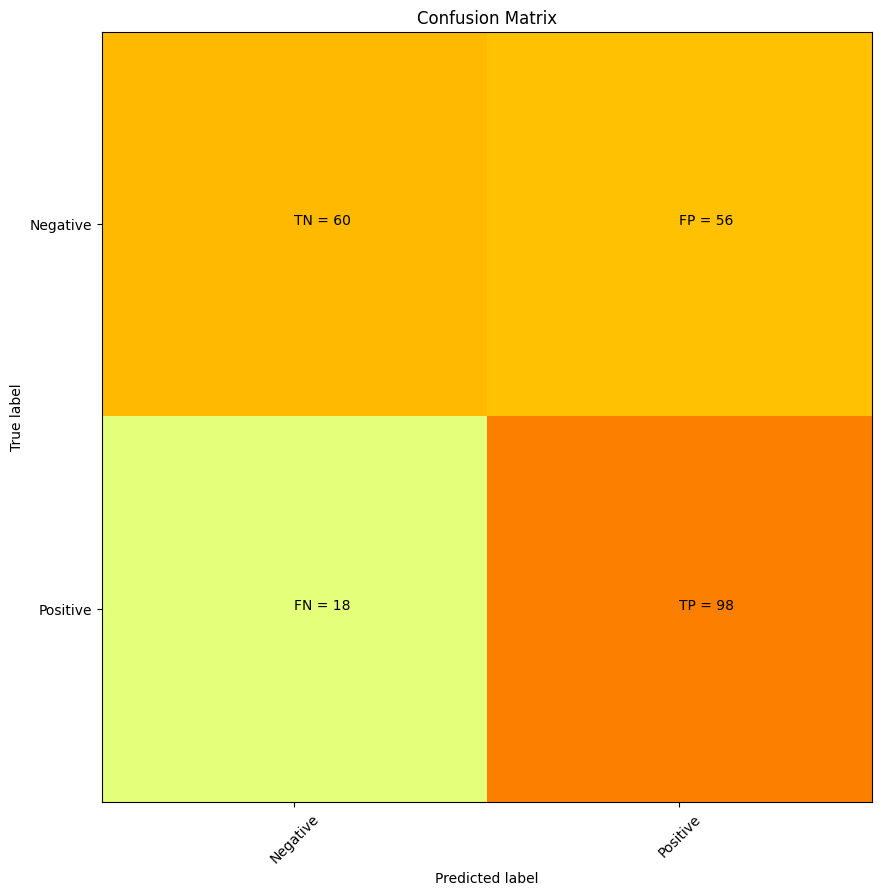

['All', 'MMP-9'] precision = 0.6363636363636364 recall = 0.8448275862068966
features 696
target 696
(140, 64, 64, 3)
(556, 64, 64, 3)
Epoch 1/10
19/19 [==============================] - 24s 704ms/step - loss: 0.7458 - val_loss: 0.6931
Epoch 2/10
19/19 [==============================] - 10s 524ms/step - loss: 0.6950 - val_loss: 0.7147
Epoch 3/10
19/19 [==============================] - 10s 553ms/step - loss: 0.6928 - val_loss: 0.6917
Epoch 4/10
19/19 [==============================] - 9s 498ms/step - loss: 0.6906 - val_loss: 0.6836
Epoch 5/10
19/19 [==============================] - 10s 525ms/step - loss: 0.6877 - val_loss: 0.6888
Epoch 6/10
19/19 [==============================] - 10s 527ms/step - loss: 0.6793 - val_loss: 0.6822
Epoch 7/10
19/19 [==============================] - 10s 522ms/step - loss: 0.6790 - val_loss: 0.7232
Epoch 8/10
19/19 [==============================] - 10s 526ms/step - loss: 0.6808 - val_loss: 0.6928
Epoch 9/10
19/19 [==============================] - 9s 493m

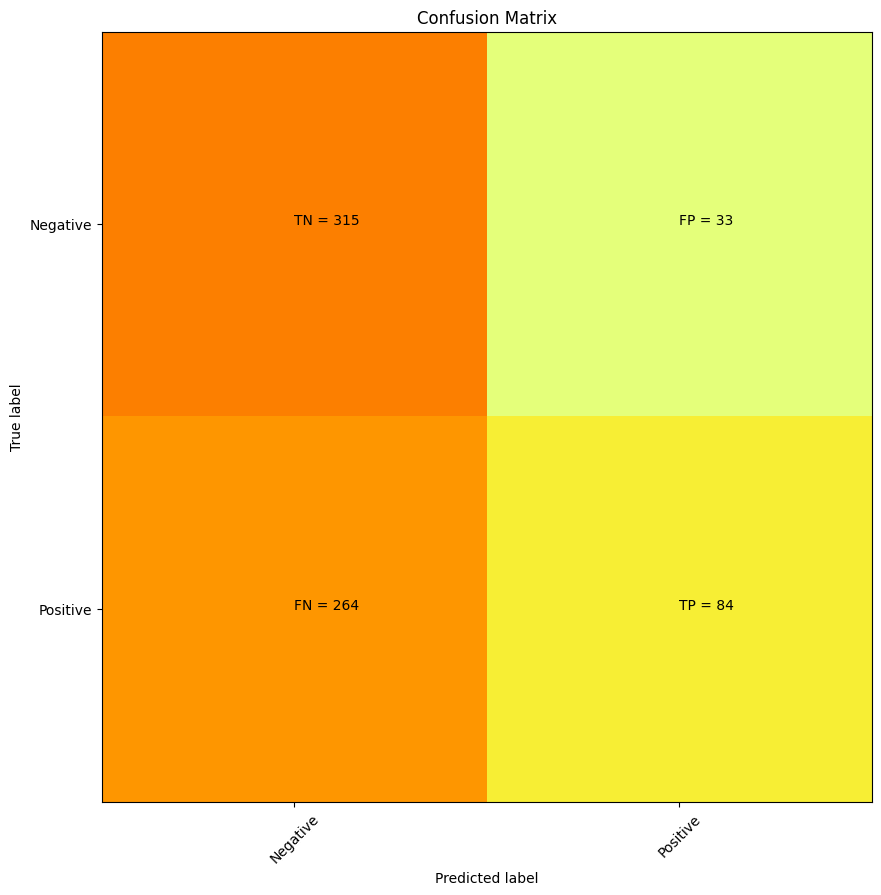

['All', 'TNF RII'] precision = 0.717948717948718 recall = 0.2413793103448276
features 496
target 496
(100, 64, 64, 3)
(396, 64, 64, 3)
Epoch 1/10
14/14 [==============================] - 20s 694ms/step - loss: 0.7014 - val_loss: 0.6988
Epoch 2/10
14/14 [==============================] - 7s 524ms/step - loss: 0.6965 - val_loss: 0.7005
Epoch 3/10
14/14 [==============================] - 7s 483ms/step - loss: 0.6842 - val_loss: 0.7071
Epoch 4/10
14/14 [==============================] - 7s 527ms/step - loss: 0.6806 - val_loss: 0.7083
Epoch 5/10
14/14 [==============================] - 7s 491ms/step - loss: 0.6845 - val_loss: 0.7281
Epoch 6/10
14/14 [==============================] - 7s 514ms/step - loss: 0.6828 - val_loss: 0.7054
Epoch 7/10
14/14 [==============================] - 7s 524ms/step - loss: 0.6765 - val_loss: 0.7131
Epoch 8/10
14/14 [==============================] - 7s 487ms/step - loss: 0.6770 - val_loss: 0.6905
Epoch 9/10
14/14 [==============================] - 7s 523ms/ste

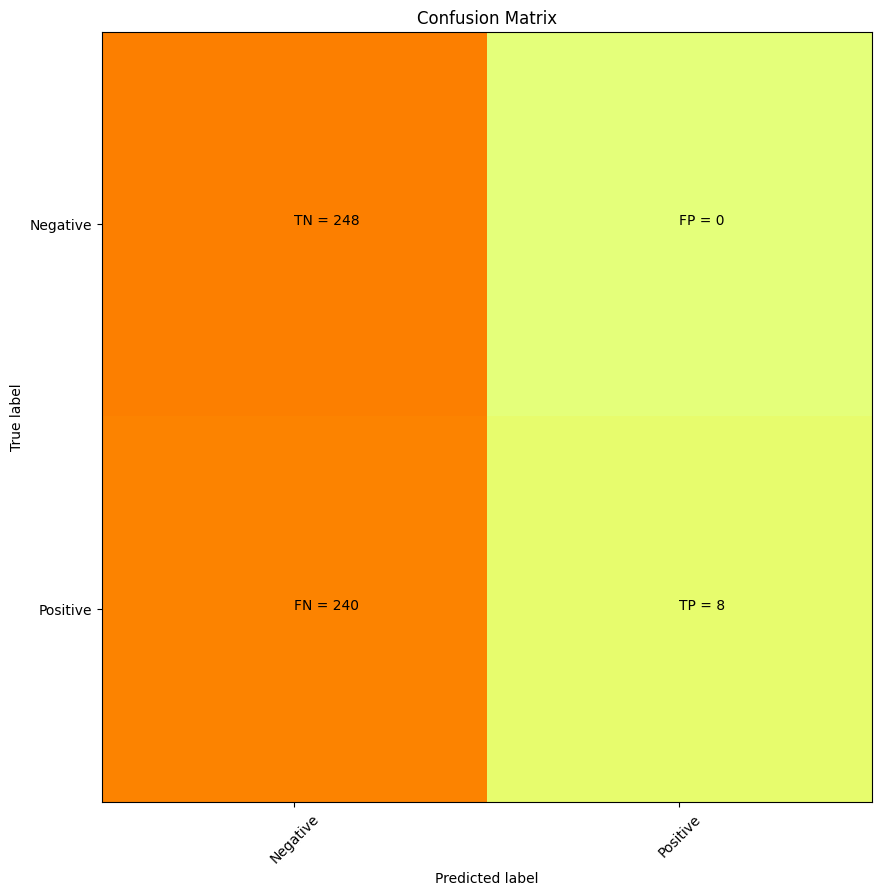

['All', 'TNF alpha'] precision = 1.0 recall = 0.03225806451612903


Cytokine  Precision    Recall  F1 Score Augmentation
0      Activin A   0.529915  0.989362  0.690167          All
1           CCL1   0.590164  0.586957  0.588556          All
2          CCL19   0.666667  0.500000  0.571429          All
3           CCL2   0.539855  0.392105  0.454268          All
4          CCL20   0.607143  0.708333  0.653846          All
5          CCL22   0.595442  0.418000  0.491187          All
6           CCL4   0.716981  0.206522  0.320675          All
7           CCL5   0.522908  0.986842  0.683594          All
8           CD14   0.601227  0.401639  0.481572          All
9            CRP   0.538043  0.863372  0.662946          All
10         CXCL1   0.693548  0.500000  0.581081          All
11        CXCL10   0.777778  0.308824  0.442105          All
12        CXCL13   0.916667  0.392857  0.550000          All
13         CXCL3   0.544922  0.801724  0.648837          All
14         CXCL5   0.563694  0.725410  0.634409          All
15         G-CSF   0.526316  1.000000  0.689655          All
16        GM-CSF   0.842105  0.500000  0.627451          All
17    IL-1 alpha   0.525126  0.950000  0.676375          All
18     IL-1 beta   0.803571  0.125000  0.216346          All
19     IL-12 p40   0.637931  0.685185  0.660714          All
20         IL-16   0.740157  0.373016  0.496042          All
21  IL-6 R alpha   0.522822  0.926471  0.668435          All
22          IL-6   0.527027  0.908385  0.667047          All
23          IL-8   0.578125  0.420455  0.486842          All
24         MMP-9   0.636364  0.844828  0.725926          All
25       TNF RII   0.717949  0.241379  0.361290          All
26     TNF alpha   1.000000  0.032258  0.062500          All

In [24]:
# from keras.layers import LeakyReLU

totalresultsvit500k = []


for df in longdfs:
  indices = list(df.index.values)
  features = []

  for i in indices:
    thing = total_scaled_arrays[i]
    features.append(thing)
    thing2 = total_scaled_arrays[i+384]
    features.append(thing2)
    thing3 = total_scaled_arrays[i+384+384]
    features.append(thing3)
    thing4 = total_scaled_arrays[i+384+384+384]
    features.append(thing4)


  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]
  #this is 2 arrays
  #put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.2)


  #reshaping gray scale images so that we can use the RGB transformer

  for i in range(len(X_test)):
    X_test[i] = np.stack((X_test[i],)*3, axis=-1)
    X_test[i] = np.squeeze(X_test[i])

  for i in range(len(X_train)):
    X_train[i] = np.stack((X_train[i],)*3, axis=-1)
    X_train[i] = np.squeeze(X_train[i])


  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  print(test_images.shape)
  print(train_images.shape)

#get a model for each cytokine

  # vitmodel_temp = tf.keras.models.clone_model(vitmodel)

#cant figure out how to clone this one, don't think this will work???? (ie, it will keep training instead of reverting back to default and starting over)
  vitmodel_temp = vitmodel

  vitmodel_temp.compile(optimizer='adam', loss='binary_crossentropy')


  vitmodel_temp.fit(train_images, train_labels, epochs=10,
            validation_data=(test_images, test_labels), batch_size=30)

#get predictions

  preds = []
  for i in range(len(features)):
    single = features[i]
    single = np.stack((single,)*3, axis=-1)
    single = np.squeeze(single)
    single = np.expand_dims(single, axis=0)
    preds.append(vitmodel_temp.predict(single))
  preds

  #this part of the code has changed slightly to accomodate the new single number output
  answer = []
  for i in range(len(preds)):
    if preds[i][0][0]<=0.5:
      answer.append(0)
    else:
      answer.append(1)
  answer

  precision, recall = confusio_matrix(target2final,answer, ['All',df.columns[0]])

  f1_score = 2*(precision*recall)/(precision+recall)

  totalresultsvit500k.append([df.columns[0],precision, recall, f1_score])

#summarize metrics

summarizer_totalvit500k = pd.DataFrame(columns =["Cytokine", "Precision", "Recall", "F1 Score", "Augmentation"])

for i in range(len(totalresultsvit500k)):
  f1_score = totalresultsvit500k[i][3]
  precision = totalresultsvit500k[i][1]
  recall = totalresultsvit500k[i][2]
  cytokine = totalresultsvit500k[i][0]
  augmentation = "All"
  tracking = [cytokine, precision, recall, f1_score, augmentation]
  summarizer_totalvit500k.loc[len(summarizer_totalvit500k.index)] = tracking

summarizer_totalvit500k

In [25]:
summarizer_totalvit500k[summarizer_totalvit500k["Precision"]>0.65]

Cytokine  Precision    Recall  F1 Score Augmentation
2       CCL19   0.666667  0.500000  0.571429          All
6        CCL4   0.716981  0.206522  0.320675          All
10      CXCL1   0.693548  0.500000  0.581081          All
11     CXCL10   0.777778  0.308824  0.442105          All
12     CXCL13   0.916667  0.392857  0.550000          All
16     GM-CSF   0.842105  0.500000  0.627451          All
18  IL-1 beta   0.803571  0.125000  0.216346          All
20      IL-16   0.740157  0.373016  0.496042          All
25    TNF RII   0.717949  0.241379  0.361290          All
26  TNF alpha   1.000000  0.032258  0.062500          All

# Try a simpler ViT

In [87]:
  vitmodel = tf.keras.Sequential(vit_model,name='ViT')
  vitmodel.add(tf.keras.layers.Dense(256))
  vitmodel.add(LeakyReLU(alpha=0.2))
  vitmodel.add(tf.keras.layers.Dense(128))
  vitmodel.add(LeakyReLU(alpha=0.2))
  vitmodel.add(tf.keras.layers.Dense(64))
  vitmodel.add(LeakyReLU(alpha=0.2))
  vitmodel.add(tf.keras.layers.Dense(32))
  vitmodel.add(LeakyReLU(alpha=0.2))

  vitmodel.add(tf.keras.layers.Dense(1, activation="sigmoid"))

  vitmodel.summary()

Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_5 (Dense)             (None, 1)                 769       
                                                                 
Total params: 87421441 (333.49 MB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 87420672 (333.48 MB)
_________________________________________________________________


In [ ]:
vit_model = vit.vit_b32(
image_size = 64,
activation = 'max',
pretrained = True,
include_top = False,
pretrained_top = False,
classes = 2)

vit_model.trainable = False

vitmodel = tf.keras.Sequential(vit_model,name='ViT')

vitmodel.add(tf.keras.layers.Dense(1, activation="sigmoid"))


In [88]:
# from keras.layers import LeakyReLU

totalresultsvit_simple = []


for df in longdfs:
  indices = list(df.index.values)
  features = []

  for i in indices:
    thing = total_scaled_arrays[i]
    features.append(thing)
    thing2 = total_scaled_arrays[i+384]
    features.append(thing2)
    thing3 = total_scaled_arrays[i+384+384]
    features.append(thing3)
    thing4 = total_scaled_arrays[i+384+384+384]
    features.append(thing4)


  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]
  #this is 2 arrays
  #put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.2)


  #reshaping gray scale images so that we can use the RGB transformer

  for i in range(len(X_test)):
    X_test[i] = np.stack((X_test[i],)*3, axis=-1)
    X_test[i] = np.squeeze(X_test[i])

  for i in range(len(X_train)):
    X_train[i] = np.stack((X_train[i],)*3, axis=-1)
    X_train[i] = np.squeeze(X_train[i])


  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  print(test_images.shape)
  print(train_images.shape)

#get a model for each cytokine

  # vitmodel_temp = tf.keras.models.clone_model(vitmodel)

#cant figure out how to clone this one, don't think this will work???? (ie, it will keep training instead of reverting back to default and starting over)
  vitmodel_temp = vit_model

  vitmodel_temp.compile(optimizer='adam', loss='binary_crossentropy')


  vitmodel_temp.fit(train_images, train_labels, epochs=10,
            validation_data=(test_images, test_labels), batch_size=30)

#get predictions

  preds = []
  for i in range(len(features)):
    single = features[i]
    single = np.stack((single,)*3, axis=-1)
    single = np.squeeze(single)
    single = np.expand_dims(single, axis=0)
    preds.append(vitmodel_temp.predict(single))
  preds

  #this part of the code has changed slightly to accomodate the new single number output
  answer = []
  for i in range(len(preds)):
    if preds[i][0][0]<=0.5:
      answer.append(0)
    else:
      answer.append(1)
  answer

  precision, recall = confusio_matrix(target2final,answer, ['All',df.columns[0]])

  f1_score = 2*(precision*recall)/(precision+recall)

  totalresultsvit_simple.append([df.columns[0],precision, recall, f1_score])

#summarize metrics

summarizer_totalvit_simple = pd.DataFrame(columns =["Cytokine", "Precision", "Recall", "F1 Score", "Augmentation"])

for i in range(len(totalresultsvit)):
  f1_score = totalresultsvit_simple[i][3]
  precision = totalresultsvit_simple[i][1]
  recall = totalresultsvit_simple[i][2]
  cytokine = totalresultsvit_simple[i][0]
  augmentation = "All"
  tracking = [cytokine, precision, recall, f1_score, augmentation]
  summarizer_totalvit_simple.loc[len(summarizer_totalvit.index)] = tracking

# summarizer_totalvit_simple

features 376
target 376
(76, 64, 64, 3)
(300, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 17s 1s/step - loss: 4.7622 - val_loss: 5.5543
Epoch 2/10
10/10 [==============================] - 8s 812ms/step - loss: 4.7514 - val_loss: 5.5543
Epoch 3/10
10/10 [==============================] - 7s 675ms/step - loss: 4.7433 - val_loss: 5.5543
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 4.7408 - val_loss: 5.5543
Epoch 5/10
10/10 [==============================] - 8s 811ms/step - loss: 4.7470 - val_loss: 5.5543
Epoch 6/10
10/10 [==============================] - 7s 673ms/step - loss: 4.7538 - val_loss: 5.5543
Epoch 7/10
10/10 [==============================] - 9s 915ms/step - loss: 4.7476 - val_loss: 5.5543
Epoch 8/10
10/10 [==============================] - 7s 671ms/step - loss: 4.7360 - val_loss: 5.5543
Epoch 9/10
10/10 [==============================] - 8s 812ms/step - loss: 4.7402 - val_loss: 5.5543
Epoch 10/10
1/1 [==============================

KeyboardInterrupt: ignored

In [59]:
summarizer_totalvit_simple = pd.DataFrame(columns =["Cytokine", "Precision", "Recall", "F1 Score", "Augmentation"])

for i in range(len(totalresultsvit_simple)):
  f1_score = totalresultsvit_simple[i][3]
  precision = totalresultsvit_simple[i][1]
  recall = totalresultsvit_simple[i][2]
  cytokine = totalresultsvit_simple[i][0]
  augmentation = "All"
  tracking = [cytokine, precision, recall, f1_score, augmentation]
  summarizer_totalvit_simple.loc[len(summarizer_totalvit_simple.index)] = tracking

summarizer_totalvit_simple

Cytokine  Precision    Recall  F1 Score Augmentation
0      Activin A   0.457447  0.228723  0.304965          All
1           CCL1   0.511628  0.358696  0.421725          All
2          CCL19   0.470588  0.333333  0.390244          All
3           CCL2   0.453202  0.242105  0.315609          All
4          CCL20   0.590164  0.300000  0.397790          All
5          CCL22   0.532203  0.314000  0.394969          All
6           CCL4   0.391304  0.244565  0.301003          All
7           CCL5   0.488136  0.270677  0.348247          All
8           CD14   0.576687  0.385246  0.461916          All
9            CRP   0.481865  0.270349  0.346369          All
10         CXCL1   0.396694  0.279070  0.327645          All
11        CXCL10   0.575758  0.279412  0.376238          All
12        CXCL13   0.466667  0.250000  0.325581          All
13         CXCL3   0.494624  0.264368  0.344569          All
14         CXCL5   0.437500  0.258197  0.324742          All
15         G-CSF   0.640000  0.200000  0.304762          All
16        GM-CSF   0.440000  0.343750  0.385965          All
17    IL-1 alpha   0.436364  0.218182  0.290909          All
18     IL-1 beta   0.478873  0.283333  0.356021          All
19     IL-12 p40   0.750000  0.277778  0.405405          All
20         IL-16   0.627451  0.380952  0.474074          All
21  IL-6 R alpha   0.524691  0.312500  0.391705          All
22          IL-6   0.484127  0.284161  0.358121          All
23          IL-8   0.552381  0.329545  0.412811          All
24         MMP-9   0.281250  0.155172  0.200000          All
25       TNF RII   0.597633  0.290230  0.390716          All
26     TNF alpha   0.464286  0.262097  0.335052          All

In [61]:
simplevitp=summarizer_totalvit_simple[summarizer_totalvit_simple["Precision"]>0.65]
simplevitp2 = simplevitp[simplevitp["Recall"]>0.65]
# simplevitp2
simplevitp

Cytokine  Precision    Recall  F1 Score Augmentation
19  IL-12 p40       0.75  0.277778  0.405405          All

# none again!

Last chance - try a simpler ViT no augmentation

features 94
target 94
(19, 64, 64, 3)
(75, 64, 64, 3)
Epoch 1/10
3/3 [==============================] - 24s 5s/step - loss: 4.9839 - val_loss: 4.6886
Epoch 2/10
3/3 [==============================] - 2s 833ms/step - loss: 4.9390 - val_loss: 4.6886
Epoch 3/10
3/3 [==============================] - 3s 966ms/step - loss: 4.9549 - val_loss: 4.6886
Epoch 4/10
3/3 [==============================] - 2s 599ms/step - loss: 4.9657 - val_loss: 4.6886
Epoch 5/10
3/3 [==============================] - 2s 605ms/step - loss: 4.9963 - val_loss: 4.6886
Epoch 6/10
3/3 [==============================] - 2s 750ms/step - loss: 4.9725 - val_loss: 4.6886
Epoch 7/10
3/3 [==============================] - 2s 757ms/step - loss: 4.9587 - val_loss: 4.6886
Epoch 8/10
3/3 [==============================] - 2s 752ms/step - loss: 4.9451 - val_loss: 4.6886
Epoch 9/10
3/3 [==============================] - 3s 896ms/step - loss: 4.9537 - val_loss: 4.6886
Epoch 10/10
1/1 [==============================] - 0s 100ms/step


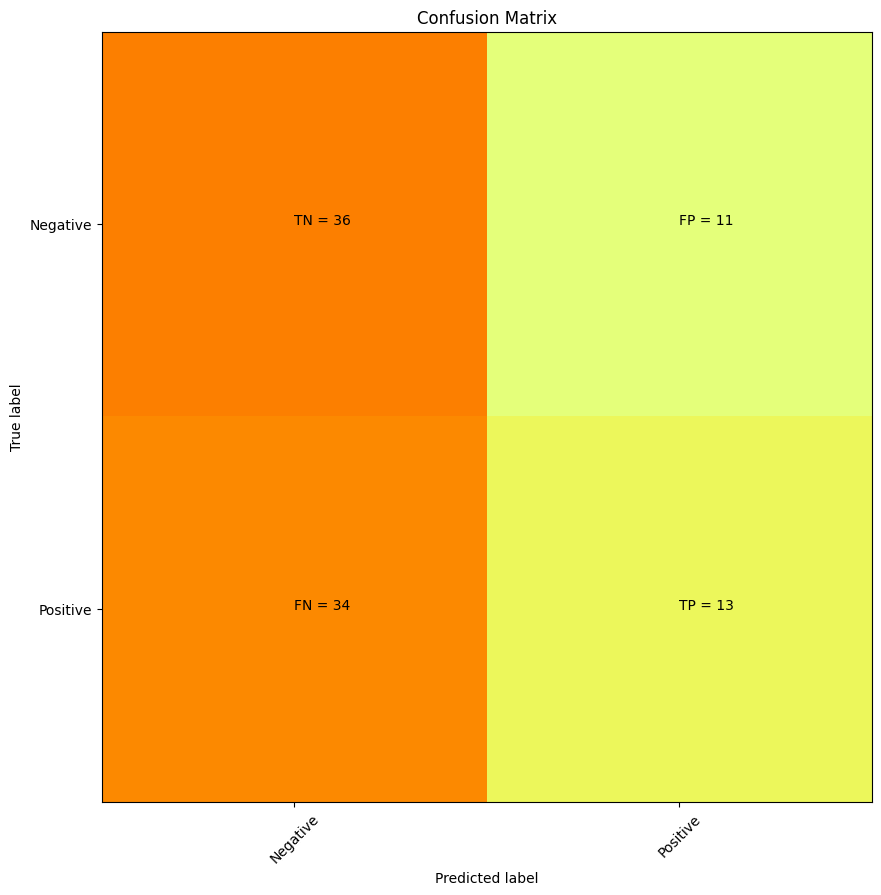

['All', 'Activin A'] precision = 0.5416666666666666 recall = 0.2765957446808511
features 92
target 92
(19, 64, 64, 3)
(73, 64, 64, 3)
Epoch 1/10
3/3 [==============================] - 13s 2s/step - loss: 5.0514 - val_loss: 4.6277
Epoch 2/10
3/3 [==============================] - 2s 738ms/step - loss: 5.0065 - val_loss: 4.6277
Epoch 3/10
3/3 [==============================] - 2s 943ms/step - loss: 4.9833 - val_loss: 4.6277
Epoch 4/10
3/3 [==============================] - 3s 808ms/step - loss: 4.9484 - val_loss: 4.6277
Epoch 5/10
3/3 [==============================] - 2s 734ms/step - loss: 5.0141 - val_loss: 4.6277
Epoch 6/10
3/3 [==============================] - 2s 734ms/step - loss: 4.9825 - val_loss: 4.6277
Epoch 7/10
3/3 [==============================] - 2s 583ms/step - loss: 4.9848 - val_loss: 4.6277
Epoch 8/10
3/3 [==============================] - 2s 734ms/step - loss: 4.9647 - val_loss: 4.6277
Epoch 9/10
3/3 [==============================] - 2s 848ms/step - loss: 5.0019 - val

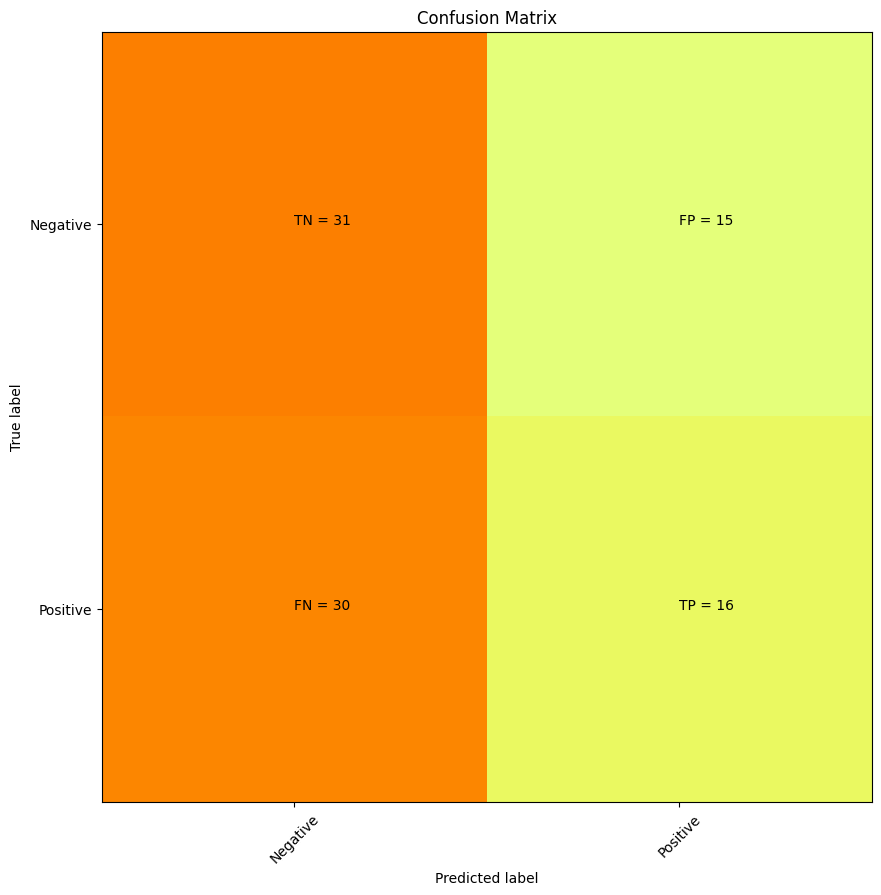

['All', 'CCL1'] precision = 0.5161290322580645 recall = 0.34782608695652173
features 24
target 24
(5, 64, 64, 3)
(19, 64, 64, 3)
Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 5.1020 - val_loss: 4.1977
Epoch 2/10
1/1 [==============================] - 1s 692ms/step - loss: 5.1782 - val_loss: 4.1977
Epoch 3/10
1/1 [==============================] - 1s 700ms/step - loss: 5.2328 - val_loss: 4.1977
Epoch 4/10
1/1 [==============================] - 1s 712ms/step - loss: 5.1256 - val_loss: 4.1977
Epoch 5/10
1/1 [==============================] - 1s 708ms/step - loss: 5.1153 - val_loss: 4.1977
Epoch 6/10
1/1 [==============================] - 1s 542ms/step - loss: 5.1518 - val_loss: 4.1977
Epoch 7/10
1/1 [==============================] - 1s 716ms/step - loss: 5.1897 - val_loss: 4.1977
Epoch 8/10
1/1 [==============================] - 1s 532ms/step - loss: 5.1611 - val_loss: 4.1977
Epoch 9/10
1/1 [==============================] - 1s 555ms/step - loss: 5.1063 - val_los

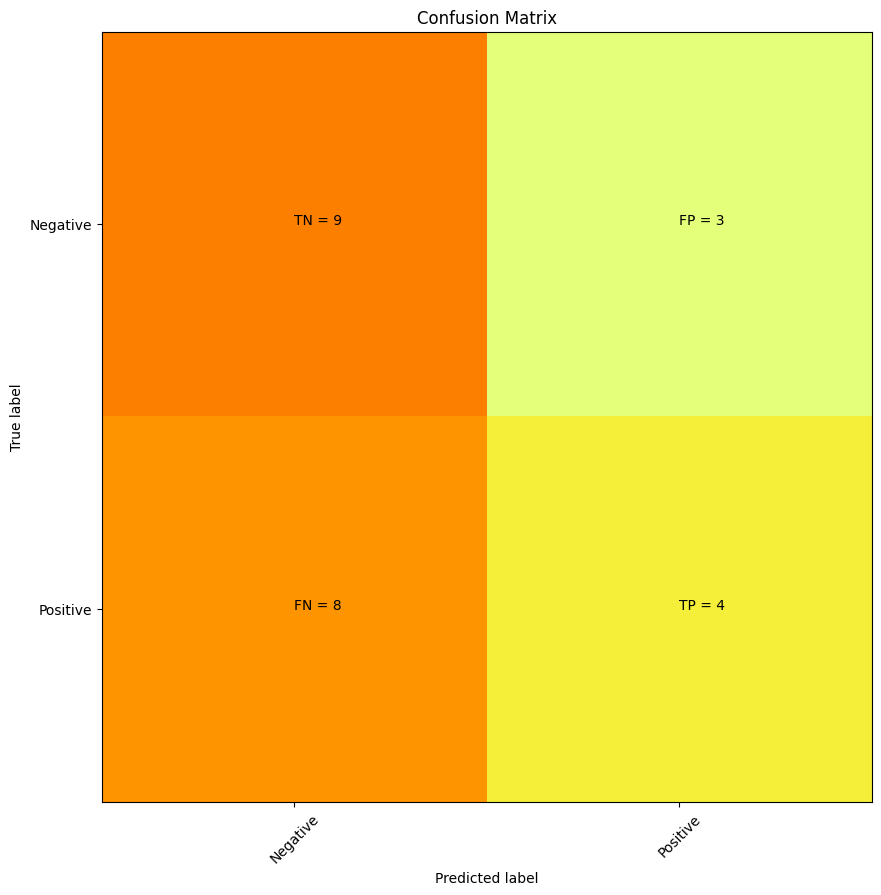

['All', 'CCL19'] precision = 0.5714285714285714 recall = 0.3333333333333333
features 190
target 190
(38, 64, 64, 3)
(152, 64, 64, 3)
Epoch 1/10
6/6 [==============================] - 16s 2s/step - loss: 5.1692 - val_loss: 3.9924
Epoch 2/10
6/6 [==============================] - 4s 725ms/step - loss: 5.1793 - val_loss: 3.9924
Epoch 3/10
6/6 [==============================] - 4s 718ms/step - loss: 5.1307 - val_loss: 3.9924
Epoch 4/10
6/6 [==============================] - 5s 761ms/step - loss: 5.1394 - val_loss: 3.9924
Epoch 5/10
6/6 [==============================] - 4s 713ms/step - loss: 5.1584 - val_loss: 3.9924
Epoch 6/10
6/6 [==============================] - 4s 764ms/step - loss: 5.1428 - val_loss: 3.9924
Epoch 7/10
6/6 [==============================] - 5s 863ms/step - loss: 5.1772 - val_loss: 3.9924
Epoch 8/10
6/6 [==============================] - 4s 714ms/step - loss: 5.1228 - val_loss: 3.9924
Epoch 9/10
6/6 [==============================] - 4s 721ms/step - loss: 5.1453 - val_

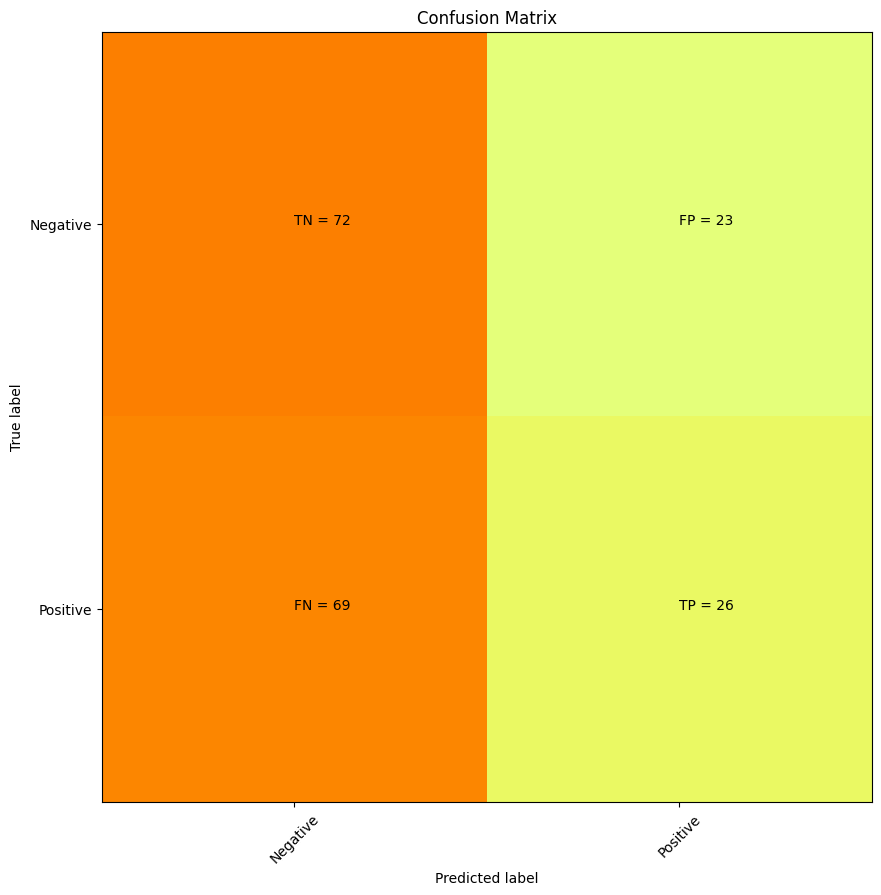

['All', 'CCL2'] precision = 0.5306122448979592 recall = 0.2736842105263158
features 60
target 60
(12, 64, 64, 3)
(48, 64, 64, 3)
Epoch 1/10
2/2 [==============================] - 12s 4s/step - loss: 4.9161 - val_loss: 4.8998
Epoch 2/10
2/2 [==============================] - 2s 909ms/step - loss: 4.8546 - val_loss: 4.8998
Epoch 3/10
2/2 [==============================] - 2s 2s/step - loss: 4.8984 - val_loss: 4.8998
Epoch 4/10
2/2 [==============================] - 1s 699ms/step - loss: 4.8656 - val_loss: 4.8998
Epoch 5/10
2/2 [==============================] - 1s 692ms/step - loss: 4.9034 - val_loss: 4.8998
Epoch 6/10
2/2 [==============================] - 1s 677ms/step - loss: 4.9188 - val_loss: 4.8998
Epoch 7/10
2/2 [==============================] - 1s 609ms/step - loss: 4.8737 - val_loss: 4.8998
Epoch 8/10
2/2 [==============================] - 1s 687ms/step - loss: 4.8303 - val_loss: 4.8998
Epoch 9/10
2/2 [==============================] - 1s 697ms/step - loss: 4.8710 - val_loss: 4

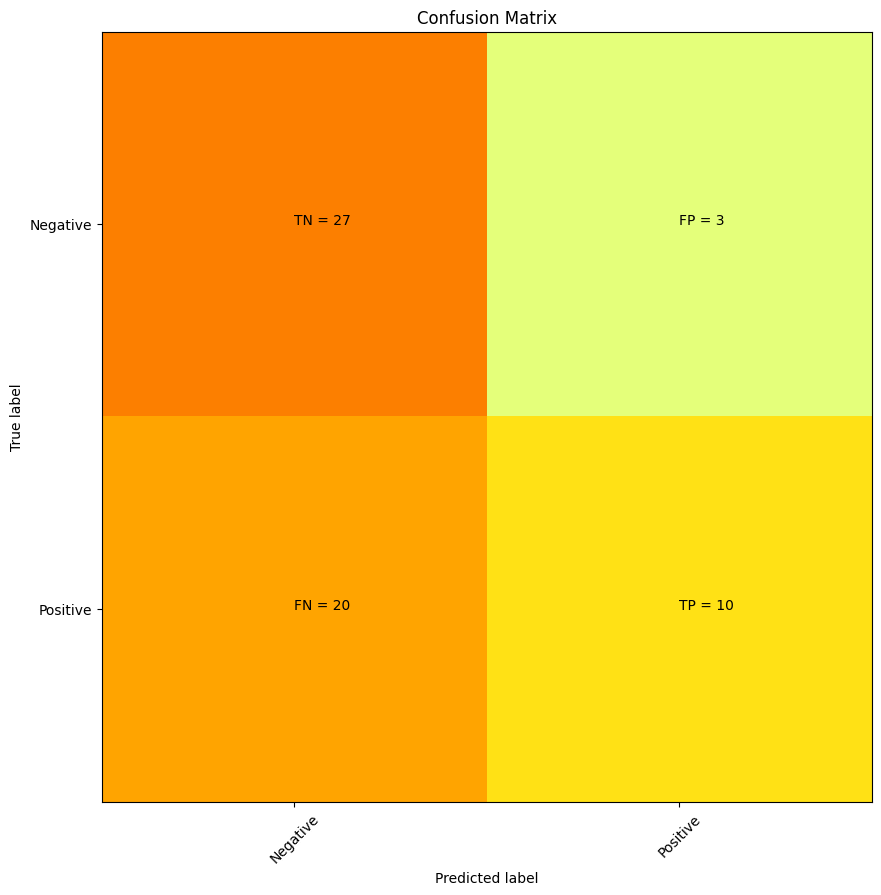

['All', 'CCL20'] precision = 0.7692307692307693 recall = 0.3333333333333333
features 250
target 250
(50, 64, 64, 3)
(200, 64, 64, 3)
Epoch 1/10
7/7 [==============================] - 17s 1s/step - loss: 4.8477 - val_loss: 5.2993
Epoch 2/10
7/7 [==============================] - 5s 814ms/step - loss: 4.8345 - val_loss: 5.2993
Epoch 3/10
7/7 [==============================] - 5s 671ms/step - loss: 4.8201 - val_loss: 5.2993
Epoch 4/10
7/7 [==============================] - 5s 742ms/step - loss: 4.8114 - val_loss: 5.2993
Epoch 5/10
7/7 [==============================] - 6s 941ms/step - loss: 4.8443 - val_loss: 5.2993
Epoch 6/10
7/7 [==============================] - 5s 738ms/step - loss: 4.8335 - val_loss: 5.2993
Epoch 7/10
7/7 [==============================] - 6s 905ms/step - loss: 4.8301 - val_loss: 5.2993
Epoch 8/10
7/7 [==============================] - 6s 771ms/step - loss: 4.8536 - val_loss: 5.2993
Epoch 9/10
7/7 [==============================] - 5s 736ms/step - loss: 4.8431 - val_

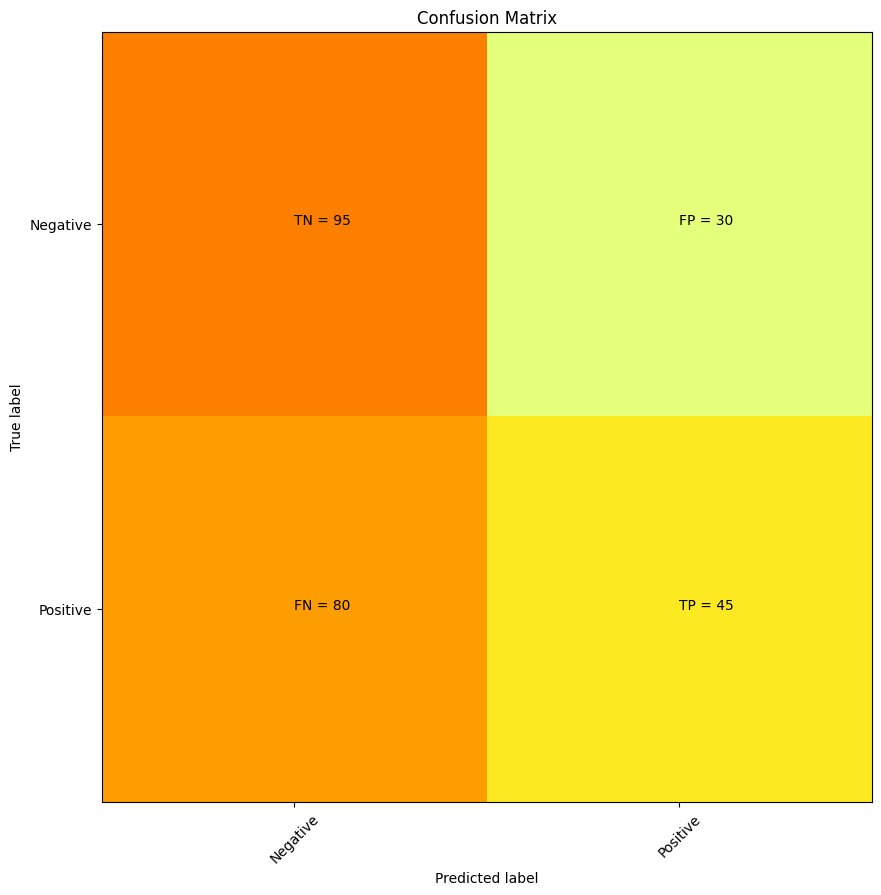

['All', 'CCL22'] precision = 0.6 recall = 0.36
features 92
target 92
(19, 64, 64, 3)
(73, 64, 64, 3)
Epoch 1/10
3/3 [==============================] - 13s 3s/step - loss: 4.8799 - val_loss: 5.0644
Epoch 2/10
3/3 [==============================] - 2s 628ms/step - loss: 4.8223 - val_loss: 5.0644
Epoch 3/10
3/3 [==============================] - 2s 742ms/step - loss: 4.8914 - val_loss: 5.0644
Epoch 4/10
3/3 [==============================] - 2s 742ms/step - loss: 4.8914 - val_loss: 5.0644
Epoch 5/10
3/3 [==============================] - 2s 741ms/step - loss: 4.8533 - val_loss: 5.0644
Epoch 6/10
3/3 [==============================] - 2s 744ms/step - loss: 4.8960 - val_loss: 5.0644
Epoch 7/10
3/3 [==============================] - 2s 959ms/step - loss: 4.8693 - val_loss: 5.0644
Epoch 8/10
3/3 [==============================] - 3s 801ms/step - loss: 4.8672 - val_loss: 5.0644
Epoch 9/10
3/3 [==============================] - 2s 591ms/step - loss: 4.8469 - val_loss: 5.0644
Epoch 10/10
1/1 [==

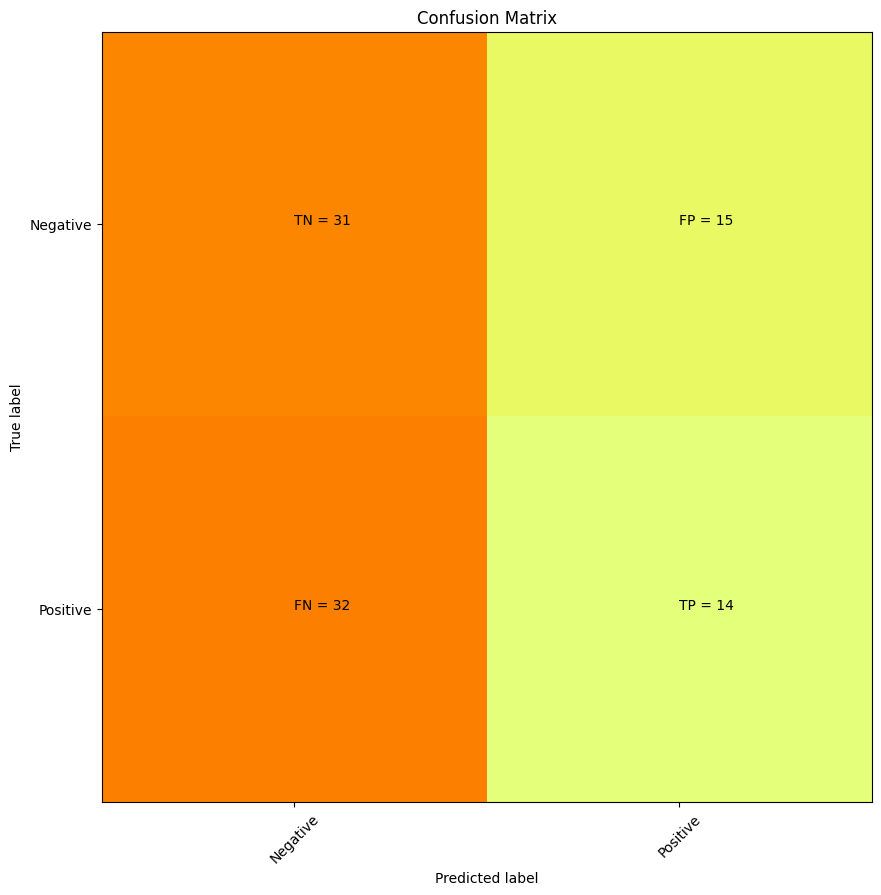

['All', 'CCL4'] precision = 0.4827586206896552 recall = 0.30434782608695654
features 266
target 266
(54, 64, 64, 3)
(212, 64, 64, 3)
Epoch 1/10
8/8 [==============================] - 17s 1s/step - loss: 4.9101 - val_loss: 5.0182
Epoch 2/10
8/8 [==============================] - 5s 618ms/step - loss: 4.8905 - val_loss: 5.0182
Epoch 3/10
8/8 [==============================] - 6s 844ms/step - loss: 4.8981 - val_loss: 5.0182
Epoch 4/10
8/8 [==============================] - 5s 667ms/step - loss: 4.9127 - val_loss: 5.0182
Epoch 5/10
8/8 [==============================] - 7s 882ms/step - loss: 4.8796 - val_loss: 5.0182
Epoch 6/10
8/8 [==============================] - 5s 667ms/step - loss: 4.9412 - val_loss: 5.0182
Epoch 7/10
8/8 [==============================] - 7s 849ms/step - loss: 4.9003 - val_loss: 5.0182
Epoch 8/10
8/8 [==============================] - 5s 668ms/step - loss: 4.9196 - val_loss: 5.0182
Epoch 9/10
8/8 [==============================] - 5s 669ms/step - loss: 4.8723 - val_

['All', 'CCL5'] precision = 0.5294117647058824 recall = 0.2706766917293233
features 122
target 122
(25, 64, 64, 3)
(97, 64, 64, 3)
Epoch 1/10
4/4 [==============================] - 14s 2s/step - loss: 4.9692 - val_loss: 4.8365
Epoch 2/10
4/4 [==============================] - 3s 658ms/step - loss: 4.9388 - val_loss: 4.8365
Epoch 3/10
4/4 [==============================] - 3s 665ms/step - loss: 4.9682 - val_loss: 4.8365
Epoch 4/10
4/4 [==============================] - 3s 654ms/step - loss: 4.9433 - val_loss: 4.8365
Epoch 5/10
4/4 [==============================] - 3s 868ms/step - loss: 4.9766 - val_loss: 4.8365
Epoch 6/10
4/4 [==============================] - 3s 709ms/step - loss: 4.9674 - val_loss: 4.8365
Epoch 7/10
4/4 [==============================] - 3s 658ms/step - loss: 4.9494 - val_loss: 4.8365
Epoch 8/10
4/4 [==============================] - 2s 586ms/step - loss: 4.9568 - val_loss: 4.8365
Epoch 9/10
4/4 [==============================] - 3s 652ms/step - loss: 4.9803 - val_lo

['All', 'CD14'] precision = 0.5128205128205128 recall = 0.32786885245901637
features 172
target 172
(35, 64, 64, 3)
(137, 64, 64, 3)
Epoch 1/10
5/5 [==============================] - 16s 2s/step - loss: 4.9157 - val_loss: 4.7899
Epoch 2/10
5/5 [==============================] - 4s 838ms/step - loss: 4.9519 - val_loss: 4.7899
Epoch 3/10
5/5 [==============================] - 3s 678ms/step - loss: 4.9406 - val_loss: 4.7899
Epoch 4/10
5/5 [==============================] - 4s 829ms/step - loss: 4.9441 - val_loss: 4.7899
Epoch 5/10
5/5 [==============================] - 5s 921ms/step - loss: 4.9393 - val_loss: 4.7899
Epoch 6/10
5/5 [==============================] - 3s 667ms/step - loss: 4.9483 - val_loss: 4.7899
Epoch 7/10
5/5 [==============================] - 3s 664ms/step - loss: 4.9496 - val_loss: 4.7899
Epoch 8/10
5/5 [==============================] - 5s 1s/step - loss: 4.9615 - val_loss: 4.7899
Epoch 9/10
5/5 [==============================] - 4s 823ms/step - loss: 4.9257 - val_los

['All', 'CRP'] precision = 0.5217391304347826 recall = 0.27906976744186046
features 86
target 86
(18, 64, 64, 3)
(68, 64, 64, 3)
Epoch 1/10
3/3 [==============================] - 13s 2s/step - loss: 4.8641 - val_loss: 5.3375
Epoch 2/10
3/3 [==============================] - 2s 717ms/step - loss: 4.8778 - val_loss: 5.3375
Epoch 3/10
3/3 [==============================] - 2s 714ms/step - loss: 4.7983 - val_loss: 5.3375
Epoch 4/10
3/3 [==============================] - 3s 980ms/step - loss: 4.8608 - val_loss: 5.3375
Epoch 5/10
3/3 [==============================] - 3s 910ms/step - loss: 4.8364 - val_loss: 5.3375
Epoch 6/10
3/3 [==============================] - 2s 550ms/step - loss: 4.8962 - val_loss: 5.3375
Epoch 7/10
3/3 [==============================] - 2s 576ms/step - loss: 4.8273 - val_loss: 5.3375
Epoch 8/10
3/3 [==============================] - 2s 707ms/step - loss: 4.8192 - val_loss: 5.3375
Epoch 9/10
3/3 [==============================] - 2s 708ms/step - loss: 4.8568 - val_loss

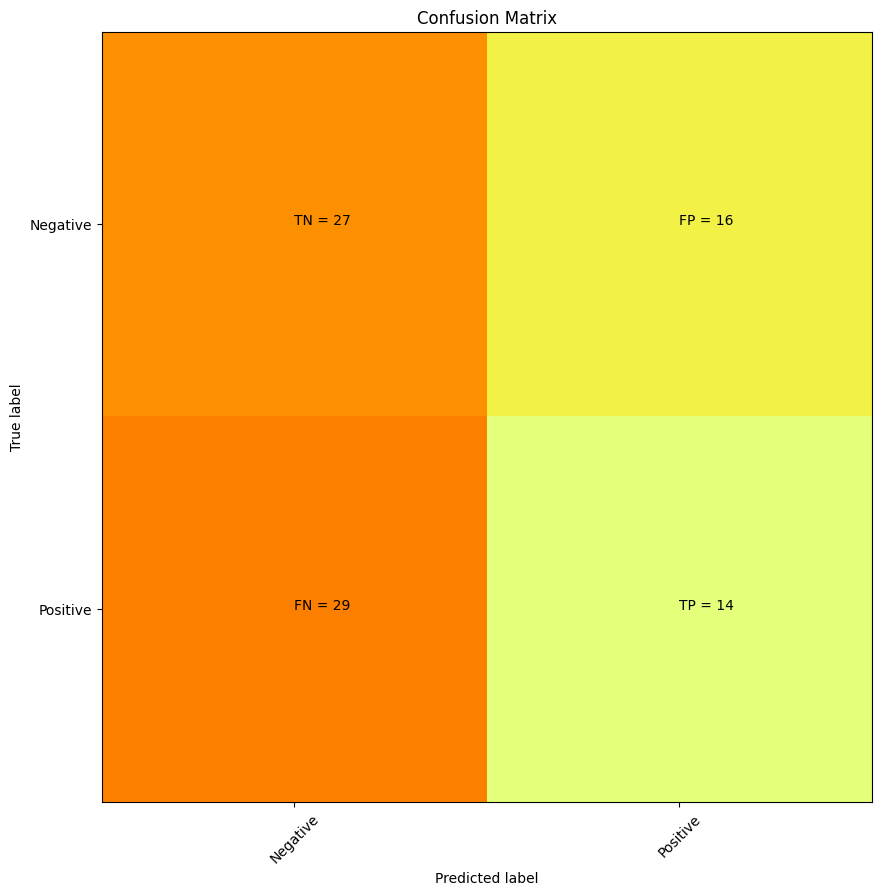

['All', 'CXCL1'] precision = 0.4666666666666667 recall = 0.32558139534883723
features 34
target 34
(7, 64, 64, 3)
(27, 64, 64, 3)
Epoch 1/10
1/1 [==============================] - 14s 14s/step - loss: 4.7915 - val_loss: 5.2664
Epoch 2/10
1/1 [==============================] - 1s 716ms/step - loss: 4.7350 - val_loss: 5.2664
Epoch 3/10
1/1 [==============================] - 1s 852ms/step - loss: 4.6752 - val_loss: 5.2664
Epoch 4/10
1/1 [==============================] - 1s 725ms/step - loss: 4.6673 - val_loss: 5.2664
Epoch 5/10
1/1 [==============================] - 1s 857ms/step - loss: 4.7602 - val_loss: 5.2664
Epoch 6/10
1/1 [==============================] - 1s 842ms/step - loss: 4.7446 - val_loss: 5.2664
Epoch 7/10
1/1 [==============================] - 1s 855ms/step - loss: 4.7834 - val_loss: 5.2664
Epoch 8/10
1/1 [==============================] - 1s 844ms/step - loss: 4.7593 - val_loss: 5.2664
Epoch 9/10
1/1 [==============================] - 1s 735ms/step - loss: 4.7745 - val_lo

['All', 'CXCL10'] precision = 0.75 recall = 0.35294117647058826
features 14
target 14
(3, 64, 64, 3)
(11, 64, 64, 3)
Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 4.5138 - val_loss: 5.9024
Epoch 2/10
1/1 [==============================] - 0s 447ms/step - loss: 4.4735 - val_loss: 5.9024
Epoch 3/10
1/1 [==============================] - 0s 451ms/step - loss: 4.5374 - val_loss: 5.9024
Epoch 4/10
1/1 [==============================] - 0s 440ms/step - loss: 4.5840 - val_loss: 5.9024
Epoch 5/10
1/1 [==============================] - 0s 443ms/step - loss: 4.5086 - val_loss: 5.9024
Epoch 6/10
1/1 [==============================] - 0s 433ms/step - loss: 4.4547 - val_loss: 5.9024
Epoch 7/10
1/1 [==============================] - 0s 442ms/step - loss: 4.5421 - val_loss: 5.9024
Epoch 8/10
1/1 [==============================] - 0s 452ms/step - loss: 4.4912 - val_loss: 5.9024
Epoch 9/10
1/1 [==============================] - 0s 447ms/step - loss: 4.5002 - val_loss: 5.9024
Ep

['All', 'CXCL13'] precision = 0.6666666666666666 recall = 0.2857142857142857
features 174
target 174
(35, 64, 64, 3)
(139, 64, 64, 3)
Epoch 1/10
5/5 [==============================] - 15s 1s/step - loss: 4.5887 - val_loss: 6.0370
Epoch 2/10
5/5 [==============================] - 5s 986ms/step - loss: 4.5627 - val_loss: 6.0370
Epoch 3/10
5/5 [==============================] - 4s 835ms/step - loss: 4.5960 - val_loss: 6.0370
Epoch 4/10
5/5 [==============================] - 4s 832ms/step - loss: 4.5723 - val_loss: 6.0370
Epoch 5/10
5/5 [==============================] - 4s 936ms/step - loss: 4.5823 - val_loss: 6.0370
Epoch 6/10
5/5 [==============================] - 4s 833ms/step - loss: 4.6113 - val_loss: 6.0370
Epoch 7/10
5/5 [==============================] - 4s 833ms/step - loss: 4.5767 - val_loss: 6.0370
Epoch 8/10
5/5 [==============================] - 4s 871ms/step - loss: 4.5868 - val_loss: 6.0370
Epoch 9/10
5/5 [==============================] - 4s 712ms/step - loss: 4.6044 - val

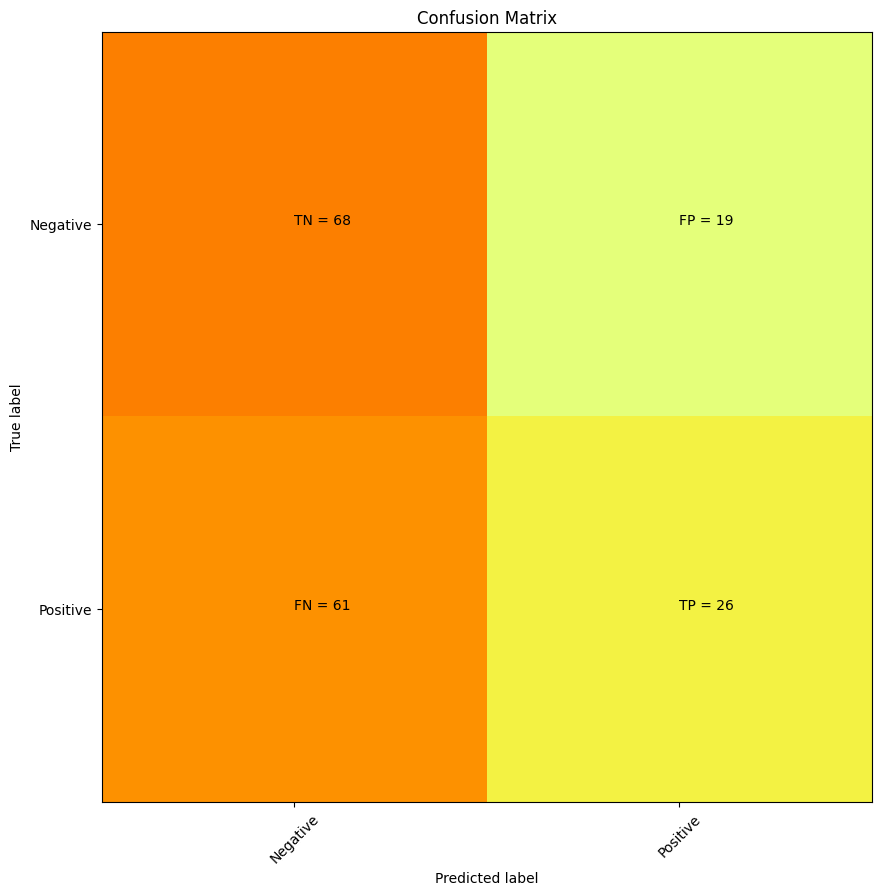

['All', 'CXCL3'] precision = 0.5777777777777777 recall = 0.2988505747126437
features 122
target 122
(25, 64, 64, 3)
(97, 64, 64, 3)
Epoch 1/10
4/4 [==============================] - 14s 2s/step - loss: 5.1993 - val_loss: 3.8490
Epoch 2/10
4/4 [==============================] - 2s 591ms/step - loss: 5.1691 - val_loss: 3.8490
Epoch 3/10
4/4 [==============================] - 3s 659ms/step - loss: 5.1789 - val_loss: 3.8490
Epoch 4/10
4/4 [==============================] - 4s 1s/step - loss: 5.1570 - val_loss: 3.8490
Epoch 5/10
4/4 [==============================] - 2s 598ms/step - loss: 5.1824 - val_loss: 3.8490
Epoch 6/10
4/4 [==============================] - 2s 596ms/step - loss: 5.1641 - val_loss: 3.8490
Epoch 7/10
4/4 [==============================] - 3s 655ms/step - loss: 5.1761 - val_loss: 3.8490
Epoch 8/10
4/4 [==============================] - 3s 657ms/step - loss: 5.1506 - val_loss: 3.8490
Epoch 9/10
4/4 [==============================] - 4s 931ms/step - loss: 5.2066 - val_loss

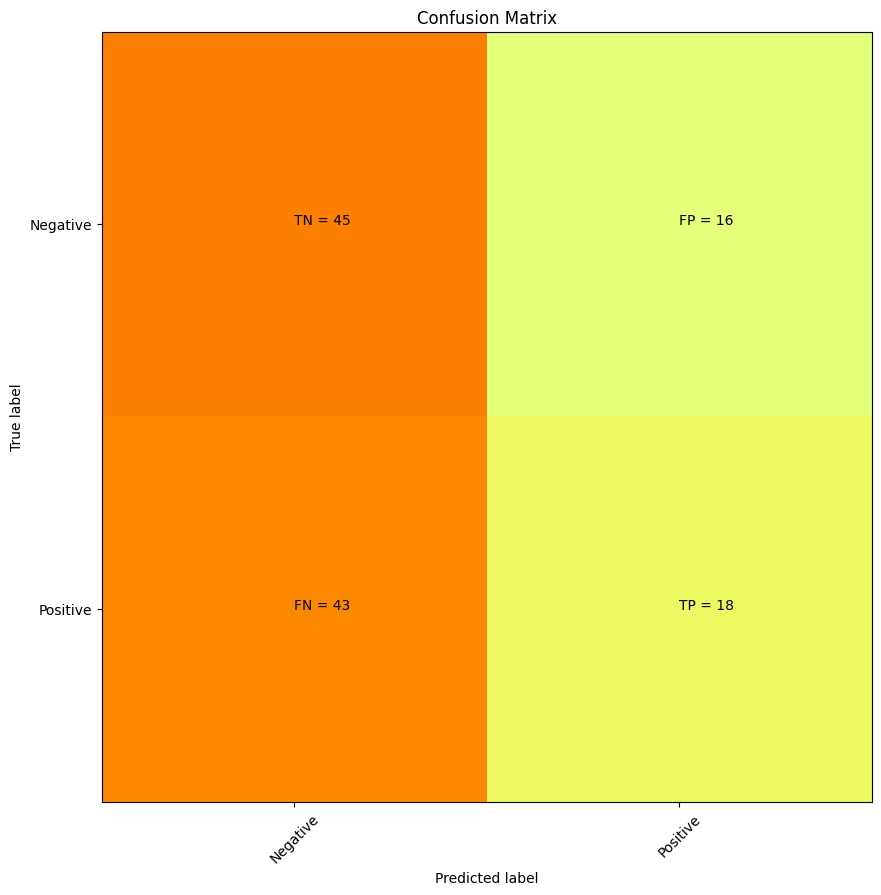

['All', 'CXCL5'] precision = 0.5294117647058824 recall = 0.29508196721311475
features 40
target 40
(8, 64, 64, 3)
(32, 64, 64, 3)
Epoch 1/10
2/2 [==============================] - 14s 4s/step - loss: 5.1216 - val_loss: 4.0282
Epoch 2/10
2/2 [==============================] - 1s 323ms/step - loss: 5.0914 - val_loss: 4.0282
Epoch 3/10
2/2 [==============================] - 1s 439ms/step - loss: 5.1492 - val_loss: 4.0282
Epoch 4/10
2/2 [==============================] - 1s 443ms/step - loss: 5.1020 - val_loss: 4.0282
Epoch 5/10
2/2 [==============================] - 1s 446ms/step - loss: 5.1326 - val_loss: 4.0282
Epoch 6/10
2/2 [==============================] - 1s 451ms/step - loss: 5.0699 - val_loss: 4.0282
Epoch 7/10
2/2 [==============================] - 1s 445ms/step - loss: 5.1206 - val_loss: 4.0282
Epoch 8/10
2/2 [==============================] - 1s 500ms/step - loss: 5.0312 - val_loss: 4.0282
Epoch 9/10
2/2 [==============================] - 1s 493ms/step - loss: 5.0696 - val_los

['All', 'G-CSF'] precision = 0.5555555555555556 recall = 0.25
features 16
target 16
(4, 64, 64, 3)
(12, 64, 64, 3)
Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 5.5763 - val_loss: 3.5092
Epoch 2/10
1/1 [==============================] - 0s 463ms/step - loss: 5.4576 - val_loss: 3.5092
Epoch 3/10
1/1 [==============================] - 0s 445ms/step - loss: 5.5830 - val_loss: 3.5092
Epoch 4/10
1/1 [==============================] - 1s 748ms/step - loss: 5.5192 - val_loss: 3.5092
Epoch 5/10
1/1 [==============================] - 1s 818ms/step - loss: 5.5147 - val_loss: 3.5092
Epoch 6/10
1/1 [==============================] - 1s 808ms/step - loss: 5.4508 - val_loss: 3.5092
Epoch 7/10
1/1 [==============================] - 1s 626ms/step - loss: 5.5677 - val_loss: 3.5092
Epoch 8/10
1/1 [==============================] - 0s 456ms/step - loss: 5.4846 - val_loss: 3.5092
Epoch 9/10
1/1 [==============================] - 0s 428ms/step - loss: 5.4980 - val_loss: 3.5092
Epoc

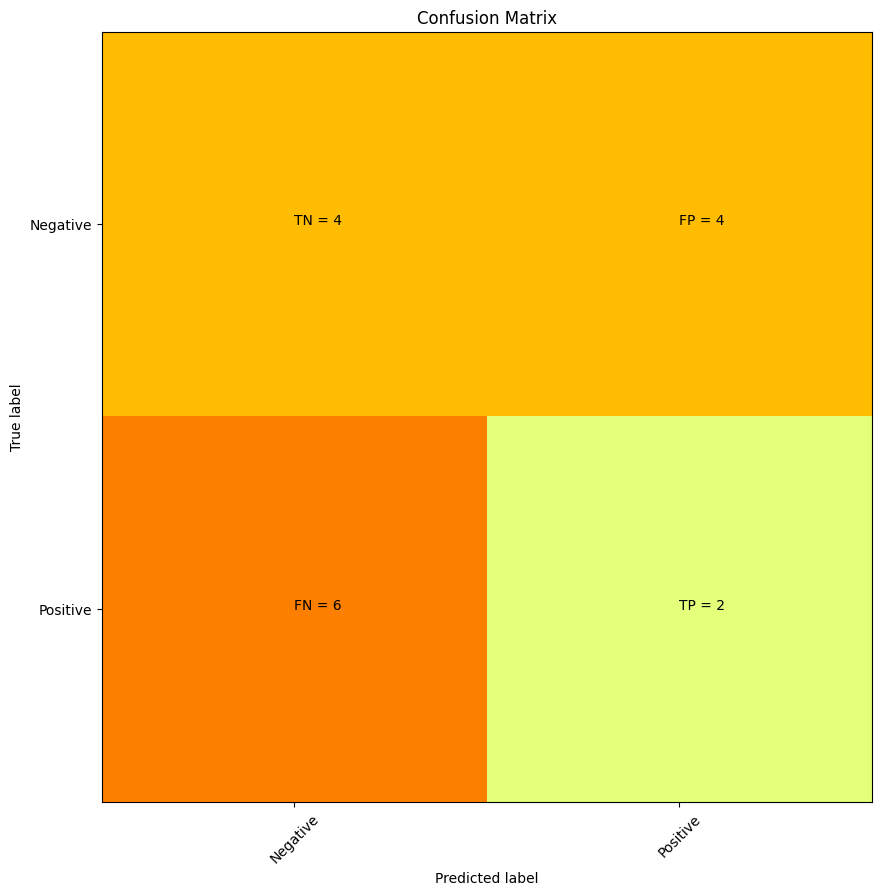

['All', 'GM-CSF'] precision = 0.3333333333333333 recall = 0.25
features 110
target 110
(22, 64, 64, 3)
(88, 64, 64, 3)
Epoch 1/10
3/3 [==============================] - 13s 2s/step - loss: 4.8963 - val_loss: 5.0197
Epoch 2/10
3/3 [==============================] - 4s 2s/step - loss: 4.9081 - val_loss: 5.0197
Epoch 3/10
3/3 [==============================] - 2s 864ms/step - loss: 4.8948 - val_loss: 5.0197
Epoch 4/10
3/3 [==============================] - 2s 744ms/step - loss: 4.9161 - val_loss: 5.0197
Epoch 5/10
3/3 [==============================] - 2s 864ms/step - loss: 4.9228 - val_loss: 5.0197
Epoch 6/10
3/3 [==============================] - 2s 865ms/step - loss: 4.9179 - val_loss: 5.0197
Epoch 7/10
3/3 [==============================] - 4s 1s/step - loss: 4.8776 - val_loss: 5.0197
Epoch 8/10
3/3 [==============================] - 2s 876ms/step - loss: 4.8594 - val_loss: 5.0197
Epoch 9/10
3/3 [==============================] - 2s 743ms/step - loss: 4.8719 - val_loss: 5.0197
Epoch 1

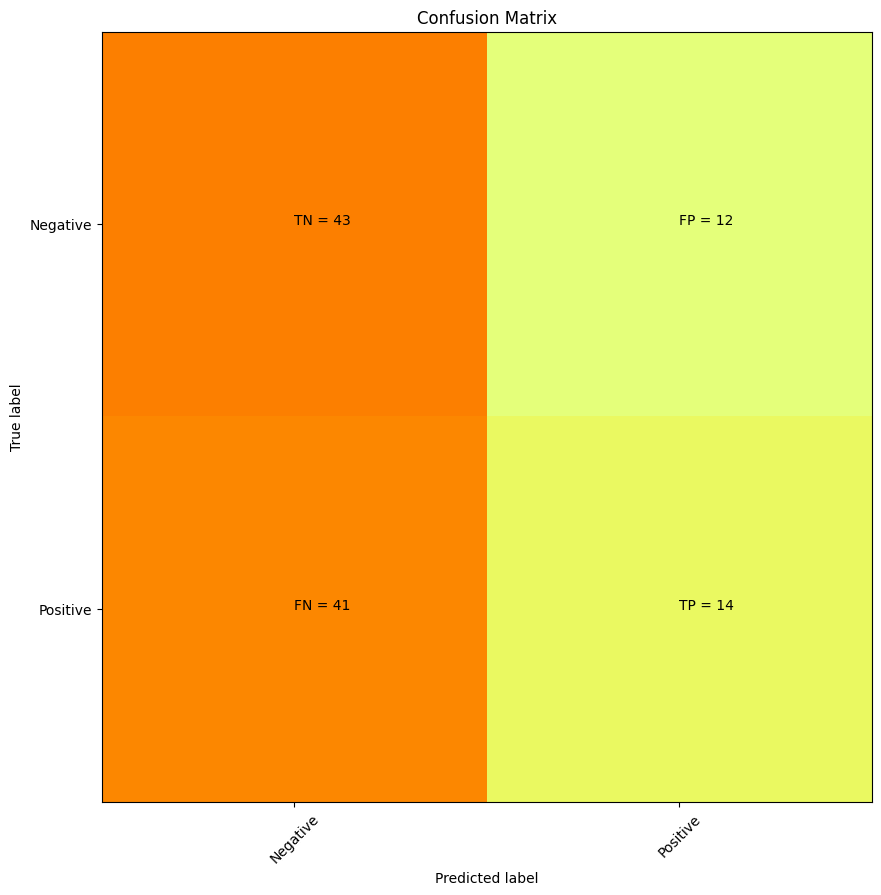

['All', 'IL-1 alpha'] precision = 0.5384615384615384 recall = 0.2545454545454545
features 180
target 180
(36, 64, 64, 3)
(144, 64, 64, 3)
Epoch 1/10
5/5 [==============================] - 15s 2s/step - loss: 4.9233 - val_loss: 5.1473
Epoch 2/10
5/5 [==============================] - 4s 910ms/step - loss: 4.8800 - val_loss: 5.1473
Epoch 3/10
5/5 [==============================] - 4s 852ms/step - loss: 4.8937 - val_loss: 5.1473
Epoch 4/10
5/5 [==============================] - 4s 855ms/step - loss: 4.8942 - val_loss: 5.1473
Epoch 5/10
5/5 [==============================] - 4s 868ms/step - loss: 4.8998 - val_loss: 5.1473
Epoch 6/10
5/5 [==============================] - 5s 904ms/step - loss: 4.8967 - val_loss: 5.1473
Epoch 7/10
5/5 [==============================] - 4s 851ms/step - loss: 4.9235 - val_loss: 5.1473
Epoch 8/10
5/5 [==============================] - 4s 850ms/step - loss: 4.8936 - val_loss: 5.1473
Epoch 9/10
5/5 [==============================] - 4s 775ms/step - loss: 4.9067 -

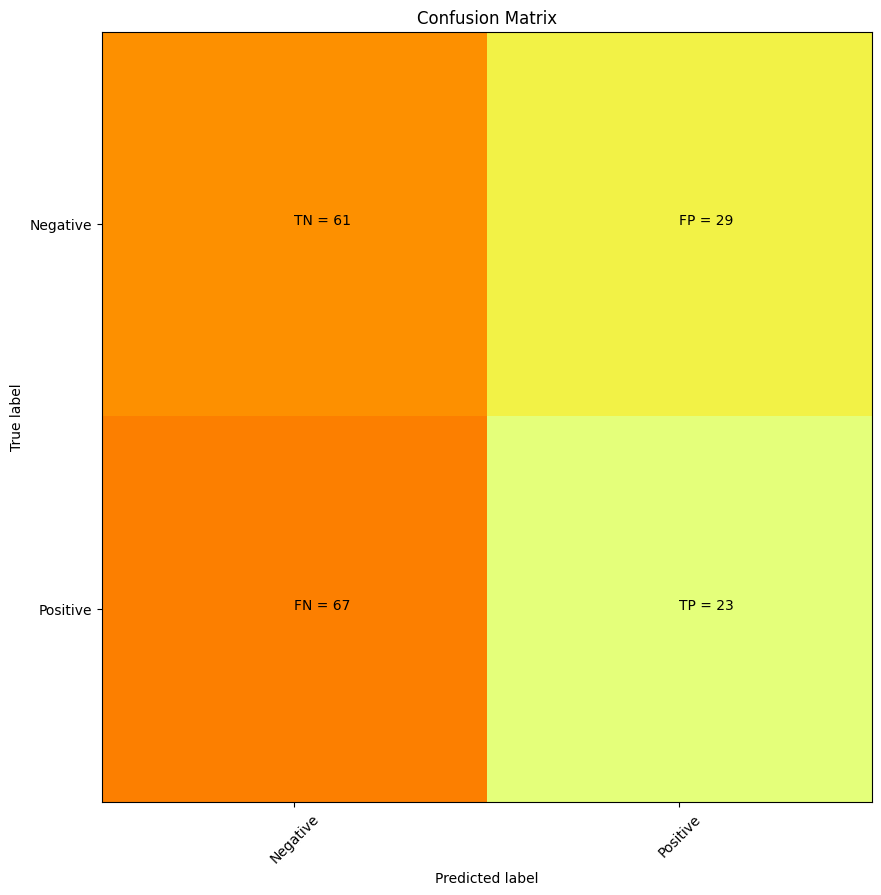

['All', 'IL-1 beta'] precision = 0.4423076923076923 recall = 0.25555555555555554
features 54
target 54
(11, 64, 64, 3)
(43, 64, 64, 3)
Epoch 1/10
2/2 [==============================] - 13s 4s/step - loss: 5.1510 - val_loss: 4.4645
Epoch 2/10
2/2 [==============================] - 1s 634ms/step - loss: 5.1363 - val_loss: 4.4645
Epoch 3/10
2/2 [==============================] - 1s 624ms/step - loss: 5.0893 - val_loss: 4.4645
Epoch 4/10
2/2 [==============================] - 1s 614ms/step - loss: 5.0759 - val_loss: 4.4645
Epoch 5/10
2/2 [==============================] - 1s 615ms/step - loss: 5.1006 - val_loss: 4.4645
Epoch 6/10
2/2 [==============================] - 1s 623ms/step - loss: 5.1798 - val_loss: 4.4645
Epoch 7/10
2/2 [==============================] - 1s 878ms/step - loss: 5.0771 - val_loss: 4.4645
Epoch 8/10
2/2 [==============================] - 2s 909ms/step - loss: 5.0778 - val_loss: 4.4645
Epoch 9/10
2/2 [==============================] - 1s 549ms/step - loss: 5.1472 - va

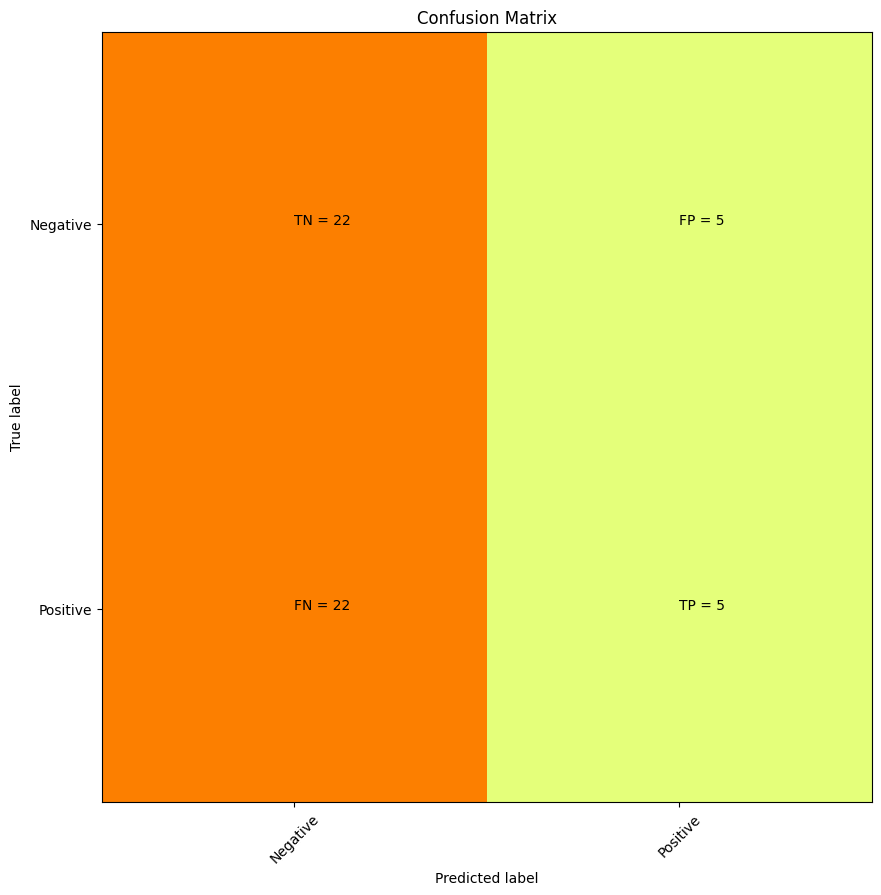

['All', 'IL-12 p40'] precision = 0.5 recall = 0.18518518518518517
features 126
target 126
(26, 64, 64, 3)
(100, 64, 64, 3)
Epoch 1/10
4/4 [==============================] - 16s 2s/step - loss: 4.8701 - val_loss: 5.1156
Epoch 2/10
4/4 [==============================] - 4s 980ms/step - loss: 4.8357 - val_loss: 5.1156
Epoch 3/10
4/4 [==============================] - 3s 675ms/step - loss: 4.8802 - val_loss: 5.1156
Epoch 4/10
4/4 [==============================] - 3s 669ms/step - loss: 4.8368 - val_loss: 5.1156
Epoch 5/10
4/4 [==============================] - 3s 664ms/step - loss: 4.8502 - val_loss: 5.1156
Epoch 6/10
4/4 [==============================] - 3s 666ms/step - loss: 4.8426 - val_loss: 5.1156
Epoch 7/10
4/4 [==============================] - 4s 932ms/step - loss: 4.8187 - val_loss: 5.1156
Epoch 8/10
4/4 [==============================] - 3s 665ms/step - loss: 4.8507 - val_loss: 5.1156
Epoch 9/10
4/4 [==============================] - 2s 606ms/step - loss: 4.8451 - val_loss: 5.11

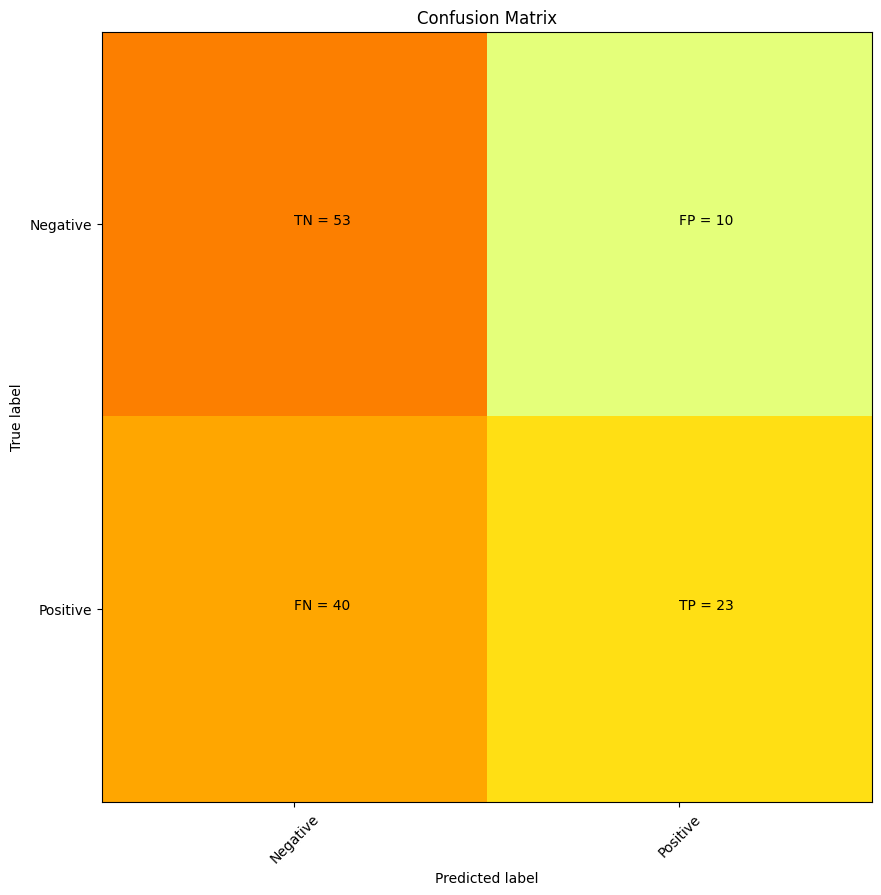

['All', 'IL-16'] precision = 0.696969696969697 recall = 0.36507936507936506
features 136
target 136
(28, 64, 64, 3)
(108, 64, 64, 3)
Epoch 1/10
4/4 [==============================] - 14s 2s/step - loss: 4.9990 - val_loss: 4.6991
Epoch 2/10
4/4 [==============================] - 4s 1s/step - loss: 4.9810 - val_loss: 4.6991
Epoch 3/10
4/4 [==============================] - 3s 701ms/step - loss: 5.0099 - val_loss: 4.6991
Epoch 4/10
4/4 [==============================] - 3s 651ms/step - loss: 4.9723 - val_loss: 4.6991
Epoch 5/10
4/4 [==============================] - 3s 655ms/step - loss: 5.0238 - val_loss: 4.6991
Epoch 6/10
4/4 [==============================] - 3s 914ms/step - loss: 4.9960 - val_loss: 4.6991
Epoch 7/10
4/4 [==============================] - 3s 783ms/step - loss: 4.9583 - val_loss: 4.6991
Epoch 8/10
4/4 [==============================] - 3s 701ms/step - loss: 5.0120 - val_loss: 4.6991
Epoch 9/10
4/4 [==============================] - 3s 644ms/step - loss: 4.9956 - val_los

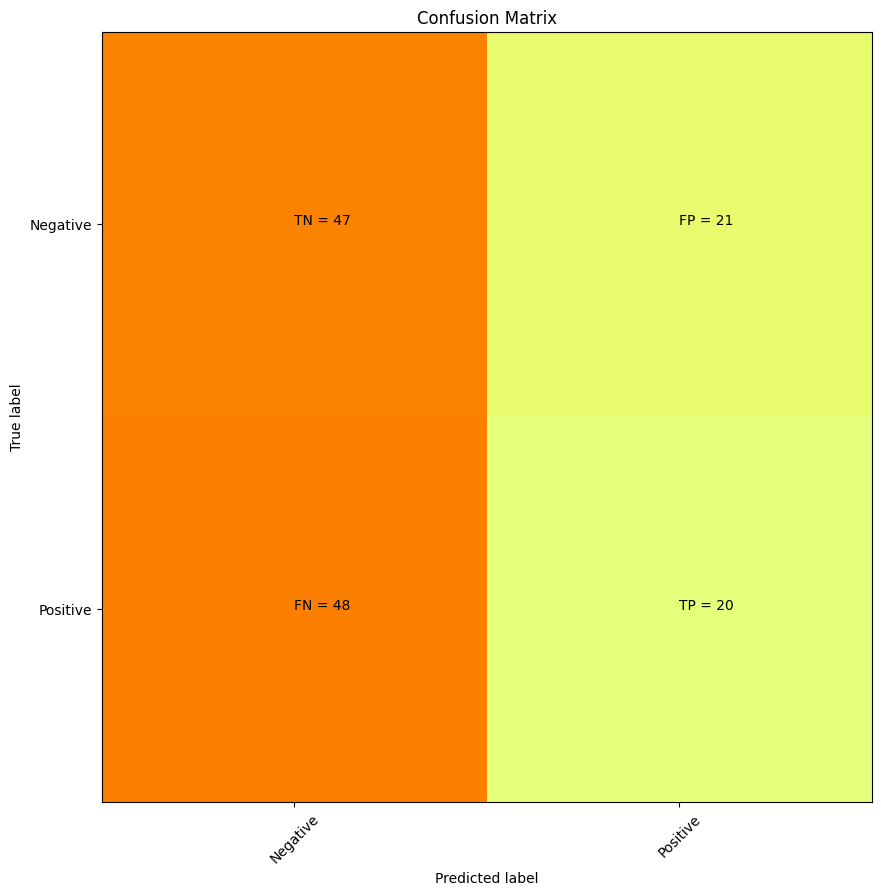

['All', 'IL-6 R alpha'] precision = 0.4878048780487805 recall = 0.29411764705882354
features 322
target 322
(65, 64, 64, 3)
(257, 64, 64, 3)
Epoch 1/10
9/9 [==============================] - 18s 1s/step - loss: 4.9336 - val_loss: 4.7877
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 4.9326 - val_loss: 4.7877
Epoch 3/10
9/9 [==============================] - 6s 686ms/step - loss: 4.9685 - val_loss: 4.7877
Epoch 4/10
9/9 [==============================] - 8s 909ms/step - loss: 4.9170 - val_loss: 4.7877
Epoch 5/10
9/9 [==============================] - 6s 666ms/step - loss: 4.9434 - val_loss: 4.7877
Epoch 6/10
9/9 [==============================] - 8s 980ms/step - loss: 4.9339 - val_loss: 4.7877
Epoch 7/10
9/9 [==============================] - 6s 694ms/step - loss: 4.9270 - val_loss: 4.7877
Epoch 8/10
9/9 [==============================] - 7s 822ms/step - loss: 4.9531 - val_loss: 4.7877
Epoch 9/10
9/9 [==============================] - 6s 689ms/step - loss: 4.9309 -

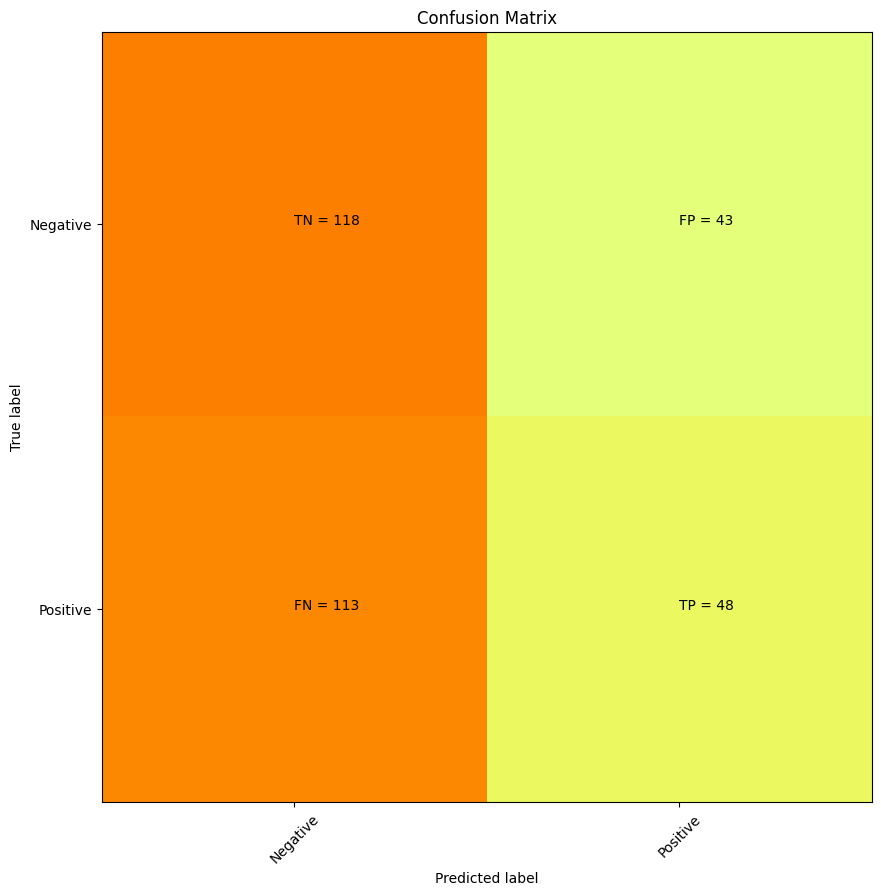

['All', 'IL-6'] precision = 0.5274725274725275 recall = 0.2981366459627329
features 88
target 88
(18, 64, 64, 3)
(70, 64, 64, 3)
Epoch 1/10
3/3 [==============================] - 14s 2s/step - loss: 5.0801 - val_loss: 4.5920
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 5.0221 - val_loss: 4.5920
Epoch 3/10
3/3 [==============================] - 2s 739ms/step - loss: 4.9933 - val_loss: 4.5920
Epoch 4/10
3/3 [==============================] - 2s 738ms/step - loss: 4.9562 - val_loss: 4.5920
Epoch 5/10
3/3 [==============================] - 2s 572ms/step - loss: 5.0493 - val_loss: 4.5920
Epoch 6/10
3/3 [==============================] - 2s 733ms/step - loss: 5.0100 - val_loss: 4.5920
Epoch 7/10
3/3 [==============================] - 2s 729ms/step - loss: 5.0323 - val_loss: 4.5920
Epoch 8/10
3/3 [==============================] - 3s 976ms/step - loss: 4.9808 - val_loss: 4.5920
Epoch 9/10
3/3 [==============================] - 2s 581ms/step - loss: 5.0288 - val_loss: 4

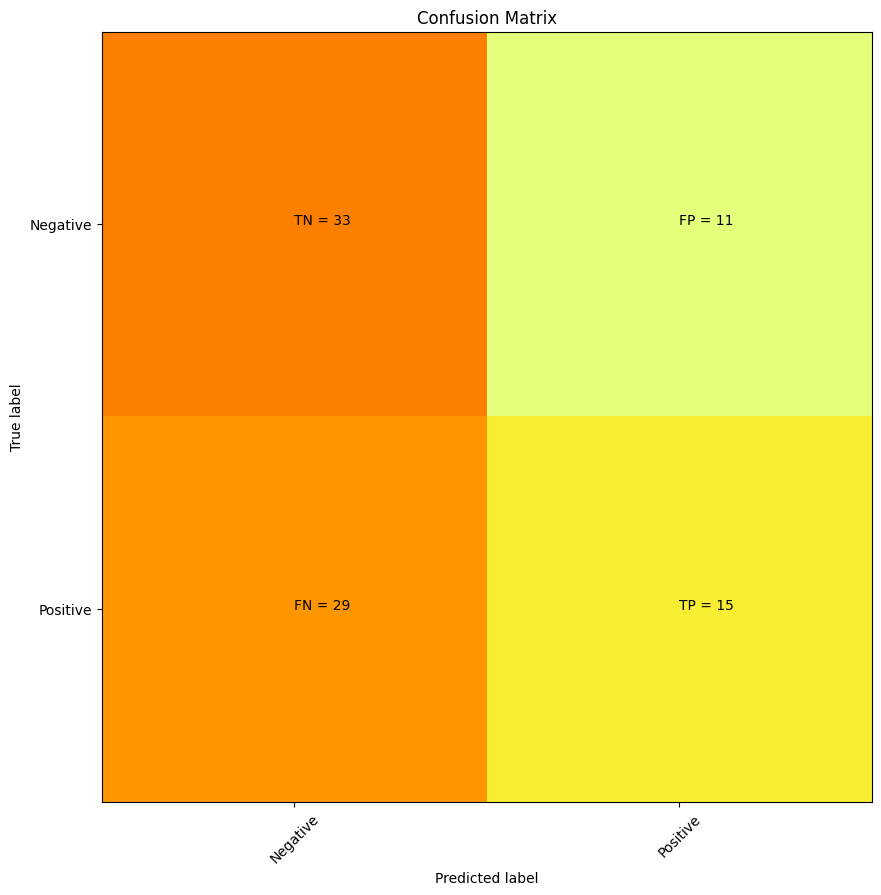

['All', 'IL-8'] precision = 0.5769230769230769 recall = 0.3409090909090909
features 58
target 58
(12, 64, 64, 3)
(46, 64, 64, 3)
Epoch 1/10
2/2 [==============================] - 13s 4s/step - loss: 4.7651 - val_loss: 5.5590
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 4.7914 - val_loss: 5.5590
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 4.7844 - val_loss: 5.5590
Epoch 4/10
2/2 [==============================] - 1s 677ms/step - loss: 4.7754 - val_loss: 5.5590
Epoch 5/10
2/2 [==============================] - 1s 676ms/step - loss: 4.7547 - val_loss: 5.5590
Epoch 6/10
2/2 [==============================] - 1s 603ms/step - loss: 4.6861 - val_loss: 5.5590
Epoch 7/10
2/2 [==============================] - 1s 679ms/step - loss: 4.7777 - val_loss: 5.5590
Epoch 8/10
2/2 [==============================] - 1s 690ms/step - loss: 4.8091 - val_loss: 5.5590
Epoch 9/10
2/2 [==============================] - 1s 597ms/step - loss: 4.7941 - val_loss: 5.55

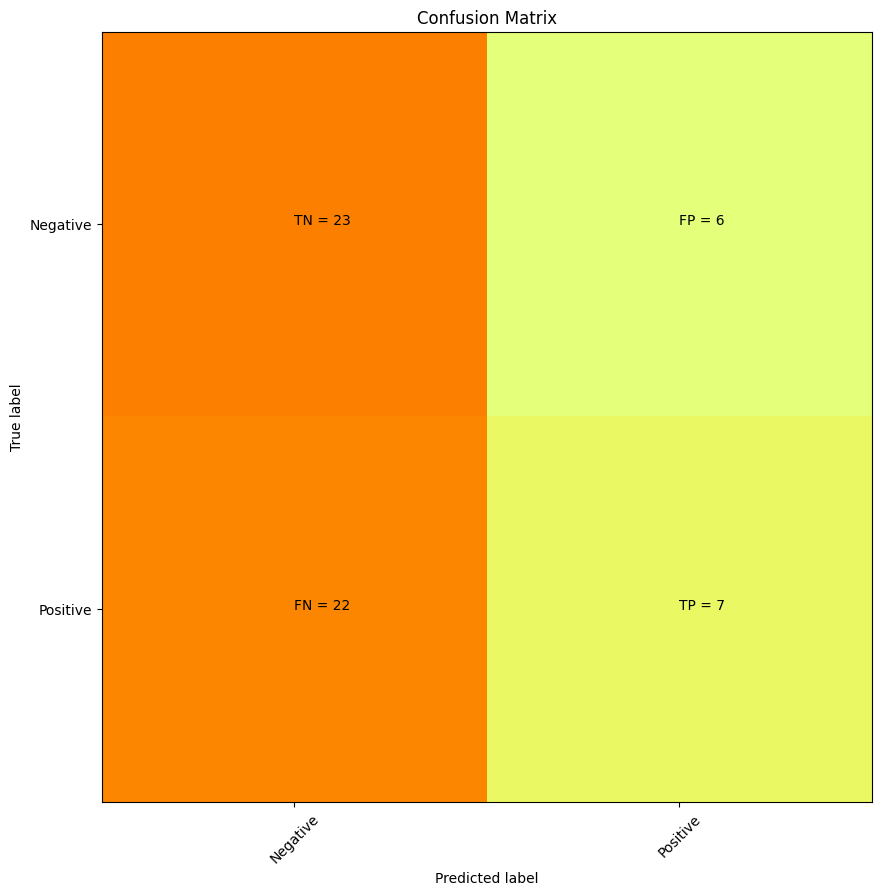

['All', 'MMP-9'] precision = 0.5384615384615384 recall = 0.2413793103448276
features 174
target 174
(35, 64, 64, 3)
(139, 64, 64, 3)
Epoch 1/10
5/5 [==============================] - 16s 2s/step - loss: 4.8347 - val_loss: 5.2054
Epoch 2/10
5/5 [==============================] - 4s 835ms/step - loss: 4.7880 - val_loss: 5.2054
Epoch 3/10
5/5 [==============================] - 3s 673ms/step - loss: 4.8735 - val_loss: 5.2054
Epoch 4/10
5/5 [==============================] - 4s 969ms/step - loss: 4.8349 - val_loss: 5.2054
Epoch 5/10
5/5 [==============================] - 4s 832ms/step - loss: 4.8160 - val_loss: 5.2054
Epoch 6/10
5/5 [==============================] - 4s 829ms/step - loss: 4.8185 - val_loss: 5.2054
Epoch 7/10
5/5 [==============================] - 4s 873ms/step - loss: 4.8178 - val_loss: 5.2054
Epoch 8/10
5/5 [==============================] - 4s 705ms/step - loss: 4.8296 - val_loss: 5.2054
Epoch 9/10
5/5 [==============================] - 3s 675ms/step - loss: 4.8575 - val_

['All', 'TNF RII'] precision = 0.5476190476190477 recall = 0.26436781609195403
features 124
target 124
(25, 64, 64, 3)
(99, 64, 64, 3)
Epoch 1/10
4/4 [==============================] - 17s 2s/step - loss: 5.1071 - val_loss: 4.4283
Epoch 2/10
4/4 [==============================] - 3s 676ms/step - loss: 5.0583 - val_loss: 4.4283
Epoch 3/10
4/4 [==============================] - 3s 661ms/step - loss: 5.0920 - val_loss: 4.4283
Epoch 4/10
4/4 [==============================] - 3s 668ms/step - loss: 5.0639 - val_loss: 4.4283
Epoch 5/10
4/4 [==============================] - 4s 855ms/step - loss: 5.0977 - val_loss: 4.4283
Epoch 6/10
4/4 [==============================] - 2s 605ms/step - loss: 5.0658 - val_loss: 4.4283
Epoch 7/10
4/4 [==============================] - 2s 611ms/step - loss: 5.0783 - val_loss: 4.4283
Epoch 8/10
4/4 [==============================] - 3s 674ms/step - loss: 5.0812 - val_loss: 4.4283
Epoch 9/10
4/4 [==============================] - 3s 711ms/step - loss: 5.0662 - va

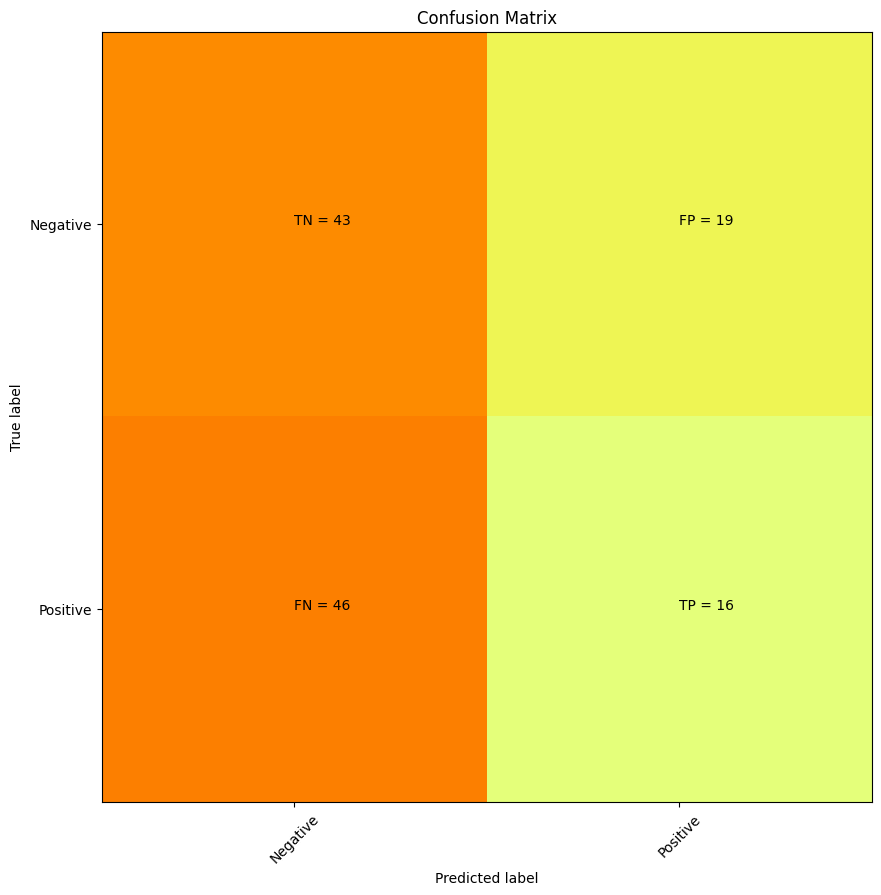

['All', 'TNF alpha'] precision = 0.45714285714285713 recall = 0.25806451612903225


In [93]:
from keras.layers import LeakyReLU

totalresultsvit_simple_again = []


for df in longdfs:
  indices = list(df.index.values)
  features = []

  for i in indices:
    thing = total_scaled_arrays[i]
    features.append(thing)
    # thing2 = total_scaled_arrays[i+384]
    # features.append(thing2)
    # thing3 = total_scaled_arrays[i+384+384]
    # features.append(thing3)
    # thing4 = total_scaled_arrays[i+384+384+384]
    # features.append(thing4)


  target = list(df.iloc[:,0:1].values)
  target2final = target

  target2 = [target for i in range(4)]
  #this is 2 arrays
  #put them together without separation to match structure of features
  # target2final = []
  # for i in target2:
  #   target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.2)


  #reshaping gray scale images so that we can use the RGB transformer

  for i in range(len(X_test)):
    X_test[i] = np.stack((X_test[i],)*3, axis=-1)
    X_test[i] = np.squeeze(X_test[i])

  for i in range(len(X_train)):
    X_train[i] = np.stack((X_train[i],)*3, axis=-1)
    X_train[i] = np.squeeze(X_train[i])


  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  print(test_images.shape)
  print(train_images.shape)

#get a model for each cytokine

  # vitmodel_temp = tf.keras.models.clone_model(vitmodel)

#cant figure out how to clone this one, don't think this will work???? (ie, it will keep training instead of reverting back to default and starting over)
  vitmodel_temp = vit_model

  vitmodel_temp.compile(optimizer='adam', loss='binary_crossentropy')


  vitmodel_temp.fit(train_images, train_labels, epochs=10,
            validation_data=(test_images, test_labels), batch_size=30)

#get predictions

  preds = []
  for i in range(len(features)):
    single = features[i]
    single = np.stack((single,)*3, axis=-1)
    single = np.squeeze(single)
    single = np.expand_dims(single, axis=0)
    preds.append(vitmodel_temp.predict(single))
  preds

  #this part of the code has changed slightly to accomodate the new single number output
  answer = []
  for i in range(len(preds)):
    if preds[i][0][0]<=0.5:
      answer.append(0)
    else:
      answer.append(1)
  answer

  precision, recall = confusio_matrix(target2final,answer, ['All',df.columns[0]])

  f1_score = 2*(precision*recall)/(precision+recall)

  totalresultsvit_simple_again.append([df.columns[0],precision, recall, f1_score])

#summarize metrics

summarizer_totalvit_simple_again = pd.DataFrame(columns =["Cytokine", "Precision", "Recall", "F1 Score", "Augmentation"])

for i in range(len(totalresultsvit_simple_again)):
  f1_score = totalresultsvit_simple_again[i][3]
  precision = totalresultsvit_simple_again[i][1]
  recall = totalresultsvit_simple_again[i][2]
  cytokine = totalresultsvit_simple_again[i][0]
  augmentation = "None"
  tracking = [cytokine, precision, recall, f1_score, augmentation]
  summarizer_totalvit_simple_again.loc[len(summarizer_totalvit_simple_again.index)] = tracking

# summarizer_totalvit_simple

In [94]:
summarizer_totalvit_simple_again

Cytokine  Precision    Recall  F1 Score Augmentation
0      Activin A   0.541667  0.276596  0.366197         None
1           CCL1   0.516129  0.347826  0.415584         None
2          CCL19   0.571429  0.333333  0.421053         None
3           CCL2   0.530612  0.273684  0.361111         None
4          CCL20   0.769231  0.333333  0.465116         None
5          CCL22   0.600000  0.360000  0.450000         None
6           CCL4   0.482759  0.304348  0.373333         None
7           CCL5   0.529412  0.270677  0.358209         None
8           CD14   0.512821  0.327869  0.400000         None
9            CRP   0.521739  0.279070  0.363636         None
10         CXCL1   0.466667  0.325581  0.383562         None
11        CXCL10   0.750000  0.352941  0.480000         None
12        CXCL13   0.666667  0.285714  0.400000         None
13         CXCL3   0.577778  0.298851  0.393939         None
14         CXCL5   0.529412  0.295082  0.378947         None
15         G-CSF   0.555556  0.250000  0.344828         None
16        GM-CSF   0.333333  0.250000  0.285714         None
17    IL-1 alpha   0.538462  0.254545  0.345679         None
18     IL-1 beta   0.442308  0.255556  0.323944         None
19     IL-12 p40   0.500000  0.185185  0.270270         None
20         IL-16   0.696970  0.365079  0.479167         None
21  IL-6 R alpha   0.487805  0.294118  0.366972         None
22          IL-6   0.527473  0.298137  0.380952         None
23          IL-8   0.576923  0.340909  0.428571         None
24         MMP-9   0.538462  0.241379  0.333333         None
25       TNF RII   0.547619  0.264368  0.356589         None
26     TNF alpha   0.457143  0.258065  0.329897         None

In [95]:
summarizer_totalvit_simple_again[summarizer_totalvit_simple_again["Precision"]>0.65]

Cytokine  Precision    Recall  F1 Score Augmentation
4     CCL20   0.769231  0.333333  0.465116         None
11   CXCL10   0.750000  0.352941  0.480000         None
12   CXCL13   0.666667  0.285714  0.400000         None
20    IL-16   0.696970  0.365079  0.479167         None

Still none are predictable.

Ok, just to check, try not min/maxing them...
Nope, this is terrible!

In [12]:
#we must change shape from (64,64) to (64, 64, 1) to tell tensorflow that there is one channel
#for later processing
# (shown in pseudocolor above)
expanded_arrays = all_arrays.copy()
expanded_arrays[0][0].shape
for each in expanded_arrays:
  for i in range(len(each)):
    each[i] = np.expand_dims(each[i], axis=2)
  print(len(expanded_arrays))
  print(len(expanded_arrays[0]))
  print(expanded_arrays[0][0].shape)

4
384
(64, 64, 1)
4
384
(64, 64, 1)
4
384
(64, 64, 1)
4
384
(64, 64, 1)


In [13]:
#so now the arrays are ready to go
#we can put them together in groups to see which augmentations help vs the original image performance

og_arrays = expanded_arrays[0].copy()

ogh_arrays = expanded_arrays[0].copy() + expanded_arrays[1].copy()

ogv_arrays = expanded_arrays[0].copy() + expanded_arrays[2].copy()

ogb_arrays = expanded_arrays[0].copy() + expanded_arrays[3].copy()

total_arrays = expanded_arrays[0].copy() + expanded_arrays[1].copy()+ expanded_arrays[2].copy()+ expanded_arrays[3].copy()

print(len(og_arrays), len(ogh_arrays), len(ogv_arrays), len(ogb_arrays), len(total_arrays))

384 768 768 768 1536


features 376
target 376
(76, 64, 64, 3)
(300, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 14s 867ms/step - loss: 4.7121 - val_loss: 5.1900
Epoch 2/10
10/10 [==============================] - 5s 479ms/step - loss: 4.7183 - val_loss: 5.1900
Epoch 3/10
10/10 [==============================] - 5s 543ms/step - loss: 4.7289 - val_loss: 5.1900
Epoch 4/10
10/10 [==============================] - 5s 478ms/step - loss: 4.6981 - val_loss: 5.1900
Epoch 5/10
10/10 [==============================] - 5s 519ms/step - loss: 4.7161 - val_loss: 5.1900
Epoch 6/10
10/10 [==============================] - 5s 483ms/step - loss: 4.7094 - val_loss: 5.1900
Epoch 7/10
10/10 [==============================] - 5s 481ms/step - loss: 4.7120 - val_loss: 5.1900
Epoch 8/10
10/10 [==============================] - 5s 542ms/step - loss: 4.7080 - val_loss: 5.1900
Epoch 9/10
10/10 [==============================] - 5s 477ms/step - loss: 4.7199 - val_loss: 5.1900
Epoch 10/10
1/1 [=========================

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


['All', 'Activin A'] precision = nan recall = 0.0
features 368
target 368
(74, 64, 64, 3)
(294, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 12s 760ms/step - loss: 4.7949 - val_loss: 4.9138
Epoch 2/10
10/10 [==============================] - 5s 515ms/step - loss: 4.7940 - val_loss: 4.9138
Epoch 3/10
10/10 [==============================] - 5s 539ms/step - loss: 4.7937 - val_loss: 4.9138
Epoch 4/10
10/10 [==============================] - 5s 482ms/step - loss: 4.7990 - val_loss: 4.9138
Epoch 5/10
10/10 [==============================] - 5s 520ms/step - loss: 4.7967 - val_loss: 4.9138
Epoch 6/10
10/10 [==============================] - 5s 490ms/step - loss: 4.7973 - val_loss: 4.9138
Epoch 7/10
10/10 [==============================] - 5s 486ms/step - loss: 4.7902 - val_loss: 4.9138
Epoch 8/10
10/10 [==============================] - 5s 540ms/step - loss: 4.7896 - val_loss: 4.9138
Epoch 9/10
10/10 [==============================] - 5s 479ms/step - loss: 4.7900 - val_loss:

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


['All', 'CCL1'] precision = nan recall = 0.0
features 96
target 96
(20, 64, 64, 3)
(76, 64, 64, 3)
Epoch 1/10
3/3 [==============================] - 9s 2s/step - loss: 4.7966 - val_loss: 4.8429
Epoch 2/10
3/3 [==============================] - 1s 446ms/step - loss: 4.7954 - val_loss: 4.8429
Epoch 3/10
3/3 [==============================] - 1s 440ms/step - loss: 4.8084 - val_loss: 4.8429
Epoch 4/10
3/3 [==============================] - 1s 448ms/step - loss: 4.8248 - val_loss: 4.8429
Epoch 5/10
3/3 [==============================] - 1s 439ms/step - loss: 4.7899 - val_loss: 4.8429
Epoch 6/10
3/3 [==============================] - 1s 442ms/step - loss: 4.7916 - val_loss: 4.8429
Epoch 7/10
3/3 [==============================] - 1s 439ms/step - loss: 4.8121 - val_loss: 4.8429
Epoch 8/10
3/3 [==============================] - 1s 441ms/step - loss: 4.8472 - val_loss: 4.8429
Epoch 9/10
3/3 [==============================] - 2s 761ms/step - loss: 4.8116 - val_loss: 4.8429
Epoch 10/10
1/1 [=====

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


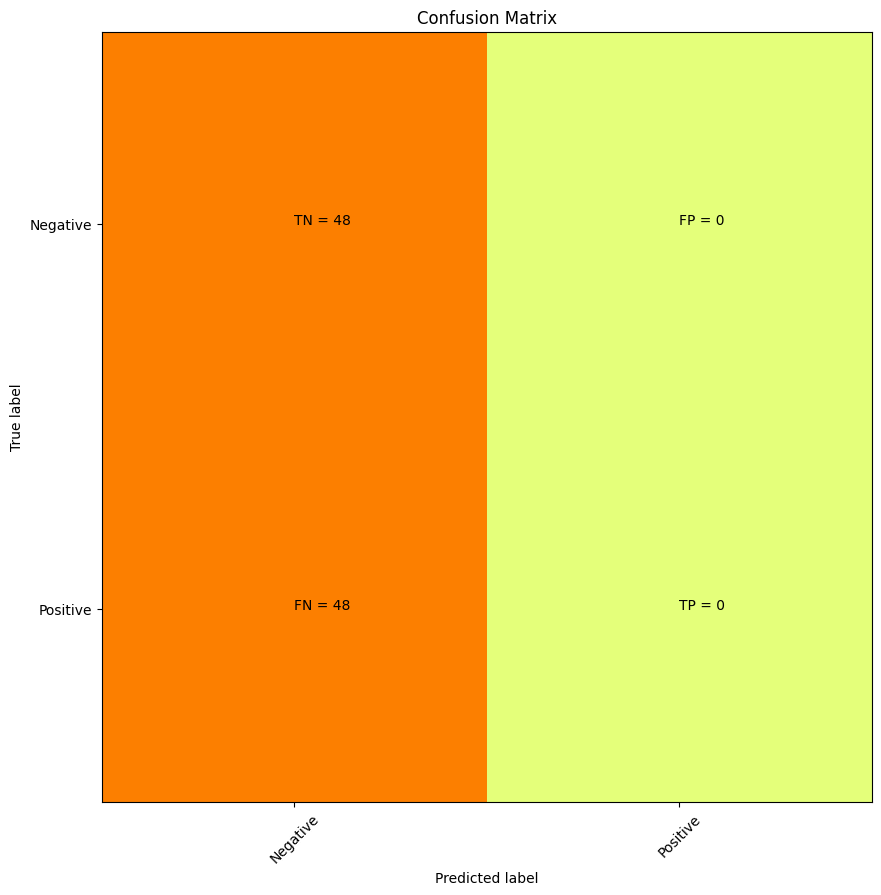

['All', 'CCL19'] precision = nan recall = 0.0
features 760
target 760
(152, 64, 64, 3)
(608, 64, 64, 3)
Epoch 1/10
21/21 [==============================] - 17s 594ms/step - loss: 4.8422 - val_loss: 4.6659
Epoch 2/10
21/21 [==============================] - 10s 473ms/step - loss: 4.8468 - val_loss: 4.6659
Epoch 3/10
21/21 [==============================] - 10s 493ms/step - loss: 4.8324 - val_loss: 4.6659
Epoch 4/10
21/21 [==============================] - 10s 496ms/step - loss: 4.8400 - val_loss: 4.6659
Epoch 5/10
21/21 [==============================] - 10s 495ms/step - loss: 4.8415 - val_loss: 4.6659
Epoch 6/10
21/21 [==============================] - 10s 492ms/step - loss: 4.8486 - val_loss: 4.6659
Epoch 7/10
21/21 [==============================] - 10s 492ms/step - loss: 4.8421 - val_loss: 4.6659
Epoch 8/10
21/21 [==============================] - 11s 506ms/step - loss: 4.8421 - val_loss: 4.6659
Epoch 9/10
21/21 [==============================] - 10s 467ms/step - loss: 4.8386 - val_

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


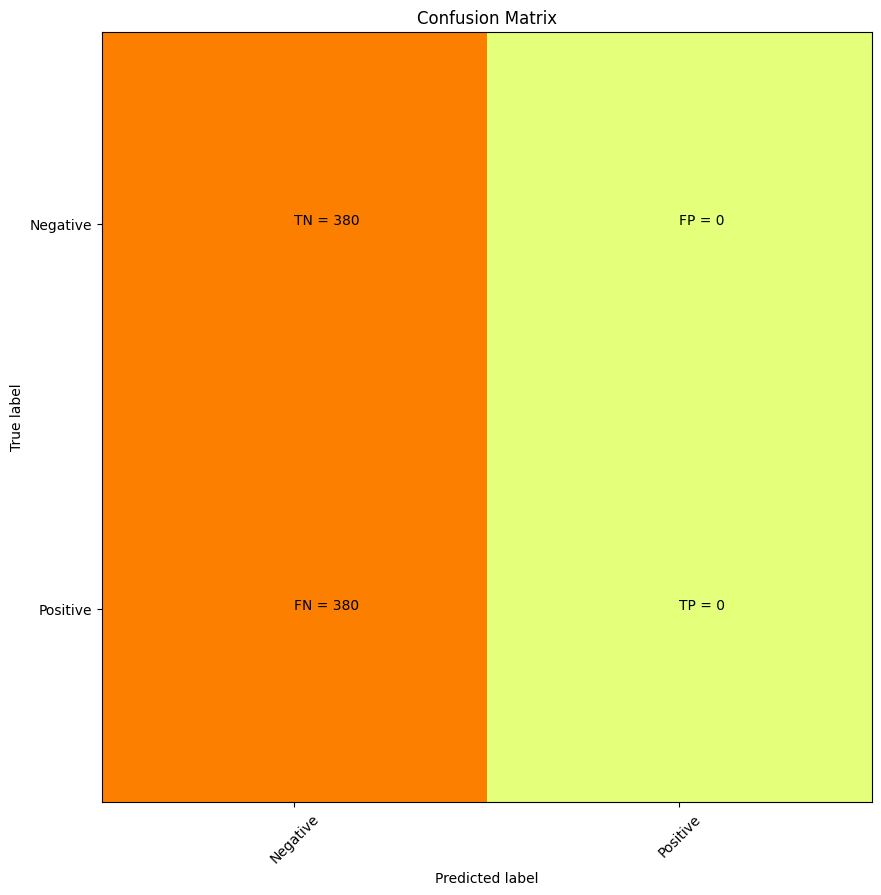

['All', 'CCL2'] precision = nan recall = 0.0
features 240
target 240
(48, 64, 64, 3)
(192, 64, 64, 3)
Epoch 1/10
7/7 [==============================] - 10s 793ms/step - loss: 4.8100 - val_loss: 4.7852
Epoch 2/10
7/7 [==============================] - 3s 447ms/step - loss: 4.8049 - val_loss: 4.7852
Epoch 3/10
7/7 [==============================] - 4s 545ms/step - loss: 4.7961 - val_loss: 4.7852
Epoch 4/10
7/7 [==============================] - 3s 452ms/step - loss: 4.8279 - val_loss: 4.7852
Epoch 5/10
7/7 [==============================] - 3s 450ms/step - loss: 4.8150 - val_loss: 4.7852
Epoch 6/10
7/7 [==============================] - 3s 459ms/step - loss: 4.8122 - val_loss: 4.7852
Epoch 7/10
7/7 [==============================] - 4s 507ms/step - loss: 4.8151 - val_loss: 4.7852
Epoch 8/10
7/7 [==============================] - 3s 450ms/step - loss: 4.8355 - val_loss: 4.7852
Epoch 9/10
7/7 [==============================] - 3s 454ms/step - loss: 4.8276 - val_loss: 4.7852
Epoch 10/10
1/1

['All', 'CCL20'] precision = 1.0 recall = 0.008333333333333333
features 1000
target 1000
(200, 64, 64, 3)
(800, 64, 64, 3)
Epoch 1/10
27/27 [==============================] - 21s 585ms/step - loss: 4.8665 - val_loss: 4.5208
Epoch 2/10
27/27 [==============================] - 14s 500ms/step - loss: 4.8724 - val_loss: 4.5208
Epoch 3/10
27/27 [==============================] - 13s 497ms/step - loss: 4.8840 - val_loss: 4.5208
Epoch 4/10
27/27 [==============================] - 13s 494ms/step - loss: 4.8702 - val_loss: 4.5208
Epoch 5/10
27/27 [==============================] - 13s 497ms/step - loss: 4.8818 - val_loss: 4.5208
Epoch 6/10
27/27 [==============================] - 13s 493ms/step - loss: 4.8743 - val_loss: 4.5208
Epoch 7/10
27/27 [==============================] - 13s 492ms/step - loss: 4.8869 - val_loss: 4.5208
Epoch 8/10
27/27 [==============================] - 13s 496ms/step - loss: 4.8745 - val_loss: 4.5208
Epoch 9/10
27/27 [==============================] - 13s 497ms/step - 

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


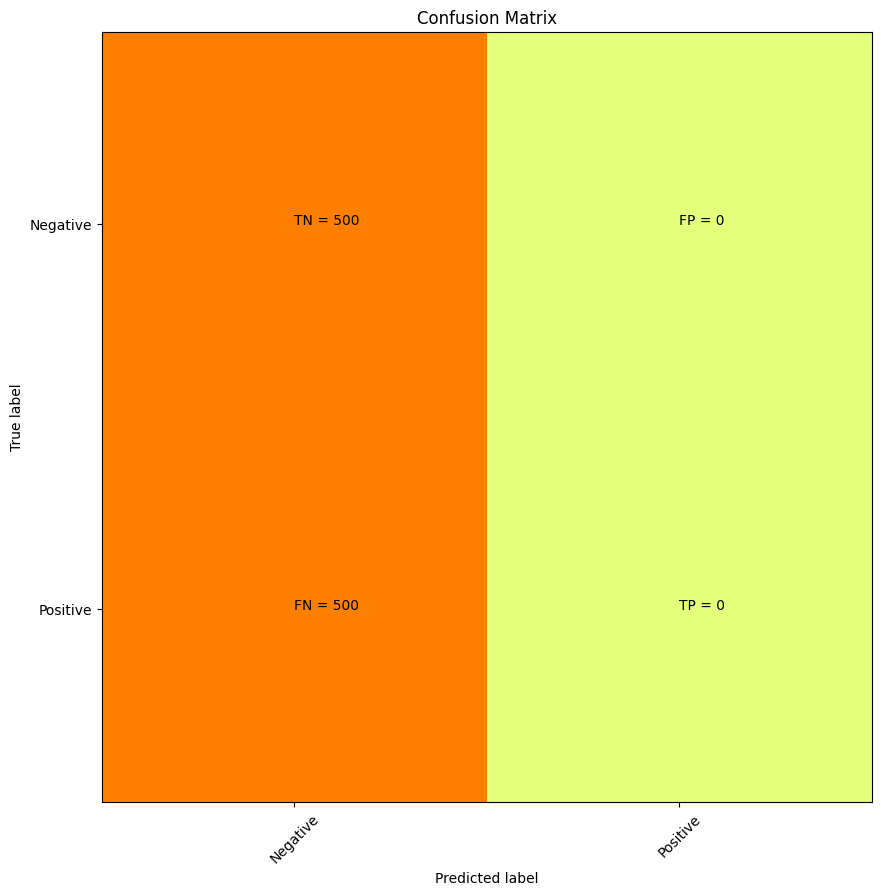

['All', 'CCL22'] precision = nan recall = 0.0
features 368
target 368
(74, 64, 64, 3)
(294, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 13s 747ms/step - loss: 4.7547 - val_loss: 5.0161
Epoch 2/10
10/10 [==============================] - 5s 479ms/step - loss: 4.7514 - val_loss: 5.0161
Epoch 3/10
10/10 [==============================] - 5s 524ms/step - loss: 4.7665 - val_loss: 5.0161
Epoch 4/10
10/10 [==============================] - 5s 484ms/step - loss: 4.7401 - val_loss: 5.0161
Epoch 5/10
10/10 [==============================] - 5s 483ms/step - loss: 4.7649 - val_loss: 5.0161
Epoch 6/10
10/10 [==============================] - 5s 542ms/step - loss: 4.7541 - val_loss: 5.0161
Epoch 7/10
10/10 [==============================] - 5s 481ms/step - loss: 4.7576 - val_loss: 5.0161
Epoch 8/10
10/10 [==============================] - 5s 538ms/step - loss: 4.7441 - val_loss: 5.0161
Epoch 9/10
10/10 [==============================] - 5s 480ms/step - loss: 4.7525 - val_loss: 5.0

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


['All', 'CCL4'] precision = nan recall = 0.0
features 1064
target 1064
(213, 64, 64, 3)
(851, 64, 64, 3)
Epoch 1/10
29/29 [==============================] - 21s 561ms/step - loss: 4.8570 - val_loss: 4.6373
Epoch 2/10
29/29 [==============================] - 14s 491ms/step - loss: 4.8624 - val_loss: 4.6373
Epoch 3/10
29/29 [==============================] - 15s 512ms/step - loss: 4.8623 - val_loss: 4.6373
Epoch 4/10
29/29 [==============================] - 14s 492ms/step - loss: 4.8582 - val_loss: 4.6373
Epoch 5/10
29/29 [==============================] - 14s 490ms/step - loss: 4.8634 - val_loss: 4.6373
Epoch 6/10
29/29 [==============================] - 15s 524ms/step - loss: 4.8573 - val_loss: 4.6373
Epoch 7/10
29/29 [==============================] - 14s 491ms/step - loss: 4.8571 - val_loss: 4.6373
Epoch 8/10
29/29 [==============================] - 14s 494ms/step - loss: 4.8601 - val_loss: 4.6373
Epoch 9/10
29/29 [==============================] - 15s 505ms/step - loss: 4.8521 - val

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


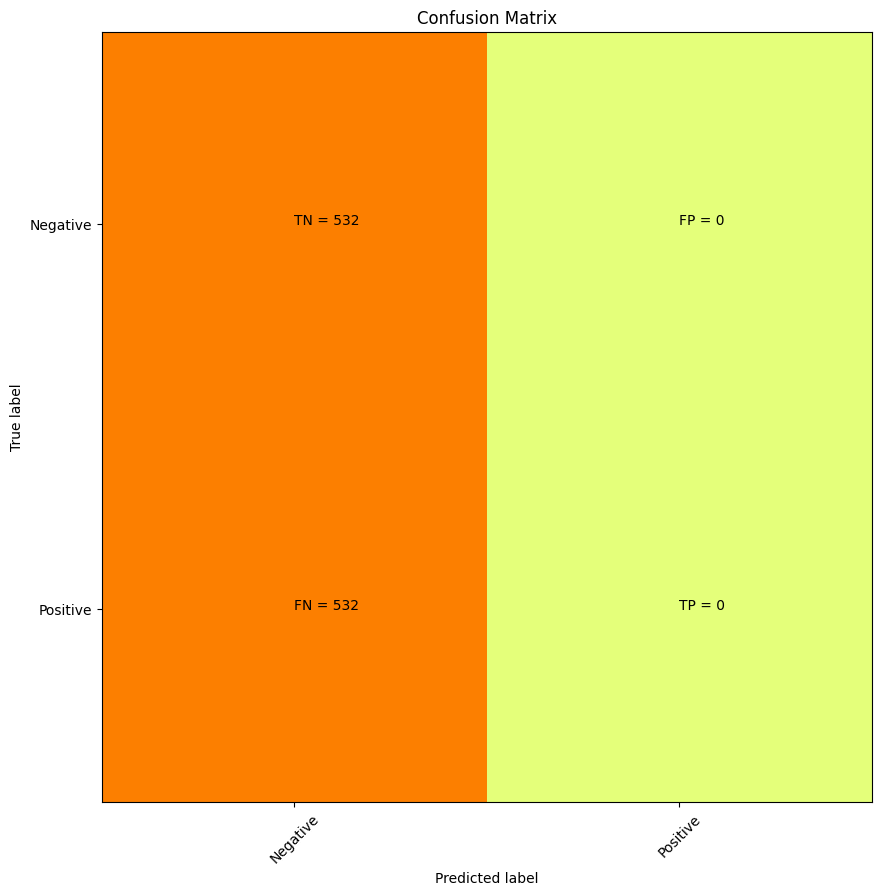

['All', 'CCL5'] precision = nan recall = 0.0
features 488
target 488
(98, 64, 64, 3)
(390, 64, 64, 3)
Epoch 1/10
13/13 [==============================] - 11s 644ms/step - loss: 4.7779 - val_loss: 4.8884
Epoch 2/10
13/13 [==============================] - 7s 508ms/step - loss: 4.7859 - val_loss: 4.8884
Epoch 3/10
13/13 [==============================] - 7s 591ms/step - loss: 4.7971 - val_loss: 4.8884
Epoch 4/10
13/13 [==============================] - 6s 476ms/step - loss: 4.7985 - val_loss: 4.8884
Epoch 5/10
13/13 [==============================] - 7s 522ms/step - loss: 4.7896 - val_loss: 4.8884
Epoch 6/10
13/13 [==============================] - 6s 476ms/step - loss: 4.7910 - val_loss: 4.8884
Epoch 7/10
13/13 [==============================] - 7s 566ms/step - loss: 4.7987 - val_loss: 4.8884
Epoch 8/10
13/13 [==============================] - 6s 473ms/step - loss: 4.7944 - val_loss: 4.8884
Epoch 9/10
13/13 [==============================] - 7s 524ms/step - loss: 4.8012 - val_loss: 4.88

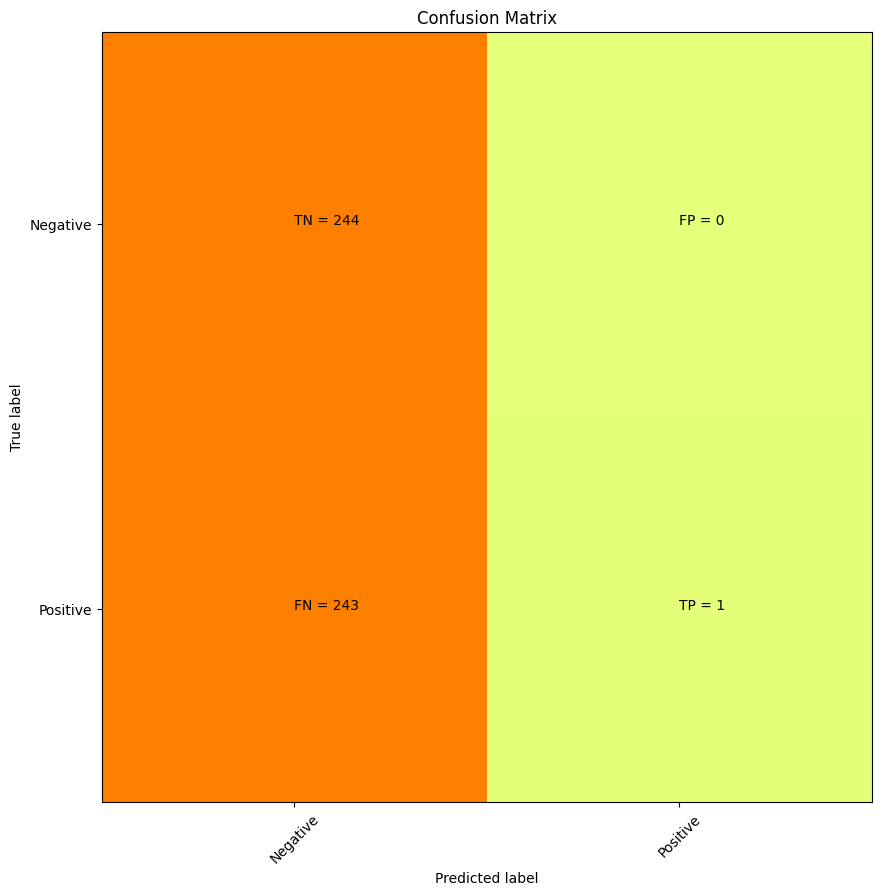

['All', 'CD14'] precision = 1.0 recall = 0.004098360655737705
features 688
target 688
(138, 64, 64, 3)
(550, 64, 64, 3)
Epoch 1/10
19/19 [==============================] - 17s 647ms/step - loss: 4.8415 - val_loss: 4.6500
Epoch 2/10
19/19 [==============================] - 10s 518ms/step - loss: 4.8338 - val_loss: 4.6500
Epoch 3/10
19/19 [==============================] - 10s 518ms/step - loss: 4.8517 - val_loss: 4.6500
Epoch 4/10
19/19 [==============================] - 10s 538ms/step - loss: 4.8360 - val_loss: 4.6500
Epoch 5/10
19/19 [==============================] - 10s 532ms/step - loss: 4.8412 - val_loss: 4.6500
Epoch 6/10
19/19 [==============================] - 9s 475ms/step - loss: 4.8591 - val_loss: 4.6500
Epoch 7/10
19/19 [==============================] - 10s 507ms/step - loss: 4.8456 - val_loss: 4.6500
Epoch 8/10
19/19 [==============================] - 10s 513ms/step - loss: 4.8469 - val_loss: 4.6500
Epoch 9/10
19/19 [==============================] - 10s 520ms/step - loss

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


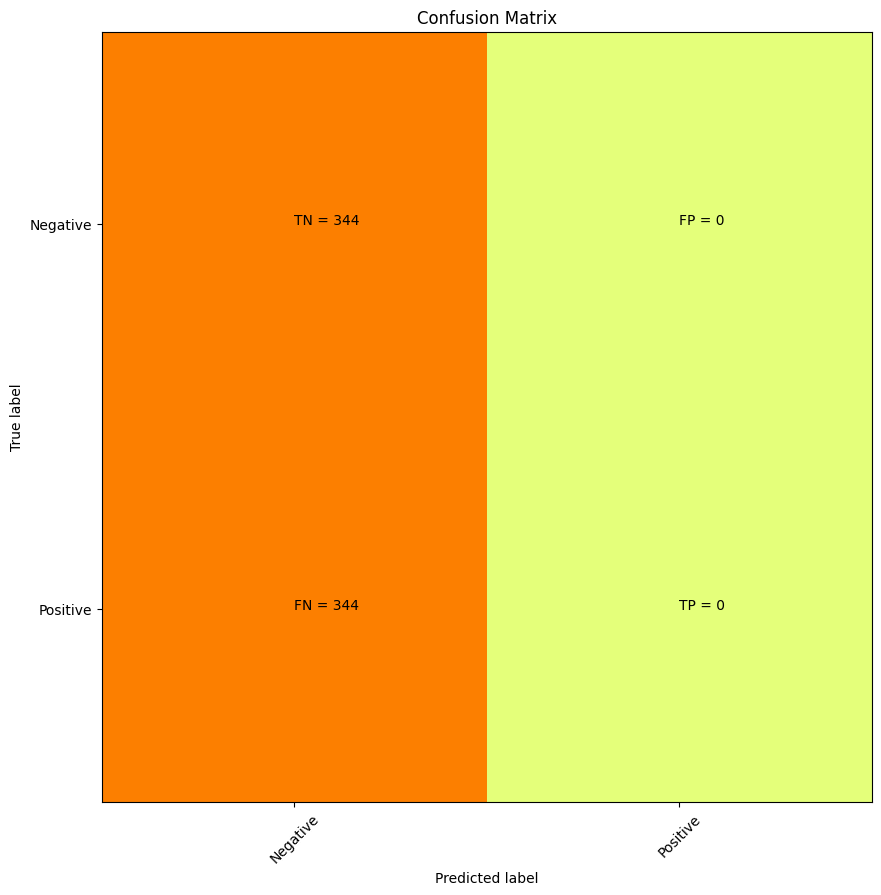

['All', 'CRP'] precision = nan recall = 0.0
features 344
target 344
(69, 64, 64, 3)
(275, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 12s 741ms/step - loss: 4.8386 - val_loss: 4.6605
Epoch 2/10
10/10 [==============================] - 5s 520ms/step - loss: 4.8372 - val_loss: 4.6605
Epoch 3/10
10/10 [==============================] - 5s 534ms/step - loss: 4.8316 - val_loss: 4.6605
Epoch 4/10
10/10 [==============================] - 4s 455ms/step - loss: 4.8350 - val_loss: 4.6605
Epoch 5/10
10/10 [==============================] - 5s 486ms/step - loss: 4.8412 - val_loss: 4.6605
Epoch 6/10
10/10 [==============================] - 5s 478ms/step - loss: 4.8355 - val_loss: 4.6605
Epoch 7/10
10/10 [==============================] - 5s 475ms/step - loss: 4.8320 - val_loss: 4.6605
Epoch 8/10
10/10 [==============================] - 5s 545ms/step - loss: 4.8565 - val_loss: 4.6605
Epoch 9/10
10/10 [==============================] - 5s 476ms/step - loss: 4.8429 - val_loss: 4.660

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


['All', 'CXCL1'] precision = nan recall = 0.0
features 136
target 136
(28, 64, 64, 3)
(108, 64, 64, 3)
Epoch 1/10
4/4 [==============================] - 9s 1s/step - loss: 4.8174 - val_loss: 4.8176
Epoch 2/10
4/4 [==============================] - 2s 465ms/step - loss: 4.8107 - val_loss: 4.8176
Epoch 3/10
4/4 [==============================] - 2s 643ms/step - loss: 4.8235 - val_loss: 4.8176
Epoch 4/10
4/4 [==============================] - 2s 464ms/step - loss: 4.8307 - val_loss: 4.8176
Epoch 5/10
4/4 [==============================] - 2s 465ms/step - loss: 4.8337 - val_loss: 4.8176
Epoch 6/10
4/4 [==============================] - 2s 474ms/step - loss: 4.8084 - val_loss: 4.8176
Epoch 7/10
4/4 [==============================] - 2s 477ms/step - loss: 4.8168 - val_loss: 4.8176
Epoch 8/10
4/4 [==============================] - 2s 464ms/step - loss: 4.8331 - val_loss: 4.8176
Epoch 9/10
4/4 [==============================] - 2s 606ms/step - loss: 4.8155 - val_loss: 4.8176
Epoch 10/10
1/1 [=

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


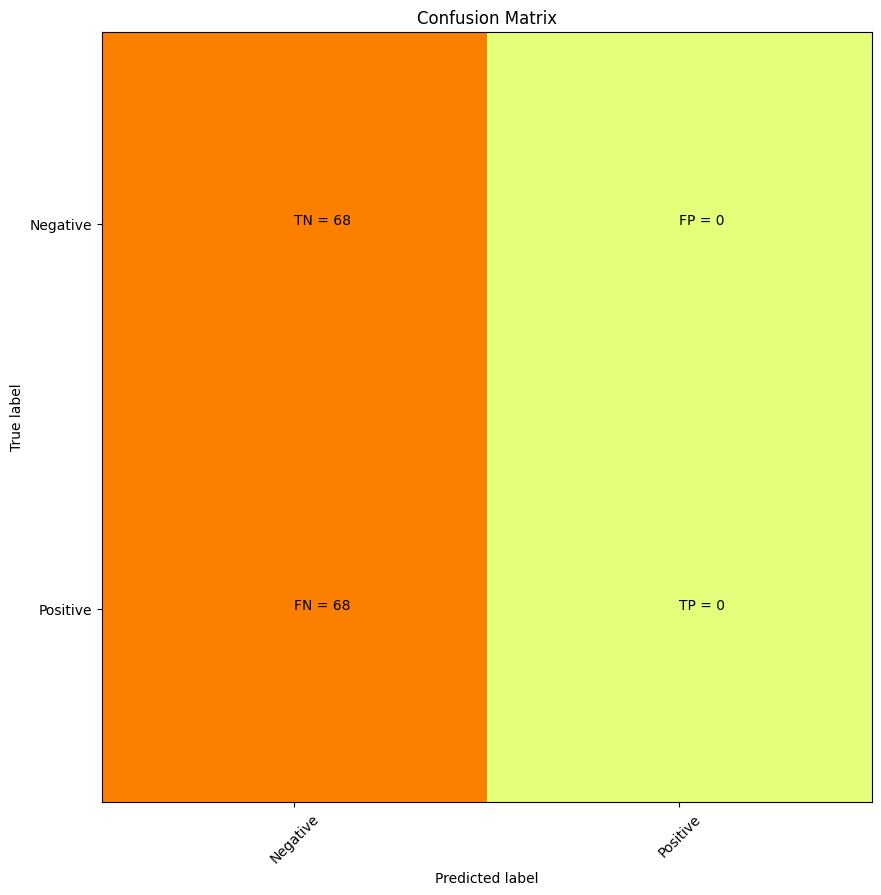

['All', 'CXCL10'] precision = nan recall = 0.0
features 56
target 56
(12, 64, 64, 3)
(44, 64, 64, 3)
Epoch 1/10
2/2 [==============================] - 10s 3s/step - loss: 4.4858 - val_loss: 5.9850
Epoch 2/10
2/2 [==============================] - 1s 393ms/step - loss: 4.4750 - val_loss: 5.9850
Epoch 3/10
2/2 [==============================] - 1s 397ms/step - loss: 4.4474 - val_loss: 5.9850
Epoch 4/10
2/2 [==============================] - 1s 396ms/step - loss: 4.4464 - val_loss: 5.9850
Epoch 5/10
2/2 [==============================] - 1s 390ms/step - loss: 4.4660 - val_loss: 5.9850
Epoch 6/10
2/2 [==============================] - 1s 390ms/step - loss: 4.4781 - val_loss: 5.9850
Epoch 7/10
2/2 [==============================] - 1s 398ms/step - loss: 4.4615 - val_loss: 5.9850
Epoch 8/10
2/2 [==============================] - 1s 396ms/step - loss: 4.4765 - val_loss: 5.9850
Epoch 9/10
2/2 [==============================] - 1s 394ms/step - loss: 4.4937 - val_loss: 5.9850
Epoch 10/10
1/1 [==

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


['All', 'CXCL13'] precision = nan recall = 0.0
features 696
target 696
(140, 64, 64, 3)
(556, 64, 64, 3)
Epoch 1/10
19/19 [==============================] - 18s 635ms/step - loss: 4.8339 - val_loss: 4.7077
Epoch 2/10
19/19 [==============================] - 9s 479ms/step - loss: 4.8466 - val_loss: 4.7077
Epoch 3/10
19/19 [==============================] - 10s 538ms/step - loss: 4.8429 - val_loss: 4.7077
Epoch 4/10
19/19 [==============================] - 10s 507ms/step - loss: 4.8483 - val_loss: 4.7077
Epoch 5/10
19/19 [==============================] - 10s 506ms/step - loss: 4.8523 - val_loss: 4.7077
Epoch 6/10
19/19 [==============================] - 9s 494ms/step - loss: 4.8400 - val_loss: 4.7077
Epoch 7/10
19/19 [==============================] - 9s 484ms/step - loss: 4.8398 - val_loss: 4.7077
Epoch 8/10
19/19 [==============================] - 10s 509ms/step - loss: 4.8428 - val_loss: 4.7077
Epoch 9/10
19/19 [==============================] - 9s 505ms/step - loss: 4.8501 - val_los

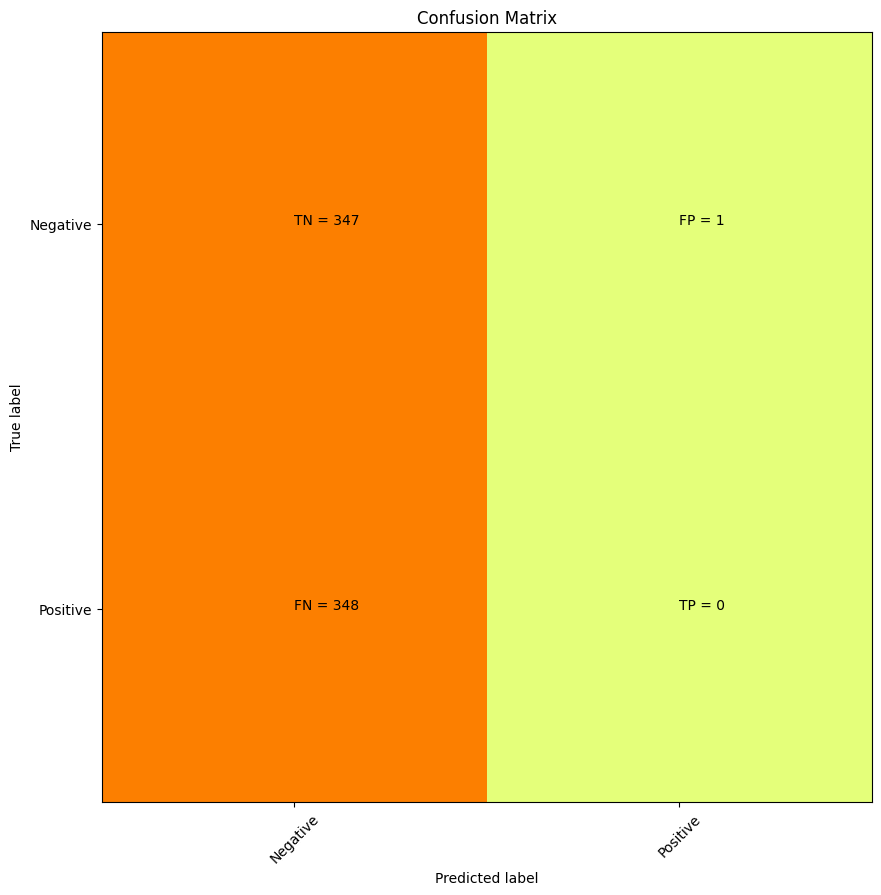

['All', 'CXCL3'] precision = 0.0 recall = 0.0
features 488
target 488
(98, 64, 64, 3)
(390, 64, 64, 3)
Epoch 1/10


<ipython-input-15-1b19d7048a36>:92: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*(precision*recall)/(precision+recall)


13/13 [==============================] - 12s 663ms/step - loss: 4.7120 - val_loss: 5.1764
Epoch 2/10
13/13 [==============================] - 7s 527ms/step - loss: 4.7137 - val_loss: 5.1764
Epoch 3/10
13/13 [==============================] - 6s 470ms/step - loss: 4.7117 - val_loss: 5.1764
Epoch 4/10
13/13 [==============================] - 7s 522ms/step - loss: 4.7199 - val_loss: 5.1764
Epoch 5/10
13/13 [==============================] - 6s 469ms/step - loss: 4.7045 - val_loss: 5.1764
Epoch 6/10
13/13 [==============================] - 7s 522ms/step - loss: 4.7162 - val_loss: 5.1764
Epoch 7/10
13/13 [==============================] - 6s 472ms/step - loss: 4.7183 - val_loss: 5.1764
Epoch 8/10
13/13 [==============================] - 7s 519ms/step - loss: 4.7256 - val_loss: 5.1764
Epoch 9/10
13/13 [==============================] - 6s 471ms/step - loss: 4.7211 - val_loss: 5.1764
Epoch 10/10
1/1 [==============================] - 0s 58ms/step


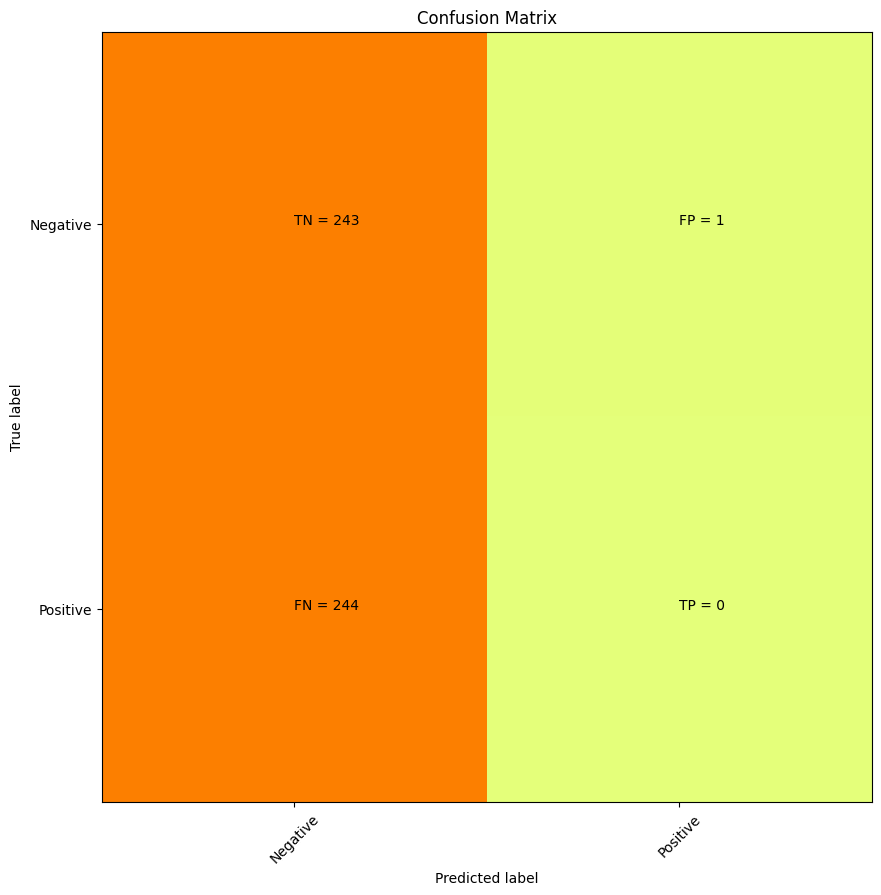

['All', 'CXCL5'] precision = 0.0 recall = 0.0
features 160
target 160
(32, 64, 64, 3)
(128, 64, 64, 3)
Epoch 1/10


<ipython-input-15-1b19d7048a36>:92: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*(precision*recall)/(precision+recall)


5/5 [==============================] - 9s 1s/step - loss: 4.9131 - val_loss: 4.3373
Epoch 2/10
5/5 [==============================] - 2s 442ms/step - loss: 4.9111 - val_loss: 4.3373
Epoch 3/10
5/5 [==============================] - 2s 434ms/step - loss: 4.9136 - val_loss: 4.3373
Epoch 4/10
5/5 [==============================] - 2s 447ms/step - loss: 4.9076 - val_loss: 4.3373
Epoch 5/10
5/5 [==============================] - 2s 499ms/step - loss: 4.9223 - val_loss: 4.3373
Epoch 6/10
5/5 [==============================] - 3s 486ms/step - loss: 4.9292 - val_loss: 4.3373
Epoch 7/10
5/5 [==============================] - 2s 436ms/step - loss: 4.9155 - val_loss: 4.3373
Epoch 8/10
5/5 [==============================] - 2s 436ms/step - loss: 4.9267 - val_loss: 4.3373
Epoch 9/10
5/5 [==============================] - 2s 437ms/step - loss: 4.9179 - val_loss: 4.3373
Epoch 10/10
1/1 [==============================] - 0s 54ms/step


<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


['All', 'G-CSF'] precision = nan recall = 0.0
features 64
target 64
(13, 64, 64, 3)
(51, 64, 64, 3)
Epoch 1/10
2/2 [==============================] - 8s 3s/step - loss: 4.8734 - val_loss: 4.5652
Epoch 2/10
2/2 [==============================] - 1s 485ms/step - loss: 4.8930 - val_loss: 4.5652
Epoch 3/10
2/2 [==============================] - 1s 482ms/step - loss: 4.8558 - val_loss: 4.5652
Epoch 4/10
2/2 [==============================] - 1s 481ms/step - loss: 4.8796 - val_loss: 4.5652
Epoch 5/10
2/2 [==============================] - 1s 495ms/step - loss: 4.9215 - val_loss: 4.5652
Epoch 6/10
2/2 [==============================] - 1s 476ms/step - loss: 4.8812 - val_loss: 4.5652
Epoch 7/10
2/2 [==============================] - 1s 492ms/step - loss: 4.8804 - val_loss: 4.5652
Epoch 8/10
2/2 [==============================] - 1s 482ms/step - loss: 4.9010 - val_loss: 4.5652
Epoch 9/10
2/2 [==============================] - 1s 480ms/step - loss: 4.9007 - val_loss: 4.5652
Epoch 10/10
1/1 [====

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


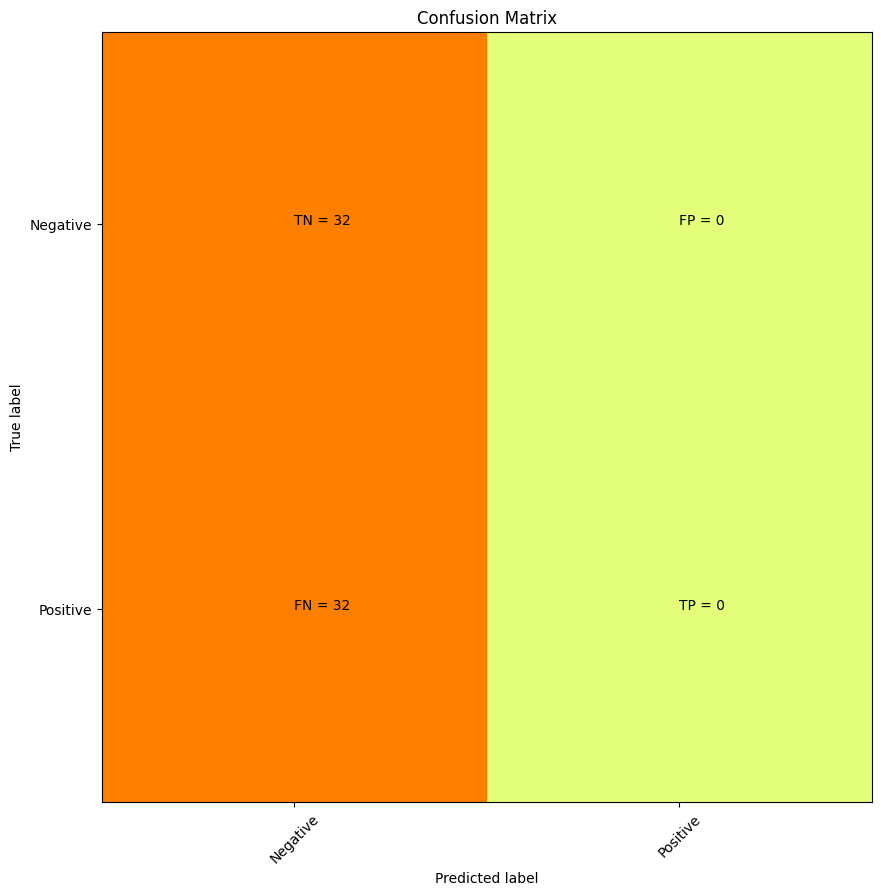

['All', 'GM-CSF'] precision = nan recall = 0.0
features 440
target 440
(88, 64, 64, 3)
(352, 64, 64, 3)
Epoch 1/10
12/12 [==============================] - 13s 708ms/step - loss: 4.8866 - val_loss: 4.4581
Epoch 2/10
12/12 [==============================] - 6s 512ms/step - loss: 4.8847 - val_loss: 4.4581
Epoch 3/10
12/12 [==============================] - 6s 484ms/step - loss: 4.9007 - val_loss: 4.4581
Epoch 4/10
12/12 [==============================] - 7s 619ms/step - loss: 4.8806 - val_loss: 4.4581
Epoch 5/10
12/12 [==============================] - 6s 480ms/step - loss: 4.8943 - val_loss: 4.4581
Epoch 6/10
12/12 [==============================] - 6s 529ms/step - loss: 4.8993 - val_loss: 4.4581
Epoch 7/10
12/12 [==============================] - 6s 482ms/step - loss: 4.9029 - val_loss: 4.4581
Epoch 8/10
12/12 [==============================] - 6s 528ms/step - loss: 4.8923 - val_loss: 4.4581
Epoch 9/10
12/12 [==============================] - 6s 478ms/step - loss: 4.8848 - val_loss: 4.

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


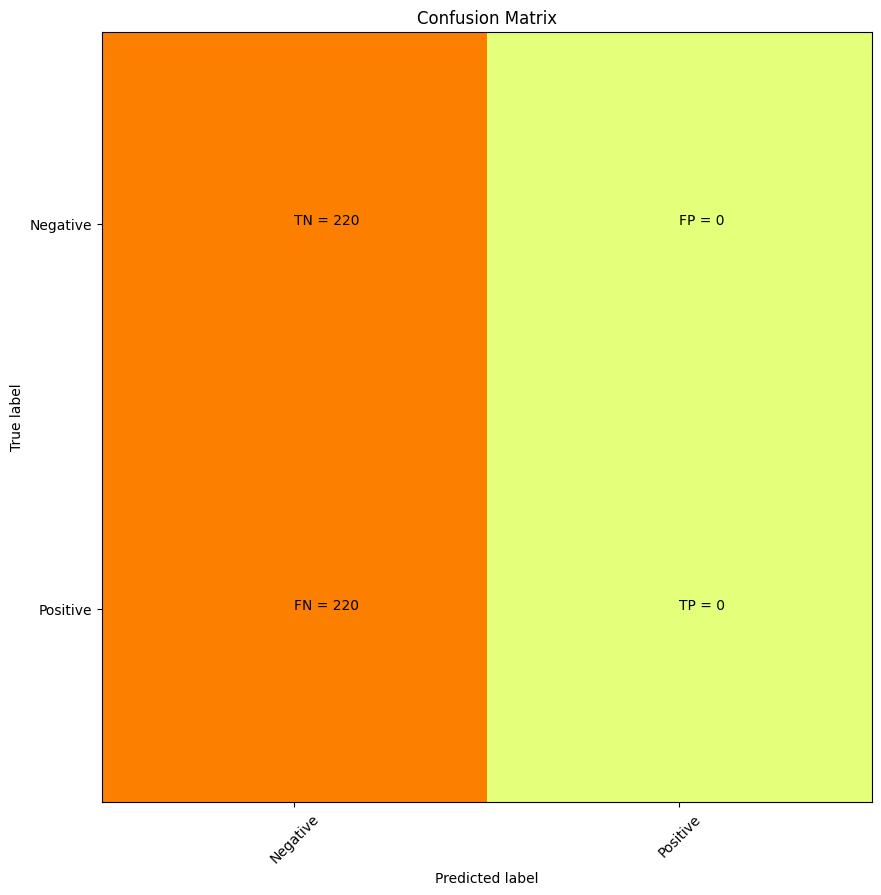

['All', 'IL-1 alpha'] precision = nan recall = 0.0
features 720
target 720
(144, 64, 64, 3)
(576, 64, 64, 3)
Epoch 1/10
20/20 [==============================] - 17s 607ms/step - loss: 4.8565 - val_loss: 4.6149
Epoch 2/10
20/20 [==============================] - 10s 497ms/step - loss: 4.8569 - val_loss: 4.6149
Epoch 3/10
20/20 [==============================] - 10s 501ms/step - loss: 4.8641 - val_loss: 4.6149
Epoch 4/10
20/20 [==============================] - 9s 478ms/step - loss: 4.8499 - val_loss: 4.6149
Epoch 5/10
20/20 [==============================] - 10s 485ms/step - loss: 4.8550 - val_loss: 4.6149
Epoch 6/10
20/20 [==============================] - 10s 531ms/step - loss: 4.8602 - val_loss: 4.6149
Epoch 7/10
20/20 [==============================] - 10s 499ms/step - loss: 4.8665 - val_loss: 4.6149
Epoch 8/10
20/20 [==============================] - 10s 496ms/step - loss: 4.8660 - val_loss: 4.6149
Epoch 9/10
20/20 [==============================] - 10s 519ms/step - loss: 4.8538 - 

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


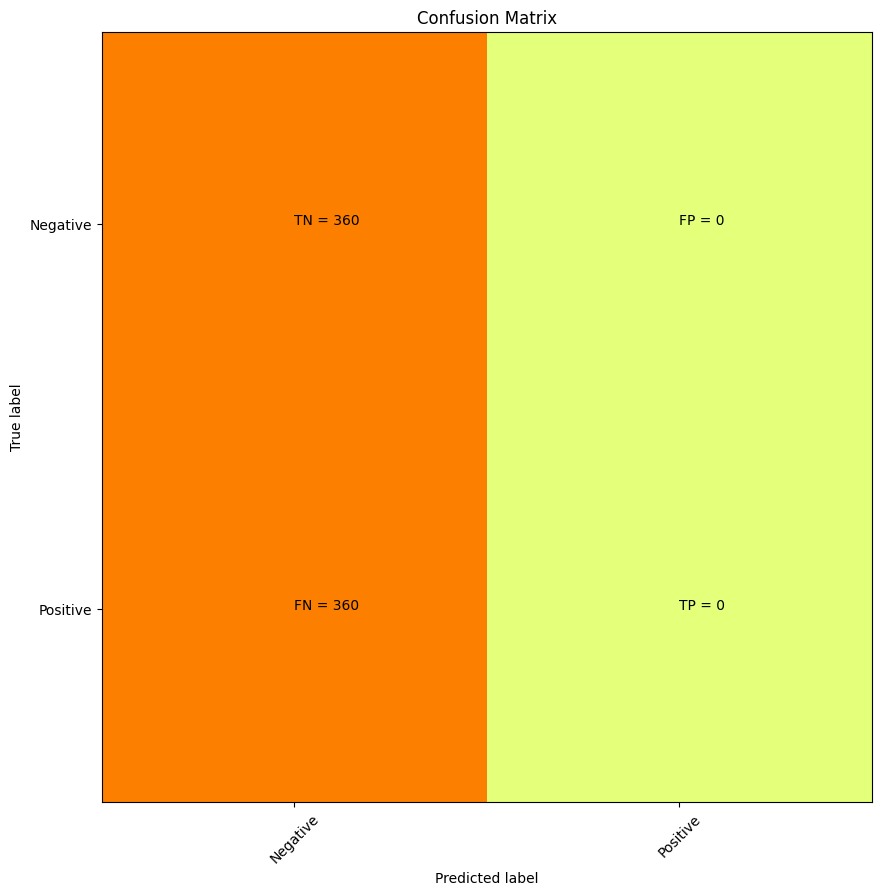

['All', 'IL-1 beta'] precision = nan recall = 0.0
features 216
target 216
(44, 64, 64, 3)
(172, 64, 64, 3)
Epoch 1/10
6/6 [==============================] - 10s 875ms/step - loss: 4.7702 - val_loss: 4.9786
Epoch 2/10
6/6 [==============================] - 3s 489ms/step - loss: 4.7856 - val_loss: 4.9786
Epoch 3/10
6/6 [==============================] - 4s 697ms/step - loss: 4.7809 - val_loss: 4.9786
Epoch 4/10
6/6 [==============================] - 3s 484ms/step - loss: 4.7755 - val_loss: 4.9786
Epoch 5/10
6/6 [==============================] - 3s 507ms/step - loss: 4.7845 - val_loss: 4.9786
Epoch 6/10
6/6 [==============================] - 3s 487ms/step - loss: 4.7834 - val_loss: 4.9786
Epoch 7/10
6/6 [==============================] - 3s 599ms/step - loss: 4.7770 - val_loss: 4.9786
Epoch 8/10
6/6 [==============================] - 3s 491ms/step - loss: 4.7939 - val_loss: 4.9786
Epoch 9/10
6/6 [==============================] - 3s 489ms/step - loss: 4.7947 - val_loss: 4.9786
Epoch 10/1

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


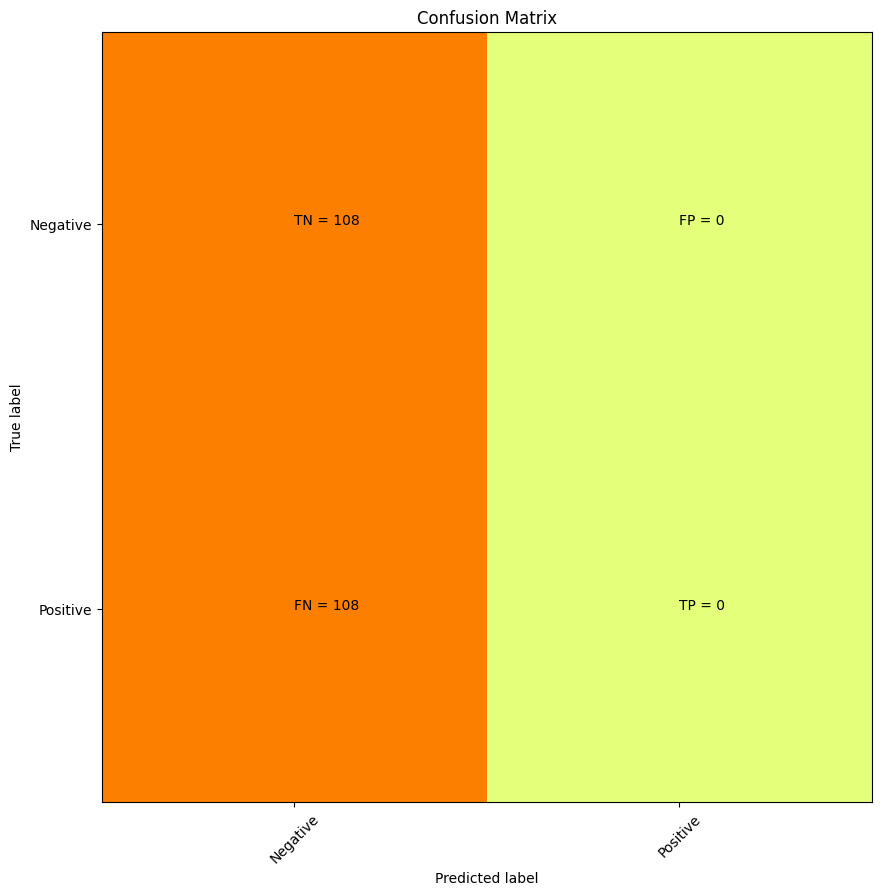

['All', 'IL-12 p40'] precision = nan recall = 0.0
features 504
target 504
(101, 64, 64, 3)
(403, 64, 64, 3)
Epoch 1/10
14/14 [==============================] - 14s 667ms/step - loss: 4.8612 - val_loss: 4.6396
Epoch 2/10
14/14 [==============================] - 7s 475ms/step - loss: 4.8590 - val_loss: 4.6396
Epoch 3/10
14/14 [==============================] - 7s 517ms/step - loss: 4.8572 - val_loss: 4.6396
Epoch 4/10
14/14 [==============================] - 7s 472ms/step - loss: 4.8581 - val_loss: 4.6396
Epoch 5/10
14/14 [==============================] - 7s 517ms/step - loss: 4.8601 - val_loss: 4.6396
Epoch 6/10
14/14 [==============================] - 7s 483ms/step - loss: 4.8447 - val_loss: 4.6396
Epoch 7/10
14/14 [==============================] - 7s 494ms/step - loss: 4.8544 - val_loss: 4.6396
Epoch 8/10
14/14 [==============================] - 7s 513ms/step - loss: 4.8754 - val_loss: 4.6396
Epoch 9/10
14/14 [==============================] - 7s 471ms/step - loss: 4.8697 - val_loss

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


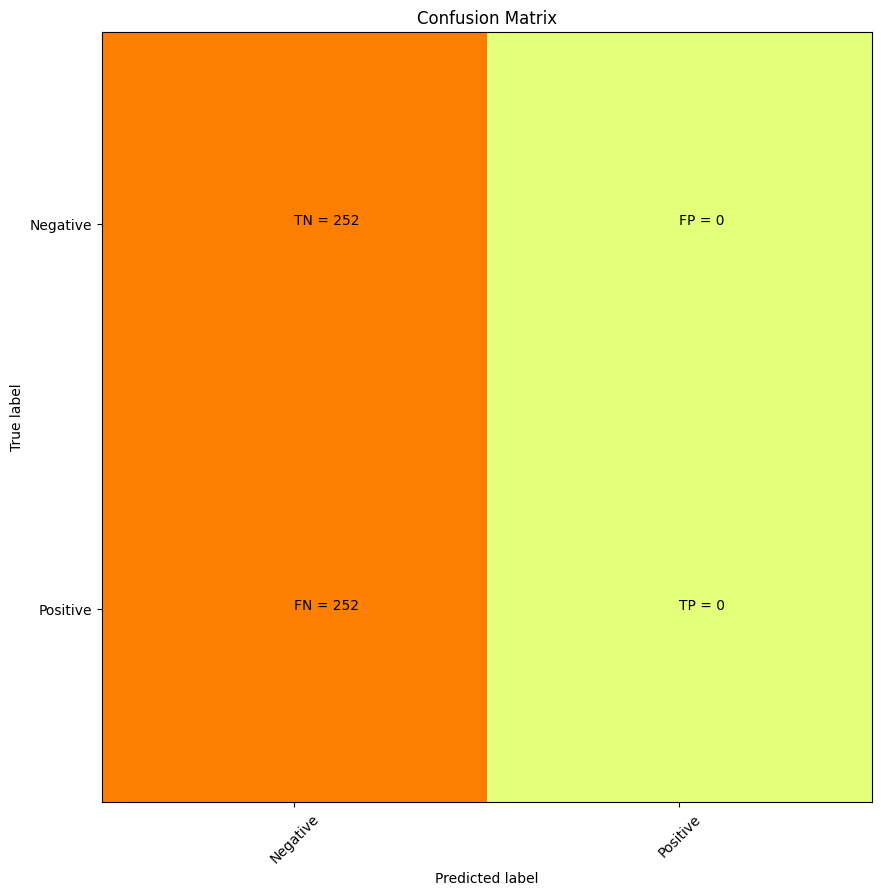

['All', 'IL-16'] precision = nan recall = 0.0
features 544
target 544
(109, 64, 64, 3)
(435, 64, 64, 3)
Epoch 1/10
15/15 [==============================] - 15s 658ms/step - loss: 4.6844 - val_loss: 5.3057
Epoch 2/10
15/15 [==============================] - 7s 474ms/step - loss: 4.6938 - val_loss: 5.3057
Epoch 3/10
15/15 [==============================] - 8s 515ms/step - loss: 4.6656 - val_loss: 5.3057
Epoch 4/10
15/15 [==============================] - 7s 476ms/step - loss: 4.6757 - val_loss: 5.3057
Epoch 5/10
15/15 [==============================] - 8s 507ms/step - loss: 4.6822 - val_loss: 5.3057
Epoch 6/10
15/15 [==============================] - 8s 518ms/step - loss: 4.6774 - val_loss: 5.3057
Epoch 7/10
15/15 [==============================] - 7s 480ms/step - loss: 4.6796 - val_loss: 5.3057
Epoch 8/10
15/15 [==============================] - 8s 513ms/step - loss: 4.6937 - val_loss: 5.3057
Epoch 9/10
15/15 [==============================] - 7s 490ms/step - loss: 4.6783 - val_loss: 5.

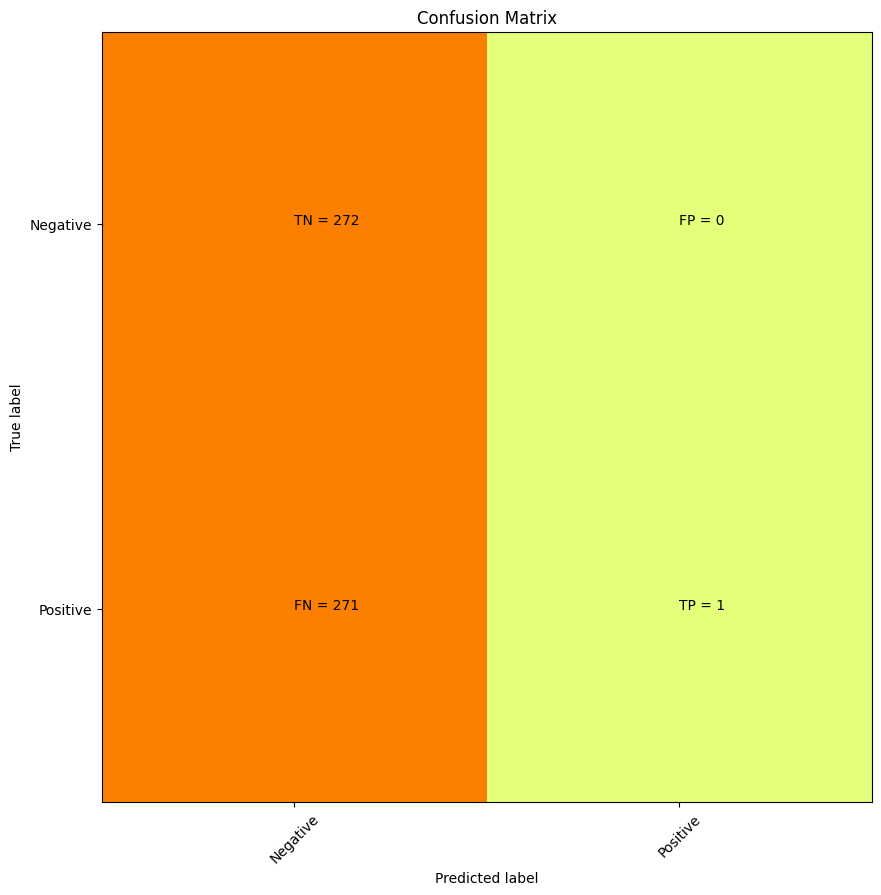

['All', 'IL-6 R alpha'] precision = 1.0 recall = 0.003676470588235294
features 1288
target 1288
(258, 64, 64, 3)
(1030, 64, 64, 3)
Epoch 1/10
35/35 [==============================] - 24s 567ms/step - loss: 4.7846 - val_loss: 4.9008
Epoch 2/10
35/35 [==============================] - 17s 496ms/step - loss: 4.7739 - val_loss: 4.9008
Epoch 3/10
35/35 [==============================] - 18s 525ms/step - loss: 4.7890 - val_loss: 4.9008
Epoch 4/10
35/35 [==============================] - 17s 495ms/step - loss: 4.7885 - val_loss: 4.9008
Epoch 5/10
35/35 [==============================] - 18s 513ms/step - loss: 4.7876 - val_loss: 4.9008
Epoch 6/10
35/35 [==============================] - 17s 500ms/step - loss: 4.7789 - val_loss: 4.9008
Epoch 7/10
35/35 [==============================] - 18s 509ms/step - loss: 4.7844 - val_loss: 4.9008
Epoch 8/10
35/35 [==============================] - 17s 495ms/step - loss: 4.7931 - val_loss: 4.9008
Epoch 9/10
35/35 [==============================] - 17s 500ms

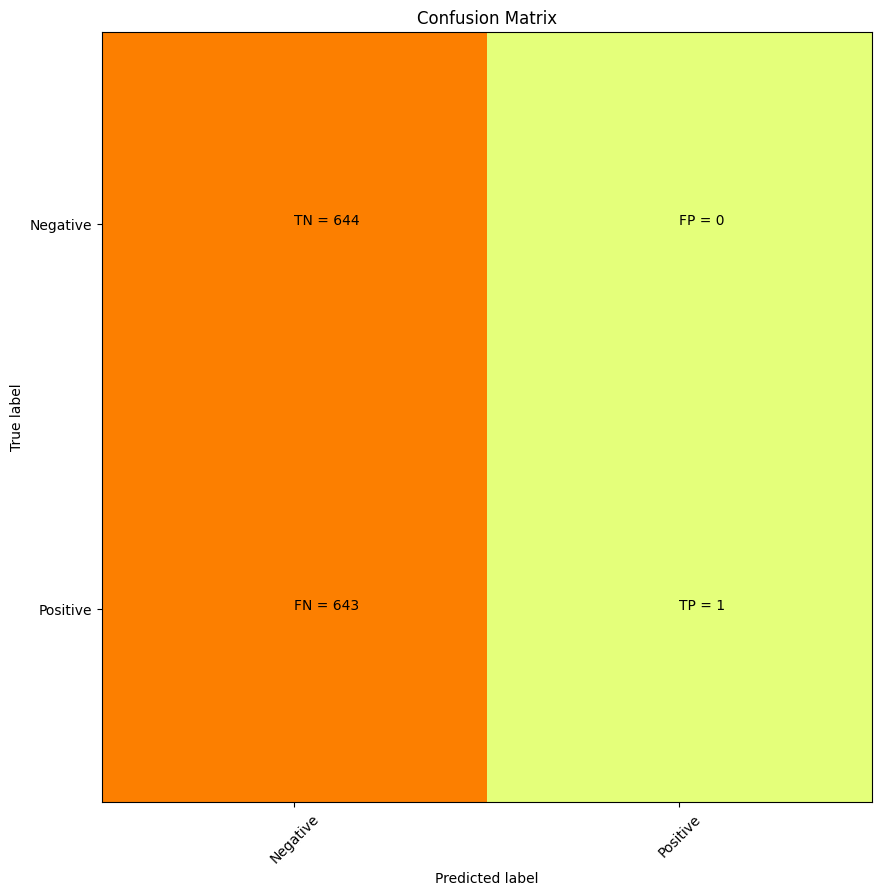

['All', 'IL-6'] precision = 1.0 recall = 0.0015527950310559005
features 352
target 352
(71, 64, 64, 3)
(281, 64, 64, 3)
Epoch 1/10
10/10 [==============================] - 12s 748ms/step - loss: 4.8517 - val_loss: 4.6444
Epoch 2/10
10/10 [==============================] - 5s 469ms/step - loss: 4.8461 - val_loss: 4.6444
Epoch 3/10
10/10 [==============================] - 5s 537ms/step - loss: 4.8566 - val_loss: 4.6444
Epoch 4/10
10/10 [==============================] - 5s 467ms/step - loss: 4.8333 - val_loss: 4.6444
Epoch 5/10
10/10 [==============================] - 5s 503ms/step - loss: 4.8531 - val_loss: 4.6444
Epoch 6/10
10/10 [==============================] - 5s 478ms/step - loss: 4.8569 - val_loss: 4.6444
Epoch 7/10
10/10 [==============================] - 5s 464ms/step - loss: 4.8554 - val_loss: 4.6444
Epoch 8/10
10/10 [==============================] - 5s 529ms/step - loss: 4.8441 - val_loss: 4.6444
Epoch 9/10
10/10 [==============================] - 5s 472ms/step - loss: 4.844

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


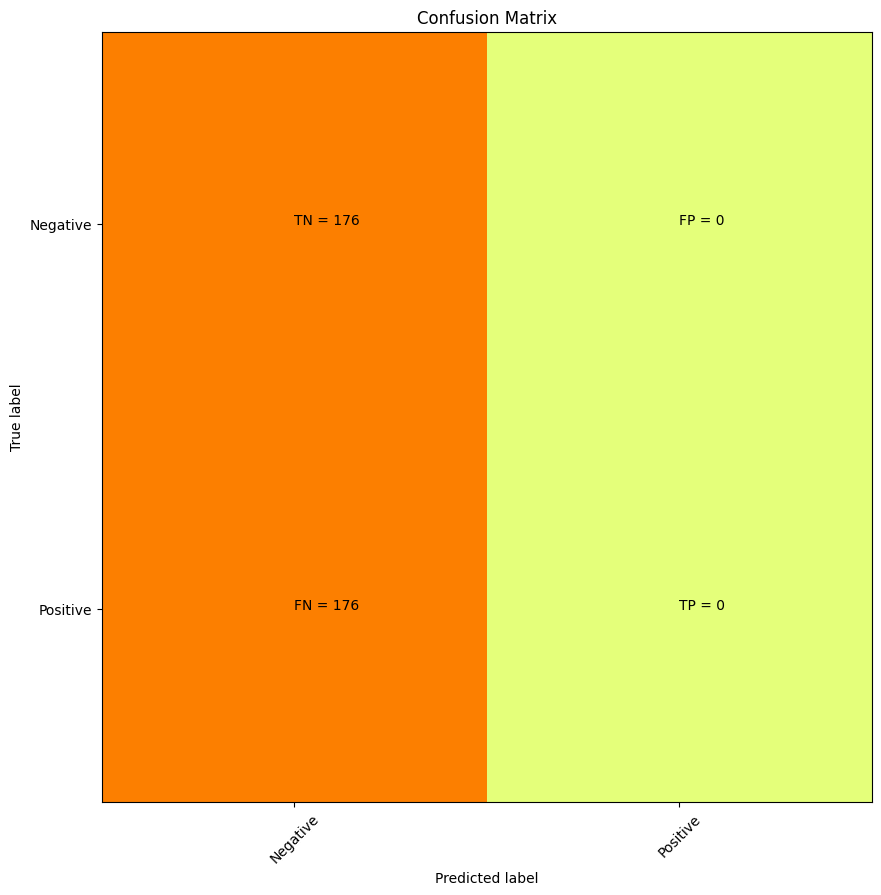

['All', 'IL-8'] precision = nan recall = 0.0
features 232
target 232
(47, 64, 64, 3)
(185, 64, 64, 3)
Epoch 1/10
7/7 [==============================] - 10s 876ms/step - loss: 4.8316 - val_loss: 4.7461
Epoch 2/10
7/7 [==============================] - 3s 456ms/step - loss: 4.8514 - val_loss: 4.7461
Epoch 3/10
7/7 [==============================] - 3s 448ms/step - loss: 4.8583 - val_loss: 4.7461
Epoch 4/10
7/7 [==============================] - 3s 445ms/step - loss: 4.8369 - val_loss: 4.7461
Epoch 5/10
7/7 [==============================] - 4s 543ms/step - loss: 4.8281 - val_loss: 4.7461
Epoch 6/10
7/7 [==============================] - 3s 450ms/step - loss: 4.8487 - val_loss: 4.7461
Epoch 7/10
7/7 [==============================] - 3s 448ms/step - loss: 4.8299 - val_loss: 4.7461
Epoch 8/10
7/7 [==============================] - 3s 465ms/step - loss: 4.8283 - val_loss: 4.7461
Epoch 9/10
7/7 [==============================] - 4s 491ms/step - loss: 4.8357 - val_loss: 4.7461
Epoch 10/10
1/1

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


['All', 'MMP-9'] precision = nan recall = 0.0
features 696
target 696
(140, 64, 64, 3)
(556, 64, 64, 3)
Epoch 1/10
19/19 [==============================] - 20s 816ms/step - loss: 4.7145 - val_loss: 5.2424
Epoch 2/10
19/19 [==============================] - 10s 518ms/step - loss: 4.7087 - val_loss: 5.2424
Epoch 3/10
19/19 [==============================] - 10s 512ms/step - loss: 4.7089 - val_loss: 5.2424
Epoch 4/10
19/19 [==============================] - 10s 515ms/step - loss: 4.7085 - val_loss: 5.2424
Epoch 5/10
19/19 [==============================] - 10s 514ms/step - loss: 4.7058 - val_loss: 5.2424
Epoch 6/10
19/19 [==============================] - 10s 512ms/step - loss: 4.7100 - val_loss: 5.2424
Epoch 7/10
19/19 [==============================] - 9s 486ms/step - loss: 4.7102 - val_loss: 5.2424
Epoch 8/10
19/19 [==============================] - 10s 514ms/step - loss: 4.7139 - val_loss: 5.2424
Epoch 9/10
19/19 [==============================] - 10s 518ms/step - loss: 4.7087 - val_l

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


['All', 'TNF RII'] precision = nan recall = 0.0
features 496
target 496
(100, 64, 64, 3)
(396, 64, 64, 3)
Epoch 1/10
14/14 [==============================] - 14s 668ms/step - loss: 4.6558 - val_loss: 5.3834
Epoch 2/10
14/14 [==============================] - 7s 473ms/step - loss: 4.6577 - val_loss: 5.3834
Epoch 3/10
14/14 [==============================] - 7s 513ms/step - loss: 4.6697 - val_loss: 5.3834
Epoch 4/10
14/14 [==============================] - 7s 471ms/step - loss: 4.6533 - val_loss: 5.3834
Epoch 5/10
14/14 [==============================] - 7s 510ms/step - loss: 4.6555 - val_loss: 5.3834
Epoch 6/10
14/14 [==============================] - 7s 509ms/step - loss: 4.6510 - val_loss: 5.3834
Epoch 7/10
14/14 [==============================] - 7s 474ms/step - loss: 4.6540 - val_loss: 5.3834
Epoch 8/10
14/14 [==============================] - 7s 511ms/step - loss: 4.6575 - val_loss: 5.3834
Epoch 9/10
14/14 [==============================] - 7s 472ms/step - loss: 4.6621 - val_loss: 

<ipython-input-9-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


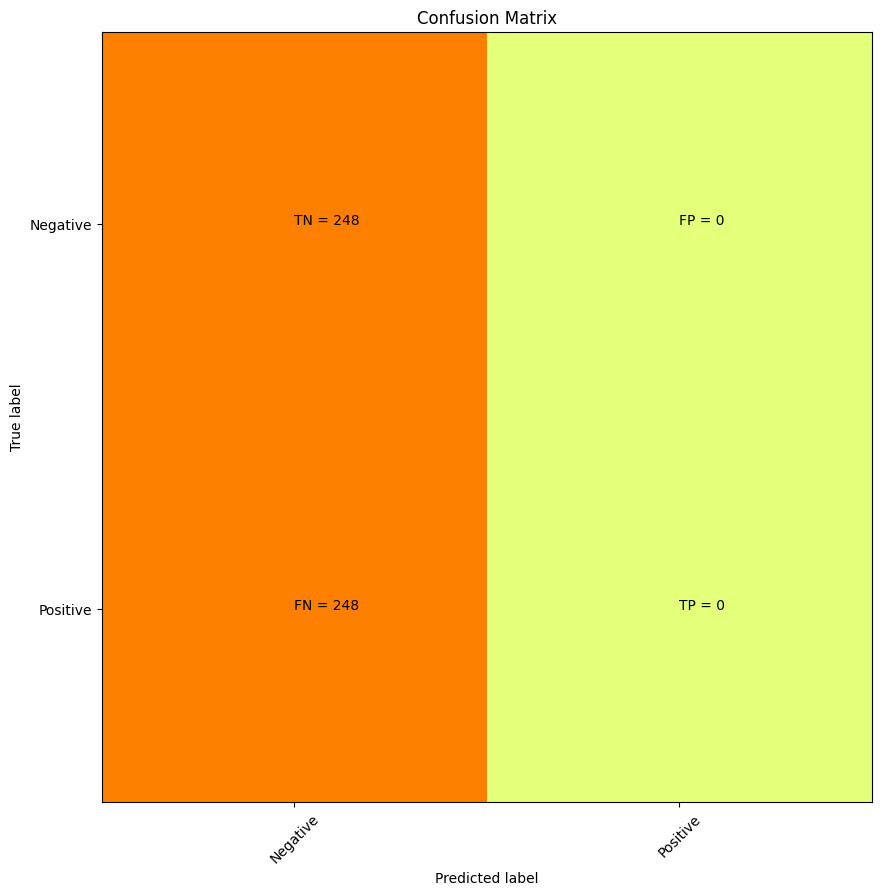

['All', 'TNF alpha'] precision = nan recall = 0.0


Cytokine  Precision    Recall  F1 Score Augmentation
0      Activin A        NaN  0.000000       NaN          All
1           CCL1        NaN  0.000000       NaN          All
2          CCL19        NaN  0.000000       NaN          All
3           CCL2        NaN  0.000000       NaN          All
4          CCL20        1.0  0.008333  0.016529          All
5          CCL22        NaN  0.000000       NaN          All
6           CCL4        NaN  0.000000       NaN          All
7           CCL5        NaN  0.000000       NaN          All
8           CD14        1.0  0.004098  0.008163          All
9            CRP        NaN  0.000000       NaN          All
10         CXCL1        NaN  0.000000       NaN          All
11        CXCL10        NaN  0.000000       NaN          All
12        CXCL13        NaN  0.000000       NaN          All
13         CXCL3        0.0  0.000000       NaN          All
14         CXCL5        0.0  0.000000       NaN          All
15         G-CSF        NaN  0.000000       NaN          All
16        GM-CSF        NaN  0.000000       NaN          All
17    IL-1 alpha        NaN  0.000000       NaN          All
18     IL-1 beta        NaN  0.000000       NaN          All
19     IL-12 p40        NaN  0.000000       NaN          All
20         IL-16        NaN  0.000000       NaN          All
21  IL-6 R alpha        1.0  0.003676  0.007326          All
22          IL-6        1.0  0.001553  0.003101          All
23          IL-8        NaN  0.000000       NaN          All
24         MMP-9        NaN  0.000000       NaN          All
25       TNF RII        NaN  0.000000       NaN          All
26     TNF alpha        NaN  0.000000       NaN          All

In [15]:
totalresultsunscaledvit = []


for df in longdfs:
  indices = list(df.index.values)
  features = []

  for i in indices:
    thing = total_arrays[i]
    features.append(thing)
    thing2 = total_arrays[i+384]
    features.append(thing2)
    thing3 = total_arrays[i+384+384]
    features.append(thing3)
    thing4 = total_arrays[i+384+384+384]
    features.append(thing4)


  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]
  #this is 2 arrays
  #put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.2)


  #reshaping gray scale images so that we can use the RGB transformer

  for i in range(len(X_test)):
    X_test[i] = np.stack((X_test[i],)*3, axis=-1)
    X_test[i] = np.squeeze(X_test[i])

  for i in range(len(X_train)):
    X_train[i] = np.stack((X_train[i],)*3, axis=-1)
    X_train[i] = np.squeeze(X_train[i])


  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  print(test_images.shape)
  print(train_images.shape)

#get a model for each cytokine

  # vitmodel_temp = tf.keras.models.clone_model(vitmodel)

#cant figure out how to clone this one, don't think this will work???? (ie, it will keep training instead of reverting back to default and starting over)
  vitmodel_temp = vit_model

  vitmodel_temp.compile(optimizer='adam', loss='binary_crossentropy')


  vitmodel_temp.fit(train_images, train_labels, epochs=10,
            validation_data=(test_images, test_labels), batch_size=30)

#get predictions

  preds = []
  for i in range(len(features)):
    single = features[i]
    single = np.stack((single,)*3, axis=-1)
    single = np.squeeze(single)
    single = np.expand_dims(single, axis=0)
    preds.append(vitmodel_temp.predict(single))
  preds

  #this part of the code has changed slightly to accomodate the new single number output
  answer = []
  for i in range(len(preds)):
    if preds[i][0][0]<=0.5:
      answer.append(0)
    else:
      answer.append(1)
  answer

  precision, recall = confusio_matrix(target2final,answer, ['All',df.columns[0]])

  f1_score = 2*(precision*recall)/(precision+recall)

  totalresultsunscaledvit.append([df.columns[0],precision, recall, f1_score])

#summarize metrics

summarizer_totalunscaledvit = pd.DataFrame(columns =["Cytokine", "Precision", "Recall", "F1 Score", "Augmentation"])

for i in range(len(totalresultsunscaledvit)):
  f1_score = totalresultsunscaledvit[i][3]
  precision = totalresultsunscaledvit[i][1]
  recall = totalresultsunscaledvit[i][2]
  cytokine = totalresultsunscaledvit[i][0]
  augmentation = "All"
  tracking = [cytokine, precision, recall, f1_score, augmentation]
  summarizer_totalunscaledvit.loc[len(summarizer_totalunscaledvit.index)] = tracking

summarizer_totalunscaledvit